Идея:
* Попробовать строить модели с большим числом тем и включать регуляризатор отбора тем
* регуляризатор отбора тем нельзя включать сразу
* регуляризатор отбора тем нельзя включать вместе с регуляризатором декоррелирования


status: not done

comp: work

**Без регуляризатора**
* 150 -> 135, 0.85
* **kernel size**: 24 vs 18, **purity**: .63 vs .63, **contrast** .78 vs .74, **$phi_{ij}$**: --+-- 
* **closest by dist**: колонки ближе, чем оригинальные (порог 0.6 - h20 колонок)
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|  closest by dist test/original   	|h5-j18	|**j70-h90**|j90-h100|    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|  h5  	|**h70**| h82  	| h100 	|
| closest by opt res original/test 	|  h10 	|**h93**| h97  	| h100 	||

**Наилучший по dist res test/original**
* create_model_rch_150_2_decor_ts(6 -2 -2; 0.7 -0.5 -0.5)
* 150 -> 129, 0.98
* **kernel size**: 24 vs 17, **purity**: .63 vs .63, **contrast** .78 vs .79, **$phi_{ij}$**:  --+--
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|  j10  |j50-**h70**|j90-h96|    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|  0  	|  h55 	|  h88 	| h100 	|
| closest by opt res original/test 	|  - 	|**h82**|  h98	|   	||

**Наилучший по opt res test/original**
* create_model_rch_150_4_ts(0.7 -2 -2) 
* 150 -> 112, 0.96
* **kernel size**: 24 vs 19, **purity**: .63 vs .50, **contrast** .78 vs .79, **$phi_{ij}$**: +++++ (closer)  
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|  j10  |j58-h55|j90-h98|    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|  0  	|**h65**| h98  	| h100 	|
| closest by opt res original/test 	|  - 	|  h58 	|  h98	|   	||

**Наилучший по opt res original/test** см. dist res test/original

In [1]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
import matplotlib.pyplot as plt
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')

import distances_helper as dh 
import print_helper as ph
import create_model_helper as cmh
import build_convex_hull_helper as bchh
import test_vs_original_columns_helper as tvsoch
import compare_two_models as ctm

from plot_helper import PlotMaker
from config_helper import ConfigPaths
from scipy.optimize import minimize

0.8.1


In [2]:
config = ConfigPaths('config_sample_m3.cfg')
print config.models_file_name
models_file = open(config.models_file_name, 'a')

plot_maker = PlotMaker()

batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

Q:\\topic_modeling\\csi_science_collections.git\experiments\pn_model3\np_03_04_150\models.txt


In [20]:
def save_pickle_file(dists, filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def load_pickle_file(filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file
def plot_convex_hull_topics_iterations_distribution(_phi_convex_hull):
    get_iteration_number_fn = lambda x: int(x[x.find('_', 6) + 1 : ])
    phi_convex_hull_iteration_number = [get_iteration_number_fn(col) for col in _phi_convex_hull.columns]
    phi_convex_hull_iteration_number = [(val, phi_convex_hull_iteration_number.count(val), 1.0 * phi_convex_hull_iteration_number.count(val) / len(phi_convex_hull_iteration_number)) for val in set(phi_convex_hull_iteration_number)]
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[1] for x in phi_convex_hull_iteration_number], ax=ax1)
    ax1.set_title('Number of topics from each iteration')
    ax1.set_xlabel('n iteration')

    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[2] for x in phi_convex_hull_iteration_number], ax=ax2)
    ax2.set_title('Number of topics from each iteration (%)')
    ax2.set_xlabel('n iteration')
def plot_convex_hull_columns_change(iterations_info):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    ax1.plot([sum([val['n_topics_to_remove']for val in it['iterations_info_filter']]) for it in iterations_info], 
             color='r', label = 'total')
    ax1.set_title('Num columns to remove')
    get_topic_iteration_fn = lambda x: int(x[x.rfind('_') + 1 :])
    get_topic_filter_iteration_list_fn = lambda x, y: [get_topic_iteration_fn(topic) for topic in x].count(y)
    n_topics_removed_from_current_iteration = [sum([get_topic_filter_iteration_list_fn(val['removed_topics'], indx) for val in it['iterations_info_filter']]) for indx, it in enumerate(iterations_info)]
    ax1.plot(n_topics_removed_from_current_iteration, color='b', label='current iteration')
    ax1.set_xlabel('n iteration')
    ax1.legend()

    ax2.plot([val['phi_convex_hull_shape'][1] for val in iterations_info], color='r')
    ax2.set_title('Num columns of convex hull')
    ax2.set_xlabel('n iteration')
    ax2.legend()
def plot_opt_res_fun(iterations_filtering_info_name):
    %matplotlib inline
    iterations_filtering_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_filtering_info for val in item for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item for x in val['opt_res'].values()] for item in iterations_filtering_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def plot_opt_res_fun_filtering(iterations_filtering_info_name):
    iterations_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_info for val in item['iterations_info_filter'] for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item['iterations_info_filter'] for x in val['opt_res'].values()] for item in iterations_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def get_phi_granularity(phi):
    return np.mean([get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()])
def get_words_close_to_th_count(col, global_th=0.95):
    cur_sum, sum_count = 0, 0
    for val in col.sort_values()[::-1]:
        if cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_opt_x_granularity(opt):
    return np.mean([get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt.iteritems()])
def get_opt_x_close_to_th_count(opt_x, cut_th=None, global_th=0.95):
    cur_sum, sum_count = 0, 0
    opt_x_val = opt_x.copy()
    if cut_th != None:
        opt_x_val[opt_x_val < cut_th] = 0
    for val in sorted(opt_x_val)[::-1]:
        if val !=0 and cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count + 1, cur_sum
def get_and_plot_granularity(phi, opt_to_original, name):
    x_count_grans = [get_opt_x_close_to_th_count(opt_res.x)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean = np.mean(x_count_grans)
    x_count_grans_th = [get_opt_x_close_to_th_count(opt_res.x, cut_th=5*1e-2)[0] for topic, opt_res in opt_to_original.iteritems()]
    x_count_grans_mean_th = np.mean(x_count_grans_th)
    grans = [get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()]
    grans_mean = np.mean(grans) 
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    sns.distplot(x_count_grans, color='r', bins=5, ax=ax1)
    sns.distplot(x_count_grans_th, color='b', bins=5, ax=ax1)
    for topic, opt_res in opt_to_original.iteritems():
        ax2.plot(sorted(opt_res.x)[::-1])
    sns.distplot(grans, color='r', bins=5, ax=ax3)
    title = '{} {} \nx_count_grans_mean = {}; th={}'.format(name, phi.shape, x_count_grans_mean, x_count_grans_mean_th)
    ax1.set_title(title)
    title = '{} {} \ngrans_mean = {}'.format(name, phi.shape, grans_mean)
    ax3.set_title(title)

    return x_count_grans, x_count_grans_mean, grans, grans_mean

def plot_different_distances(different_distances, title):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    
    if dh.kl_dist in different_distances.keys():
        vals = different_distances[dh.kl_dist].values.flatten()
        sns.distplot(vals, color='y', ax=ax1, label='kl')
    if dh.kl_sym_dist in different_distances.keys():
        vals = different_distances[dh.kl_sym_dist].values.flatten()
        sns.distplot(vals, color='m', ax=ax1, label='kl_sym')
    
    if dh.jaccard_dist in different_distances.keys():
        vals = different_distances[dh.jaccard_dist].values.flatten()
        sns.distplot(vals, color='r', ax=ax2, label='jaccard')
        plt.xlim(0.6, 1)
        sns.distplot(vals, color='r', ax=ax3, label='jaccard')

    if dh.cos_dist in different_distances.keys():
        vals = different_distances[dh.cos_dist].values.flatten()
        sns.distplot(vals,  color='b', ax=ax2, label='cos')
        plt.xlim(0.6, 1)
        sns.distplot(vals, color='b', ax=ax3, label='cos')

    if dh.hellinger_dist in different_distances.keys():
        vals = different_distances[dh.hellinger_dist].values.flatten()
        sns.distplot(vals, color='g', ax=ax2, label='hellinger')
        plt.xlim(0.6, 1)
        sns.distplot(vals, color='g', ax=ax3, label='hellinger')
    ax1.legend()
    ax2.legend()    
    if title != '':
        fig.suptitle(title, fontsize=14, fontweight='bold')
# def get_distances(phi):
#     different_distances = {}
#     distances = [dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]
#     for dist_fn in distances:
#         different_distances[dist_fn] = dh.calculate_distances(dist_fn, phi, phi)
#     return different_distances
def get_distances(phi, distances=[dh.jaccard_dist, dh.cos_dist, dh.hellinger_dist, dh.kl_dist, dh.kl_sym_dist]):
    different_distances = {}    
    for dist_fn in distances:
        print('Processing {}'.format(dist_fn))
        tmp = dh.calculate_distances(dist_fn, phi, phi)        
        if not np.any(tmp == np.inf) and not np.any(tmp == np.nan):
            different_distances[dist_fn] = tmp
    return different_distances
def save_and_plot(idx, names_list, phi_convex_hull_list, iterations_info_list, iterations_filtering_list):
    save_pickle_file(phi_convex_hull_list[idx], 'phi_convex_hull___' + names_list[idx])
    save_pickle_file(iterations_info_list[idx], 'iterations_info_list___' + names_list[idx])
    save_pickle_file(iterations_filtering_list[idx], 'iterations_filtering_list___' + names_list[idx])

    plot_convex_hull_topics_iterations_distribution(phi_convex_hull_list[idx])
    plot_convex_hull_columns_change(iterations_info_list[idx])

    distances_to_original_list = bchh.calculate_distances(DIST_FN, phi_convex_hull_list[idx], phi_original)
    opt_res_to_original_list = bchh.get_optimization_result(DIST_FN, None, phi_convex_hull_list[idx], phi_original,
                                                       distances_to_original_list[idx], n_closest_topics=N_CLOSEST_TOPICS_COUNT)
    opt_original_to_res_list = bchh.get_optimization_result(DIST_FN, None, phi_original,  phi_convex_hull_list[idx],
                                                       distances_to_original_list[idx].T, n_closest_topics=N_CLOSEST_TOPICS_COUNT)

    _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_res_to_original_list[idx], names_list[idx])
    _,_,_,_ = get_and_plot_granularity(phi_convex_hull_list[idx], opt_original_to_res_list[idx], names_list[idx])
    plot_dists(opt_res_to_original_list[idx], opt_original_to_res_list[idx], names_list[idx])
    
    different_distances = get_distances(phi_convex_hull_list[idx])
    different_distances_to_original = tvsoch.get_test_to_original_result_different_distances(phi_convex_hull_list[idx], phi_convex_hull_list[idx])
    tvsoch.plot_original_columns_count_different_distances(different_distances_to_original, n_original_columns_count=100)
    plot_different_distances(different_distances)
    return distances_to_original_list, opt_res_to_original_list, opt_original_to_res_list, different_distances, different_distances_to_original


Загрузим оригинальный sample датасет (от model3), до этого скопировав в папку с batches нужные pickle файлы модели.
Сначала провизуалируем по одной итерации каждой новой модели, а потом будем итерационно строить выпуклую оболочку для каждой модели по отдельности и затем сравнивать их. 

In [4]:
phi_original, theta_original = load_pickle_file('phi_model3.p', config.output_batches_path), load_pickle_file('theta_model3.p', config.output_batches_path)
phi_nwt_original = pd.DataFrame(0, index=phi_original.index, columns=[])
print phi_original.shape, theta_original.shape

(2216, 100) (100, 3446)


In [21]:
def check_topic_ok(topic_phi, _debug=False):
    if type(topic_phi) != np.ndarray:
        topic_phi = np.array(topic_phi)
    significant_element_th_large, significant_element_th_small = 0.01, 0.005
    significant_elements_count_large, significant_elements_count_small = 5, 10
    # sum must be != 0 (after regulizators some topics may be zero)
    topic_sum_rule = np.sum(topic_phi) > 1e-1
    # topic must have at least n words with probability greater that th
    topic_significant_elements_count_large = len(np.where(topic_phi > significant_element_th_large)[0])
    topic_significant_elements_count_small = len(np.where(topic_phi > significant_element_th_small)[0])
    topic_significant_elements_large_rule = topic_significant_elements_count_large >= significant_elements_count_large
    topic_significant_elements_small_rule = topic_significant_elements_count_small >= significant_elements_count_small
    topic_docs_count_rule = None
    if _debug:
        print('topic_sum_rule = {} [{}], topic_significant_elements_large_rule = {} [{}], topic_significant_elements_small_rule = {} [{}]' \
              .format(topic_sum_rule, np.sum(topic_phi), 
                      topic_significant_elements_large_rule, topic_significant_elements_count_large, 
                      topic_significant_elements_small_rule, topic_significant_elements_count_small))
    return topic_sum_rule and topic_significant_elements_large_rule and topic_significant_elements_small_rule
def check_topic_ok(topic_phi, _debug=False):
    if type(topic_phi) != np.ndarray:
        topic_phi = np.array(topic_phi)
    # sum must be != 0 (after regulizators some topics may be zero)
    topic_sum_rule = np.sum(topic_phi) > 1e-1
    # topic must have at least n words with probability greater that th
    return topic_sum_rule 
def reg_experiment(phi_original, phi_test, phi_nwt_original, phi_nwt_test):
    different_inter_distances_closest_1, different_inter_distances_closest_2 = None, None
    different_inter_distances_1, different_inter_distances_2 = None, None
    different_to_original_distances_closest_1, different_to_test_distances_closest_2 = None, None
    different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix = None, None, None
    try:
        ph.print_phi_top_tokens(phi_original, phi_test, n_top_tokens=13)
            
        models_compare_matrix = ctm.print_models_comparasion(phi_original, phi_test, phi_nwt_original, phi_nwt_test)

        % matplotlib inline
        different_inter_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_original,
                distances=[dh.jaccard_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_1, 
                                                               n_original_columns_count=phi_original.shape[1], 
                                                               title='closest by dist inter 1')
        different_inter_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_test,
                distances=[dh.jaccard_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_inter_distances_closest_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by dist inter 2')


        different_inter_distances_1 = get_distances(phi_original, distances=[dh.jaccard_dist, dh.hellinger_dist])
        plot_different_distances(different_inter_distances_1, 'inter distances 1')
        different_inter_distances_2 = get_distances(phi_test, distances=[dh.jaccard_dist, dh.hellinger_dist])
        plot_different_distances(different_inter_distances_2, 'inter distances 2')


        different_to_original_distances_closest_1 = tvsoch.get_test_to_original_result_different_distances(phi_test, phi_original,
                distances=[dh.jaccard_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_original_distances_closest_1, 
                                                               n_original_columns_count=phi_original.shape[1],
                                                               title='closest by dist test/original')
        different_to_test_distances_closest_2 = tvsoch.get_test_to_original_result_different_distances(phi_original, phi_test,
                distances=[dh.jaccard_dist, dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_test_distances_closest_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by dist original/test')


        different_to_original_opts_1 = tvsoch.get_test_to_original_opt_result_different_distances(phi_test, phi_original,
                                        distances=[dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_original_opts_1, 
                                                               n_original_columns_count=phi_original.shape[1],
                                                               title='closest by opt test/original')
        different_to_test_opts_2 = tvsoch.get_test_to_original_opt_result_different_distances(phi_original, phi_test,
                                        distances=[dh.hellinger_dist])
        tvsoch.plot_original_columns_count_different_distances(different_to_test_opts_2, 
                                                               n_original_columns_count=phi_test.shape[1],
                                                               title='closest by opt original/test')

        print different_to_original_opts_1[dh.hellinger_dist][1][1]
        
    except Exception as inst:
        print('An error happened')
        print type(inst)     # the exception instance
        print inst.args      # arguments stored in .args
        print inst           
        ;
    return different_inter_distances_closest_1, different_inter_distances_closest_2, \
           different_inter_distances_1, different_inter_distances_2, \
           different_to_original_distances_closest_1, different_to_test_distances_closest_2, \
           different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix
def print_phi_top_tokens(phi, topic_name, n_top_tokens=13):
    topic = phi.loc[:, topic_name]
    top_tokens_and_weight = ' '.join([u'{0}: {1:.3f}'.format(topic, weight) for topic, weight in topic.sort_values()[::-1][0:n_top_tokens].iteritems() if weight != 0])
    print(topic_name + '| ' + top_tokens_and_weight)
    
def experiment_result_to_df(different_to_original_distances_closest_1, different_to_test_distances_closest_2, \
                            different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix, init_num_topics):
    def get_result_by_distance_and_th(different_fns_ths, dist_fn, th):
        if dist_fn not in different_fns_ths.keys():
            return []
        if th not in different_fns_ths[dist_fn][1].keys():
            tmp = [(key, abs(key - th)) for key in different_fns_ths[dist_fn][1].keys()]
            tmp = sorted(tmp, key=lambda x: x[1])
            th = tmp[0][0]
        return different_fns_ths[dist_fn][1][th]
    def res_to_str(different_fns_ths, th):
        j_res = len(get_result_by_distance_and_th(different_fns_ths, dh.jaccard_dist, th))
        h_res = len(get_result_by_distance_and_th(different_fns_ths, dh.hellinger_dist, th))
        if j_res == h_res:
            res = 'jh{}'.format(j_res)
        else:
            res = 'j{}-h{}'.format(j_res, h_res)
        return res
    def get_second_index(init_num_topics, models_compare_matrix):
        num_topics = models_compare_matrix.loc['num topics', 'phi_2']
        zero_ratio = models_compare_matrix.loc['non zero ratio', 'phi_2']
        return '{0} -> {1:0.0f}, {2:0.2f}'.format(init_num_topics, num_topics, zero_ratio)
    def get_second_line(models_compare_matrix):
        def get_quantile_res(models_compare_matrix, index_name):
            tmp1 = models_compare_matrix.loc[index_name, 'phi_1']
            tmp2 = models_compare_matrix.loc[index_name, 'phi_2']
            is_diff = abs(tmp1 - tmp2) / tmp1 < 0.3
            res = '+' if is_diff else '-'
            return res
        avg_size = models_compare_matrix.loc['topic_kernel_average_size', 'phi_2']
        avg_purity = models_compare_matrix.loc['topic_kernel_average_purity', 'phi_2']
        avg_contrast = models_compare_matrix.loc['topic_kernel_average_contrast', 'phi_2']
        indices_names = ['|phi_ij > 0.2| / n_topics', '|phi_ij > 0.1| / n_topics', '|phi_ij > 0.01| / n_topics',
                         '|phi_ij > 0.05| / n_topics', '|phi_ij > 0.001| / n_topics']
        compare_quantile = ''.join([get_quantile_res(models_compare_matrix, index_name) for index_name in indices_names])
        res = ['24 vs {0:0.2f}'.format(avg_size), '.63 vs {0:0.2f}'.format(avg_purity), '.78 vs {0:0.2f}'.format(avg_contrast), compare_quantile]
        return res
    
    df = pd.DataFrame(0, columns=[0.2, 0.4, 0.6, 0.8], index = [])
    second_index = get_second_index(init_num_topics, models_compare_matrix)
    second_line = get_second_line(models_compare_matrix)
    df.loc[second_index] = second_line 
    for th in [0.2, 0.4, 0.6, 0.8]:
        df.loc['closest by dist test/original', th] = res_to_str(different_to_original_distances_closest_1, th)
        df.loc['closest by dist original/test', th] = res_to_str(different_to_test_distances_closest_2, th)
        df.loc['closest by opt res test/original', th] = res_to_str(different_to_original_opts_1, th)
        df.loc['closest by opt res original/test', th] = res_to_str(different_to_test_opts_2, th)
    return df

# Choose models
Построить несколько моделей с отбором тем. Выводить число оставшихся необнулившихся колонок фи/тета.

In [6]:
N_TOPICS = 150

models_count = 100
names_list, models_list = [0] * models_count, [0] * models_count
phi_list, phi_nwt_list, theta_list = [0] * models_count, [0] * models_count, [0] * models_count
phi_filtered_list, phi_nwt_filtered_list, theta_filtered_list = [0] * models_count, [0] * models_count, [0] * models_count

different_inter_distances_closest_1, different_inter_distances_closest_2 = [0] * models_count, [0] * models_count
different_inter_distances_1, different_inter_distances_2 = [0] * models_count, [0] * models_count
different_to_original_distances_closest_1, different_to_test_distances_closest_2 = [0] * models_count, [0] * models_count
different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix = [0] * models_count, [0] * models_count, [0] * models_count

# 150 topics
## decorrelator only
* без обучения сначала

name = model_rch_150_1_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 1.5
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 119, [u'topic_1', u'topic_5', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_17', u'topic_20', u'topic_21', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_35', u'topic_36', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_43', u'topic_44', u'topic_45', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_57', u'topic_58', u'topic_59', u'topic_60', u'topic_61', u'topic_63', u'topic_64', u'topic_65', u'topic_66', u'topic_68', u'topic_69', u'topic_70', u'topic_71', u'topi

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   119.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2173.82
|phi_ij > 0.2| / n_topics         0.23     0.54
|phi_ij > 0.1| / n_topics         0.89     1.86
|phi_ij > 0.01| / n_topics       27.16    20.27
|phi_ij > 0.05| / n_topics        2.63     4.93
|phi_ij > 0.001| / n_topics      80.26    39.42
topic_kernel_average_size        23.68     9.93
topic_kernel_average_purity       0.63     0.57
topic_kernel_average_contrast     0.78     0.73

Dist fn = <function kl_sym_dist at 0x000000000C181978>, Processed th = 100, original columns count = 119        Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Dist fn = <function cos_dist at 0x000000000C181AC8>, Processed th = 1.0, original columns count = 100           Column topic_28 not optimized
Column topic_60 not optimized
Column topic_64 not optimized
Column topic_91 not optimized
Column topic_101 not optimized
Column topic_104 not optimized
Column topic_120 not optimized
Column to

C:\Users\jluka\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Dist fn = <function cos_dist at 0x000000000C181AC8>, Processed th = 1.0, original columns count = 100        Column topic_1 not optimized
Column topic_2 not optimized
Column topic_9 not optimized
Column topic_37 not optimized
Column topic_38 not optimized
Column topic_47 not optimized
Column topic_49 not optimized
Column topic_55 not optimized
Column topic_62 not optimized
Column topic_66 not optimized
Column topic_73 not optimized
Column topic_82 not optimized
Dist fn = <function hellinger_dist at 0x000000000C181B38>, Processed th = 1.0, original columns count = 100     [(u'topic_1', u'topic_51', 0, 51, 0.76045561518506033), (u'topic_5', u'topic_50', 1, 50, 0.48519771793734723), (u'topic_7', u'topic_49', 2, 49, 0.39648368067738177), (u'topic_8', u'topic_53', 3, 53, 0.50197702952536738), (u'topic_9', u'topic_52', 4, 52, 0.54424186464414337), (u'topic_10', u'topic_28', 5, 28, 0.41640684366031155), (u'topic_12', u'topic_27', 6, 27, 0.52428495834411026), (u'topic_13', u'topic_26', 7, 26, 

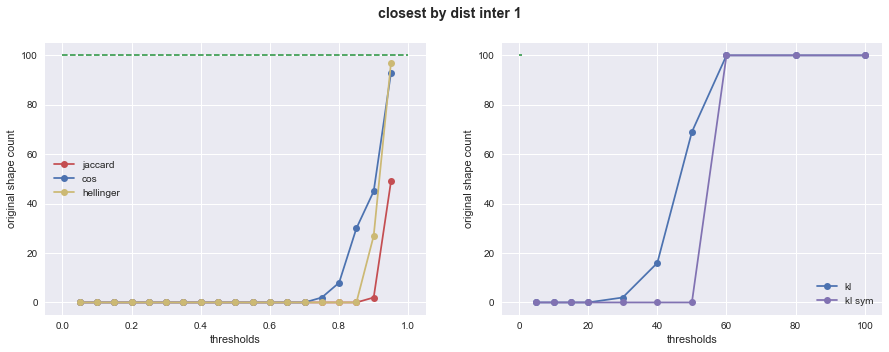

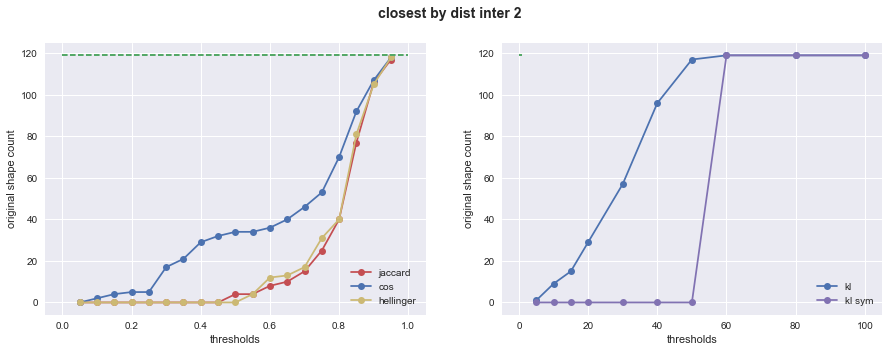

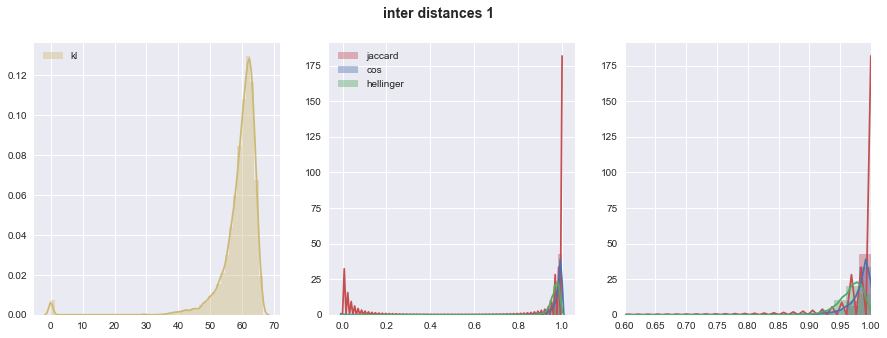

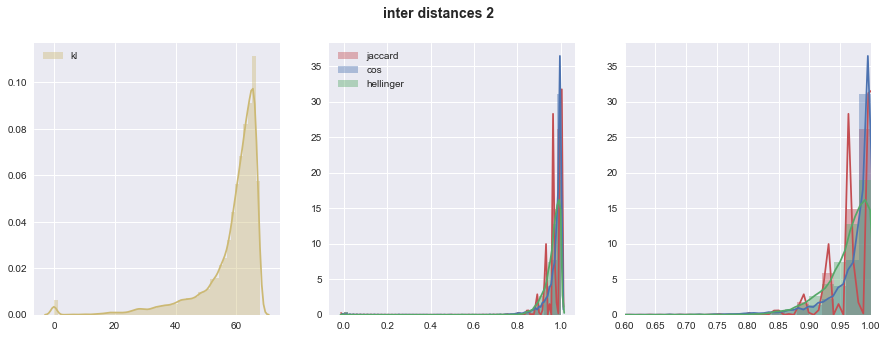

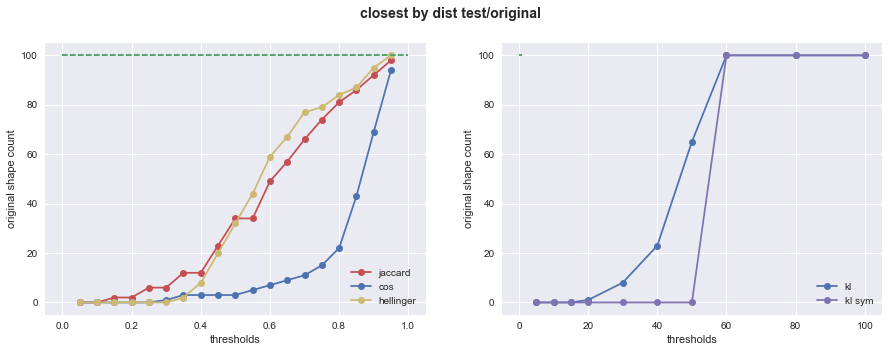

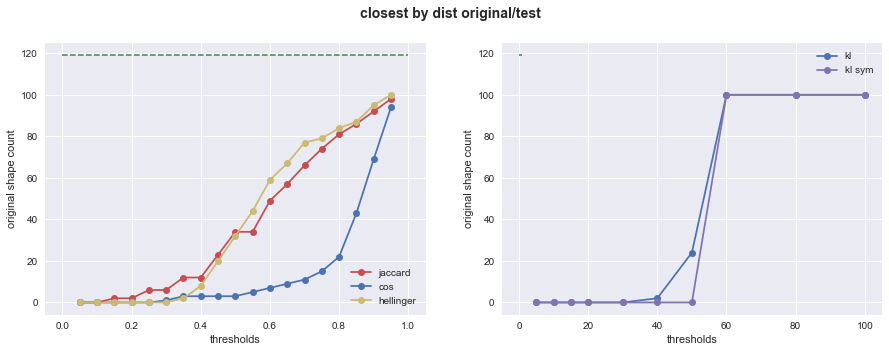

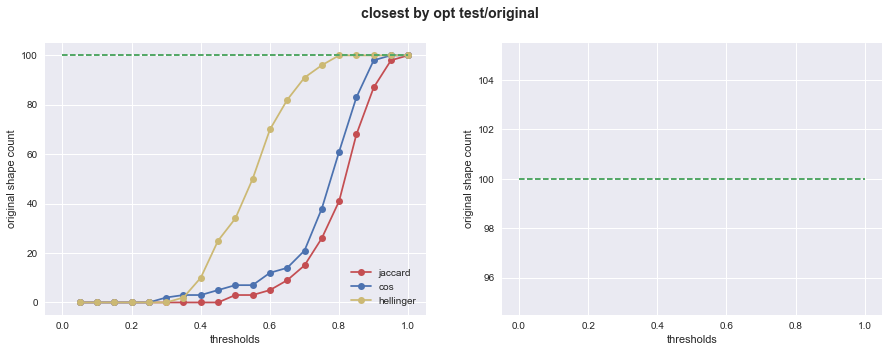

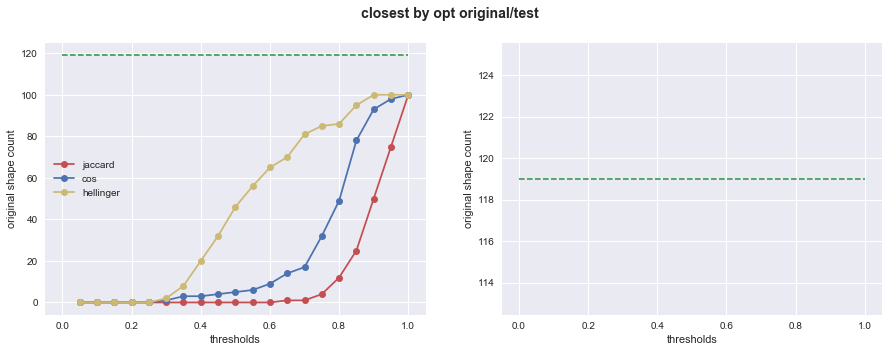

In [7]:
def create_model_rch_150_1(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 1.5
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 21
names_list[idx] = u'model_rch_150_1'
models_list[idx] = create_model_rch_150_1(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 119, 0.98
* **kernel size**: 24 vs 10, **purity**: .63 vs .57, **contrast** .78 vs .73, **$phi_{ij}$**: --+-- 
* **closest by dist**: более близкие
* **inter distances**: похожи

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|  < h5	|j12-h10|j50-h60|    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|  0  	|  h10 	| h70  	| h100 	|
| closest by opt res original/test 	|  - 	|   - 	|  -	| h90  	||
* **Выводы**: 
* **TODO**: 


побольше декоррелятор + fit model сначала

name = model_rch_150_2_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_150_2_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 3
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 144, [u'topic_0', u'topic_1', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'to

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   144.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2166.01
|phi_ij > 0.2| / n_topics         0.23     0.43
|phi_ij > 0.1| / n_topics         0.89     1.52
|phi_ij > 0.01| / n_topics       27.16    22.75
|phi_ij > 0.05| / n_topics        2.63     4.68
|phi_ij > 0.001| / n_topics      80.26    46.51
topic_kernel_average_size        23.68    15.21
topic_kernel_average_purity       0.63     0.51
topic_kernel_average_contrast     0.78     0.74

Dist fn = <function kl_sym_dist at 0x000000000C181978>, Processed th = 100, original columns count = 144        Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Dist fn = <function cos_dist at 0x000000000C181AC8>, Processed th = 1.0, original columns count = 100           Column topic_24 not optimized
Column topic_28 not optimized
Column topic_32 not optimized
Column topic_35 not optimized
Column topic_41 not optimized
Column topic_53 not optimized
Column topic_54 not optimized
Column topic

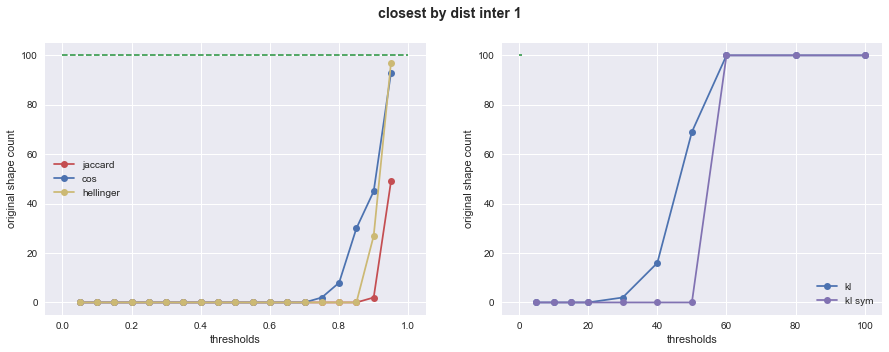

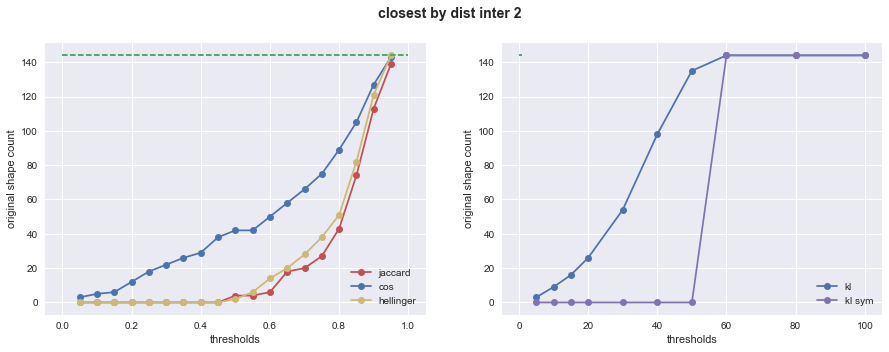

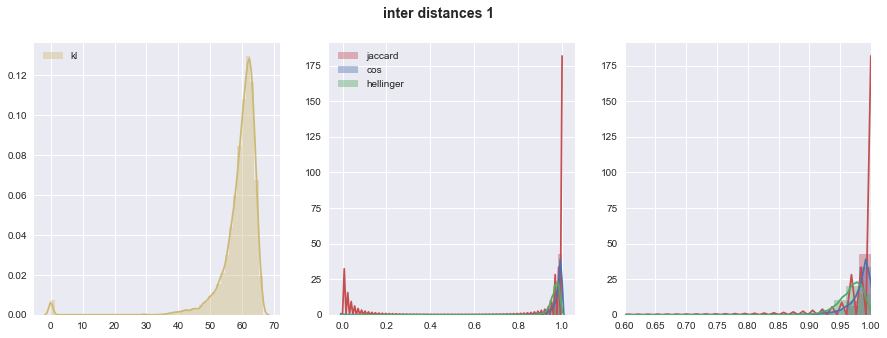

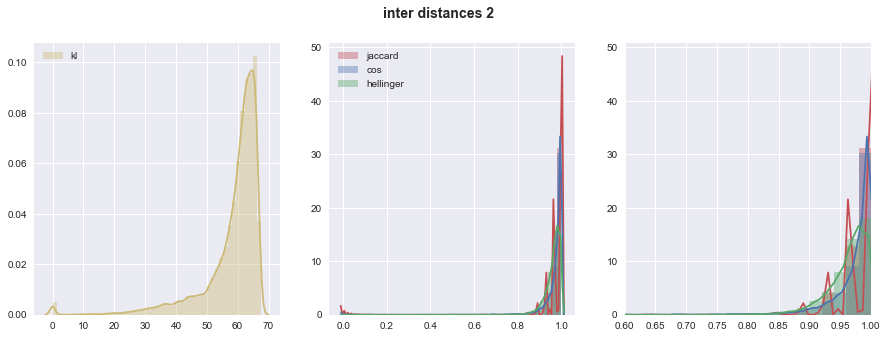

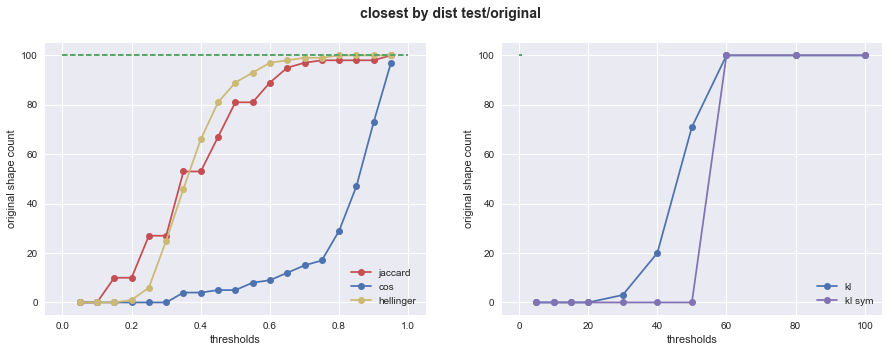

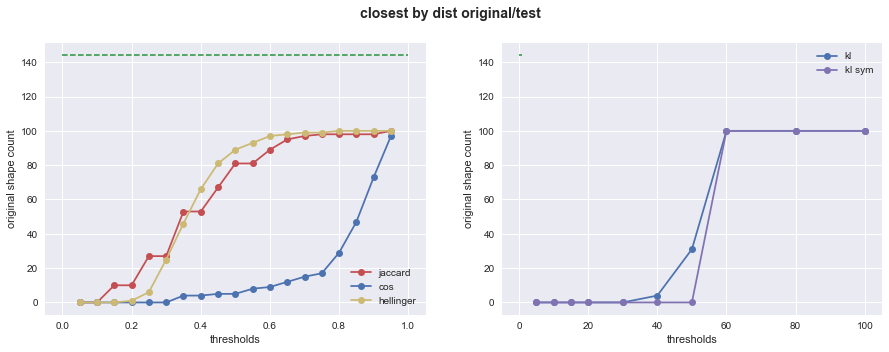

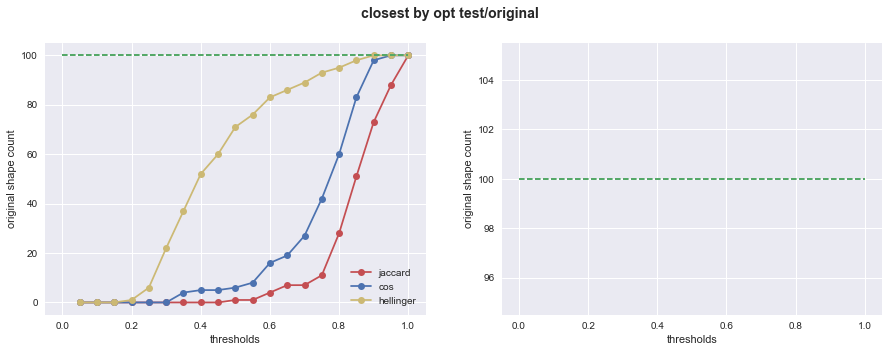

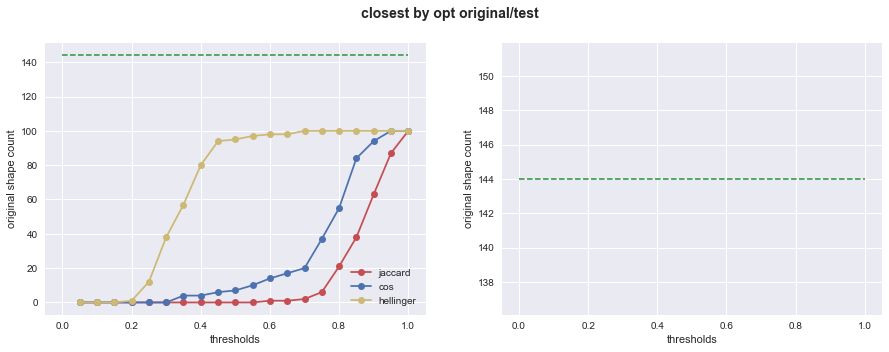

In [8]:
def create_model_rch_150_2(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 3
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 22
names_list[idx] = u'model_rch_150_2'
models_list[idx] = create_model_rch_150_2(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 144, 0.98
* **kernel size**: 24 vs 15, **purity**: .63 vs .51, **contrast** .78 vs .74, **$phi_{ij}$**: --+-- 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|  < j10|j55-h65|j90-h98|    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|  0  	|  h50 	| h82  	| h95 	|
| closest by opt res original/test 	|  - 	|  h80 	|  h100	|   	||
* **Выводы**: 
* **TODO**: 

Попробуем ещё больше декоррелятор сделать.

name = model_rch_150_3_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_150_3_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 144, [u'topic_0', u'topic_1', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'to

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   144.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2166.02
|phi_ij > 0.2| / n_topics         0.23     0.42
|phi_ij > 0.1| / n_topics         0.89     1.51
|phi_ij > 0.01| / n_topics       27.16    22.71
|phi_ij > 0.05| / n_topics        2.63     4.71
|phi_ij > 0.001| / n_topics      80.26    46.53
topic_kernel_average_size        23.68    15.20
topic_kernel_average_purity       0.63     0.51
topic_kernel_average_contrast     0.78     0.74

Dist fn = <function kl_sym_dist at 0x000000000C181978>, Processed th = 100, original columns count = 144        Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Dist fn = <function cos_dist at 0x000000000C181AC8>, Processed th = 1.0, original columns count = 100           Column topic_4 not optimized
Column topic_16 not optimized
Column topic_24 not optimized
Column topic_45 not optimized
Column topic_53 not optimized
Column topic_84 not optimized
Column topic_104 not optimized
Column topic

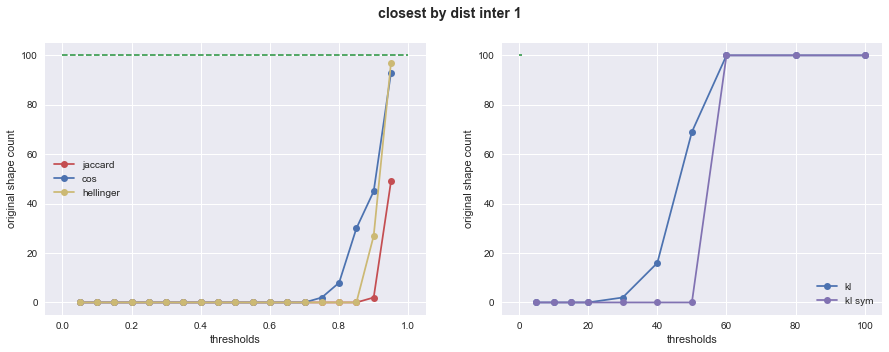

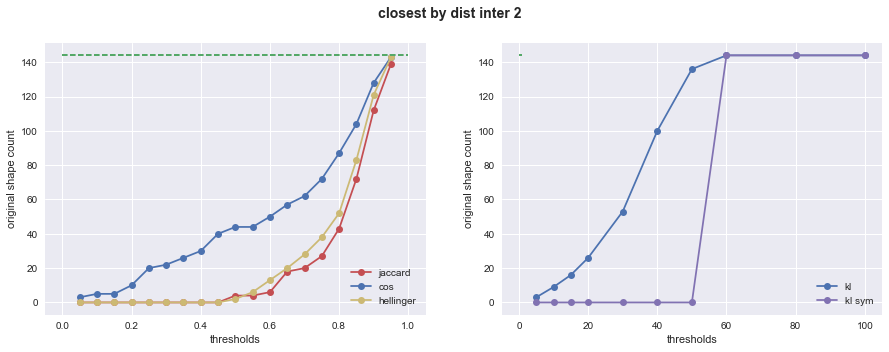

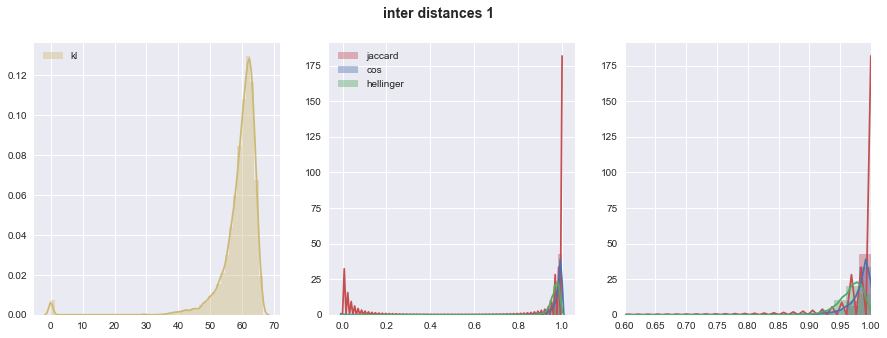

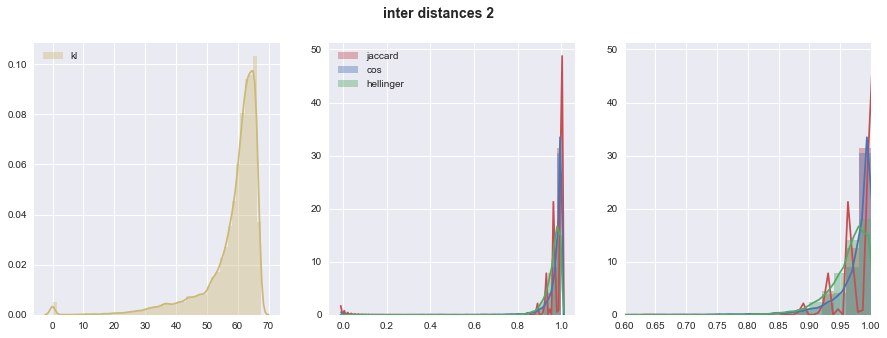

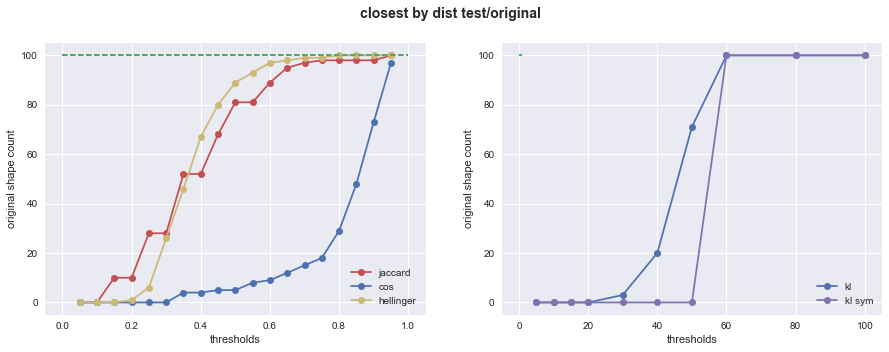

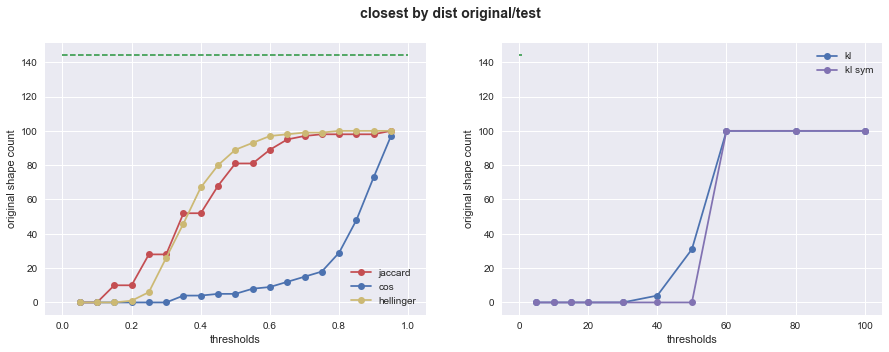

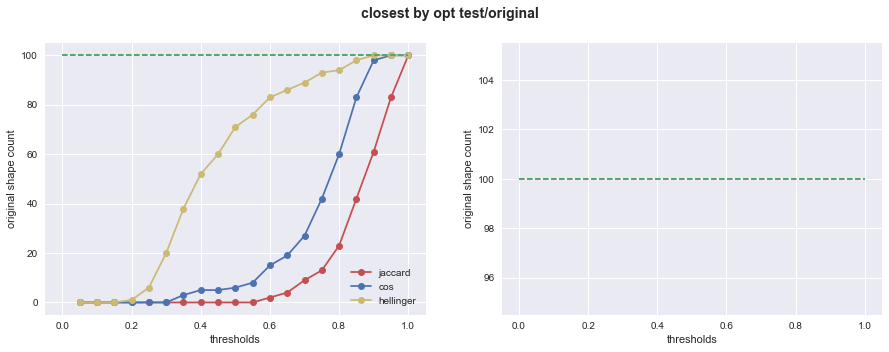

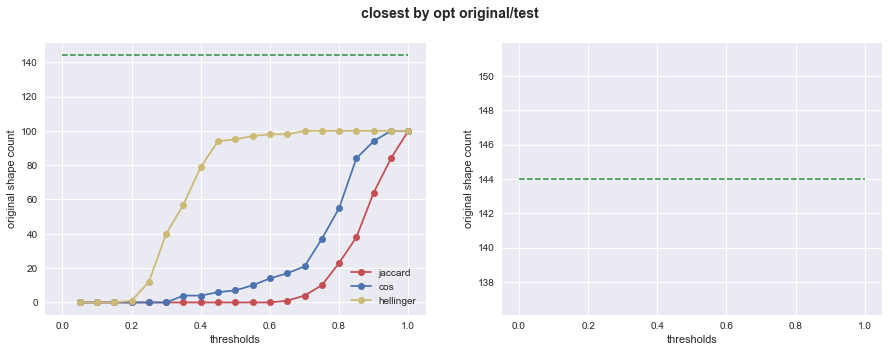

In [9]:
def create_model_rch_150_3(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 23
names_list[idx] = u'model_rch_150_3'
models_list[idx] = create_model_rch_150_3(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 144, 0.98
* **kernel size**: 24 vs 15, **purity**: .63 vs .51, **contrast** .78 vs .74, **$phi_{ij}$**: --+-- 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|  j10  |j55-h65|j90-h98|    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|  0  	|  h52 	| h82  	| h95 	|
| closest by opt res original/test 	|  - 	|  h80 	|  h100	|   	||
* **Выводы**: 
* **TODO**: 

Попробуем убрать обучение сначала.

name = model_rch_150_4_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -1.5

('Filtered topics: ', 119, [u'topic_1', u'topic_5', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_17', u'topic_20', u'topic_21', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_35', u'topic_36', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_43', u'topic_44', u'topic_45', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_57', u'topic_58', u'topic_59', u'topic_60', u'topic_61', u'topic_63', u'topic_64', u'topic_65', u'topic_66', u'topic_68', u'topic_69', u'topic_70', u'topic_71', u'topic_

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   119.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2173.87
|phi_ij > 0.2| / n_topics         0.23     0.54
|phi_ij > 0.1| / n_topics         0.89     1.87
|phi_ij > 0.01| / n_topics       27.16    20.24
|phi_ij > 0.05| / n_topics        2.63     4.91
|phi_ij > 0.001| / n_topics      80.26    39.36
topic_kernel_average_size        23.68     9.94
topic_kernel_average_purity       0.63     0.57
topic_kernel_average_contrast     0.78     0.73

Dist fn = <function kl_sym_dist at 0x000000000C181978>, Processed th = 100, original columns count = 119        Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Dist fn = <function cos_dist at 0x000000000C181AC8>, Processed th = 1.0, original columns count = 100           Column topic_49 not optimized
Column topic_64 not optimized
Column topic_91 not optimized
Column topic_101 not optimized
Column topic_108 not optimized
Column topic_136 not optimized
Dist fn = <function cos_dist at 0x00000

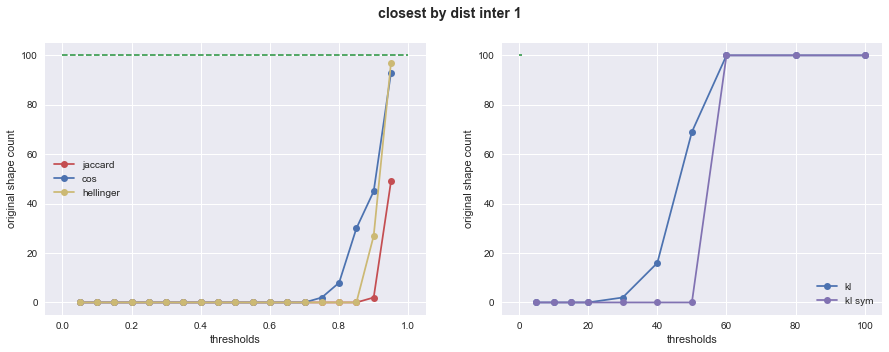

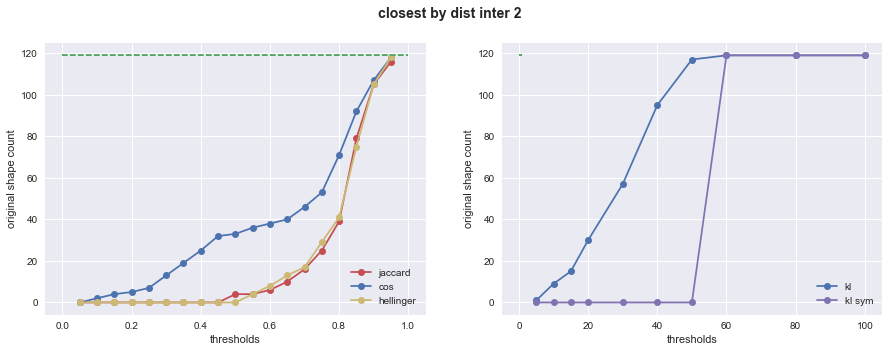

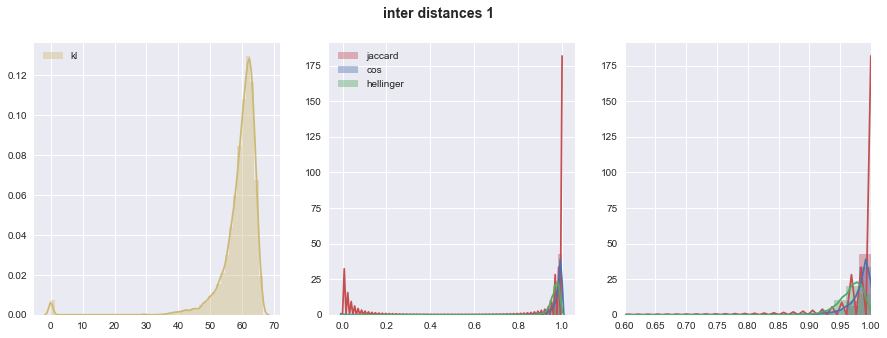

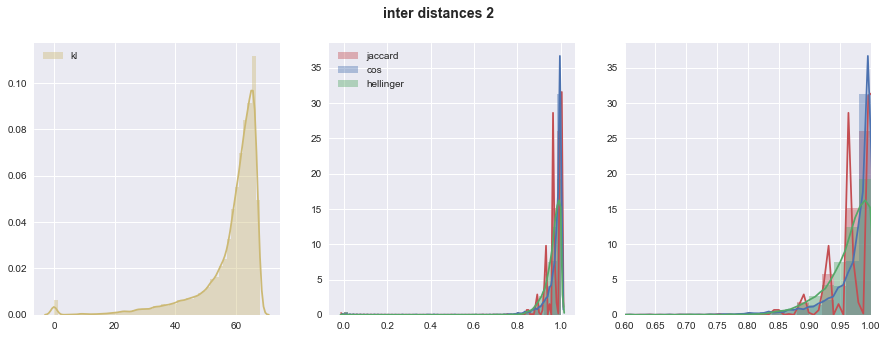

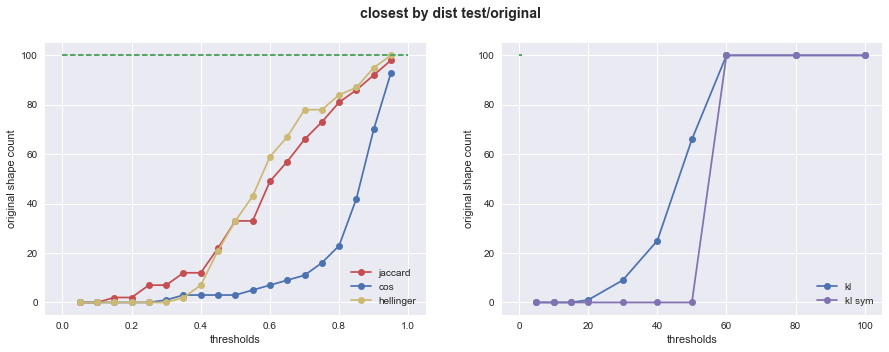

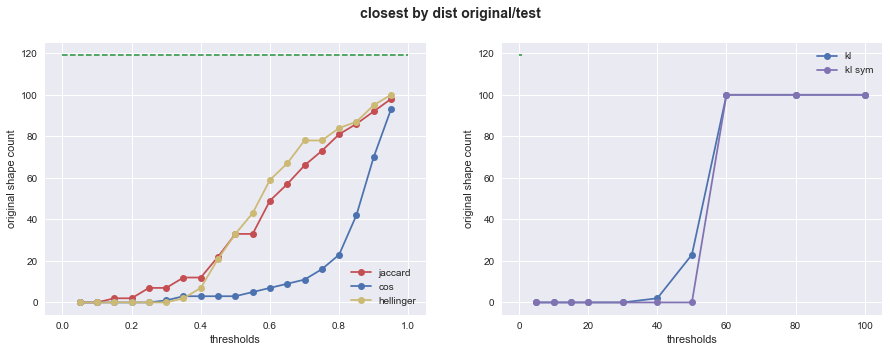

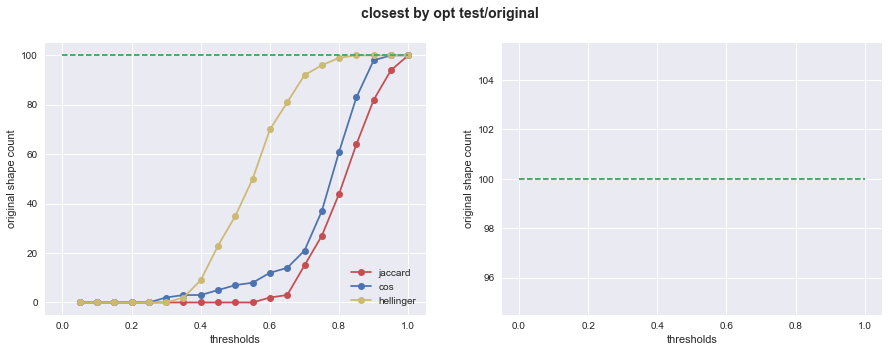

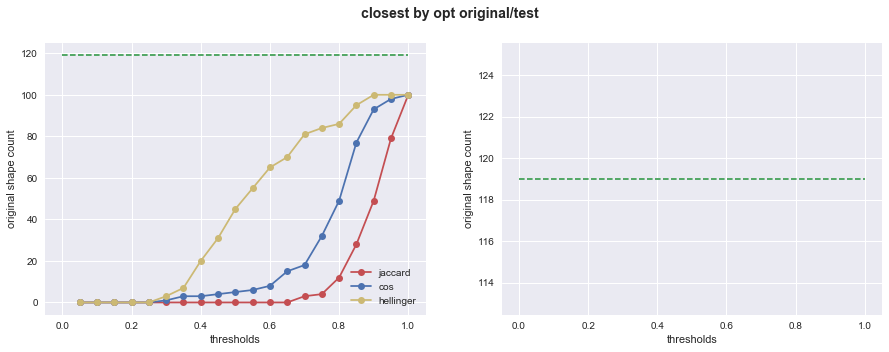

In [10]:
def create_model_rch_150_4(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 24
names_list[idx] = u'model_rch_150_4'
models_list[idx] = create_model_rch_150_4(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 119, 0.98
* **kernel size**: 24 vs 10, **purity**: .63 vs .57, **contrast** .78 vs .73, **$phi_{ij}$**: --+-- 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|  j10  |j55-h65|j90-h98|    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|  0  	|  h10 	|  h60 	| h83 	|
| closest by opt res original/test 	|  - 	|  h10 	|  h60	| h80  	||
* **Выводы**: хуже, чем предыдущие
* **TODO**: 

## topic selection only
Без обучения в начале, коэф маленький (0.1)

name = model_rch_150_1_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
ss_phi_regularizer, tau = -1.5
topic_selection_theta_regularizer, tau = 0.1

('Filtered topics: ', 116, [u'topic_1', u'topic_2', u'topic_4', u'topic_5', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_12', u'topic_13', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_21', u'topic_23', u'topic_24', u'topic_25', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_35', u'topic_36', u'topic_37', u'topic_39', u'topic_40', u'topic_41', u'topic_43', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_58', u'topic_59', u'topic_60', u'topic_61', u'topic_62', u'topic_63', u'topic_64', u'topic_66', u'topic_68', u'topic_69', u'topic_70', u'topic_71', u'topic_72', u'topic_73', 

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   116.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2172.45
|phi_ij > 0.2| / n_topics         0.23     0.57
|phi_ij > 0.1| / n_topics         0.89     2.00
|phi_ij > 0.01| / n_topics       27.16    19.35
|phi_ij > 0.05| / n_topics        2.63     4.82
|phi_ij > 0.001| / n_topics      80.26    40.14
topic_kernel_average_size        23.68     9.05
topic_kernel_average_purity       0.63     0.55
topic_kernel_average_contrast     0.78     0.74

Dist fn = <function kl_sym_dist at 0x000000000C181978>, Processed th = 100, original columns count = 116        Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Dist fn = <function cos_dist at 0x000000000C181AC8>, Processed th = 1.0, original columns count = 100           Column topic_12 not optimized
Column topic_36 not optimized
Column topic_84 not optimized
Column topic_108 not optimized
Column topic_125 not optimized
Dist fn = <function cos_dist at 0x000000000C181AC8>, Processed th = 1.

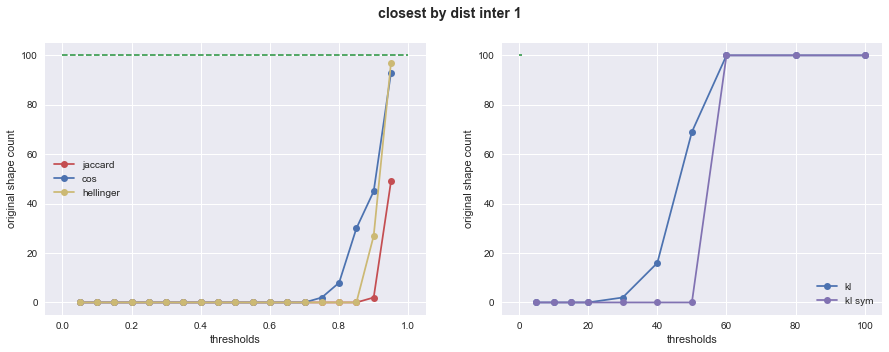

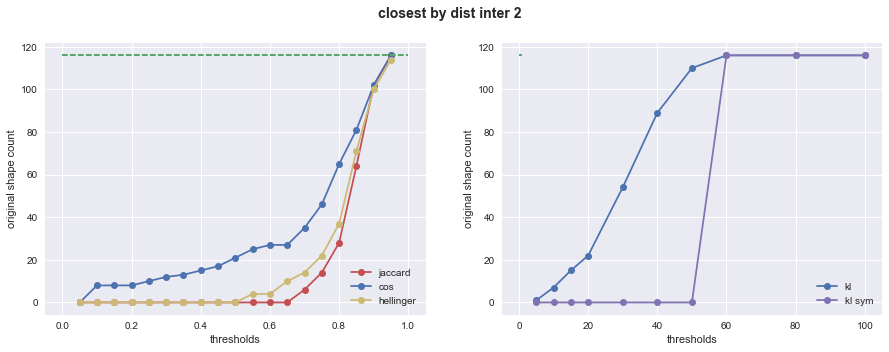

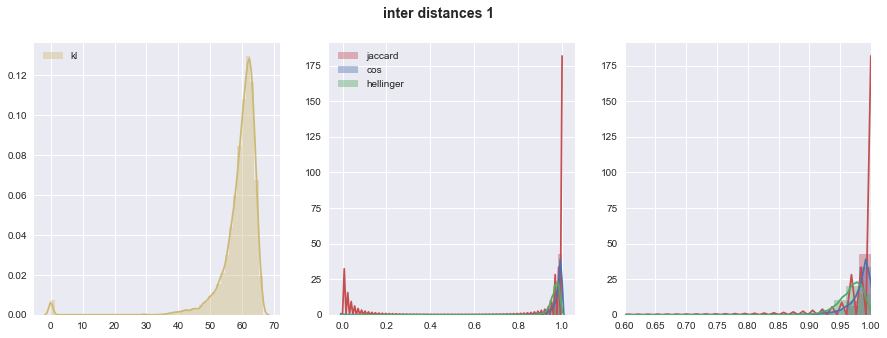

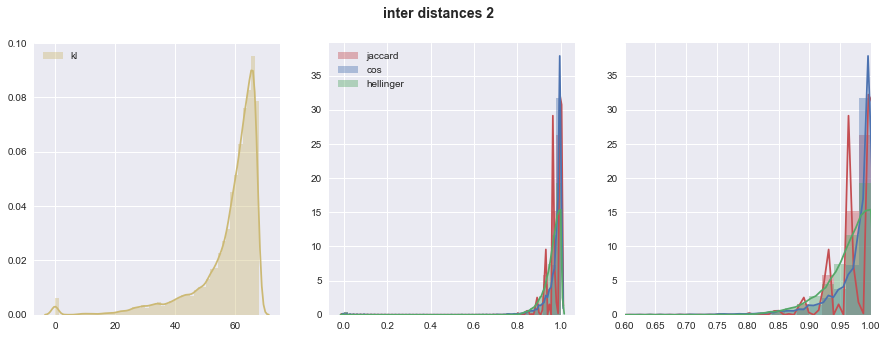

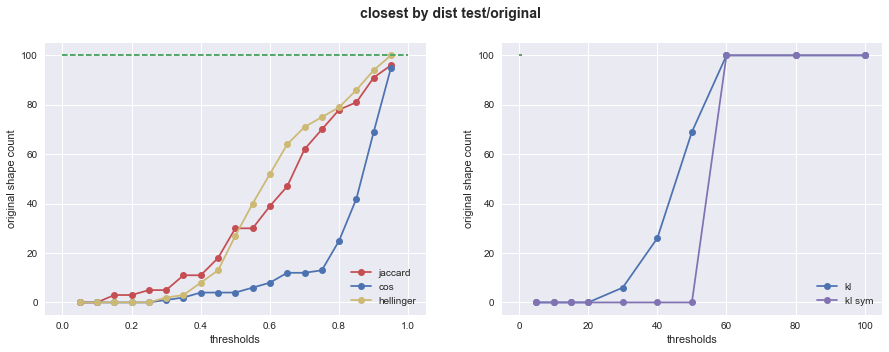

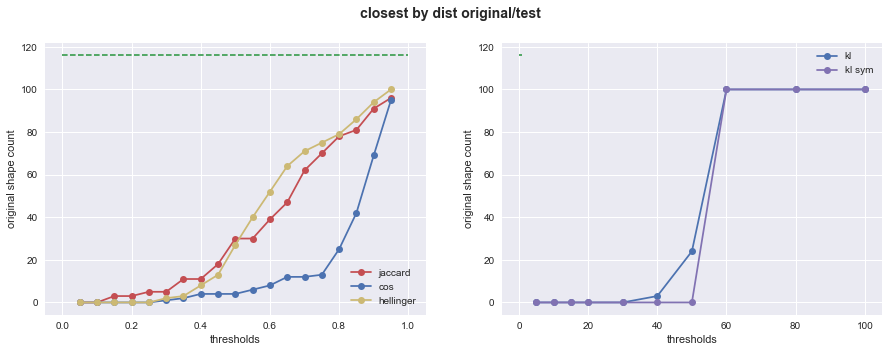

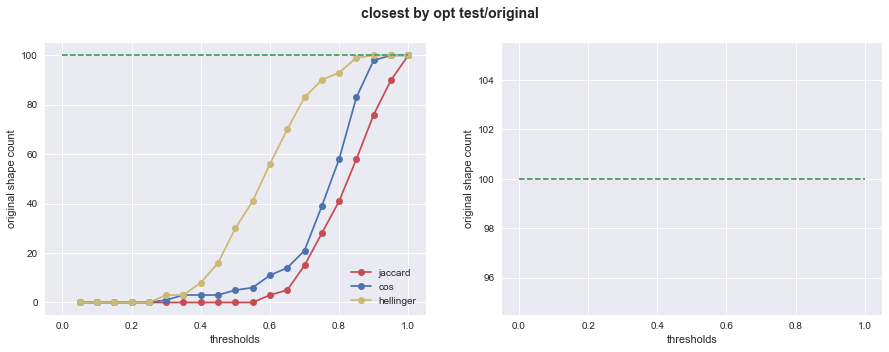

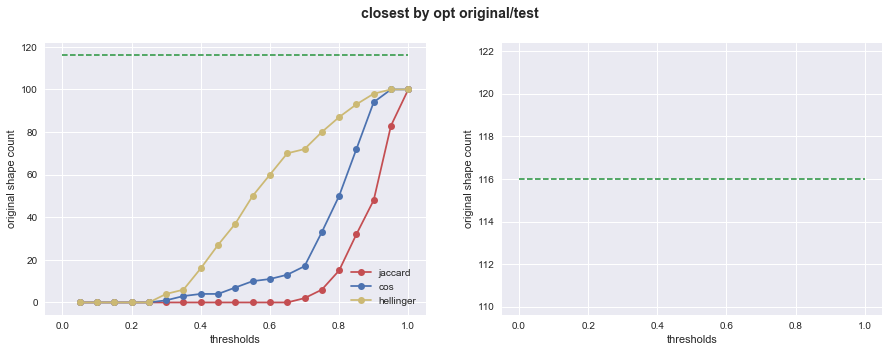

In [11]:
def create_model_rch_150_1_ts(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.1
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 31
names_list[idx] = u'model_rch_150_1_ts'
models_list[idx] = create_model_rch_150_1_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 116
* **kernel size**: 24 vs 9, **purity**: .63 vs .55, **contrast** .78 vs .74, **$phi_{ij}$**:  --+--
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|  j4   |j12-h10|j40-h52|  80  	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|  0  	|  h10 	| h58  	| h92 	|
| closest by opt res original/test 	|  - 	|  h18 	| h60	| h90  	||
* **Выводы**: 
* **TODO**: 

Увеличим коэф (с 0 0.1 до 0.5) + начальное обучение без регуляризаторов.

name = model_rch_150_2_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_150_2_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
ss_phi_regularizer, tau = -1.5
topic_selection_theta_regularizer, tau = 0.5

('Filtered topics: ', 129, [u'topic_0', u'topic_3', u'topic_4', u'topic_5', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   129.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       2126.43  2146.88
|phi_ij > 0.2| / n_topics         0.23     0.36
|phi_ij > 0.1| / n_topics         0.89     1.14
|phi_ij > 0.01| / n_topics       27.16    24.60
|phi_ij > 0.05| / n_topics        2.63     3.74
|phi_ij > 0.001| / n_topics      80.26    61.74
topic_kernel_average_size        23.68    16.81
topic_kernel_average_purity       0.63     0.48
topic_kernel_average_contrast     0.78     0.74

Dist fn = <function kl_sym_dist at 0x000000000C181978>, Processed th = 100, original columns count = 129        Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Dist fn = <function cos_dist at 0x000000000C181AC8>, Processed th = 1.0, original columns count = 100           Column topic_8 not optimized
Column topic_24 not optimized
Column topic_26 not optimized
Column topic_27 not optimized
Column topic_32 not optimized
Column topic_33 not optimized
Column topic_41 not optimized
Column topic_

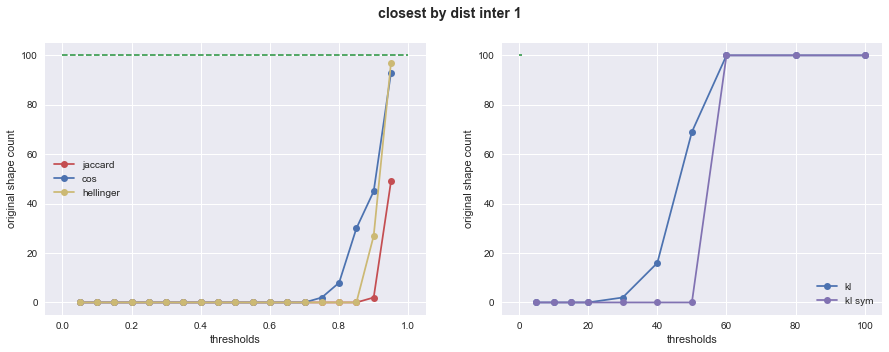

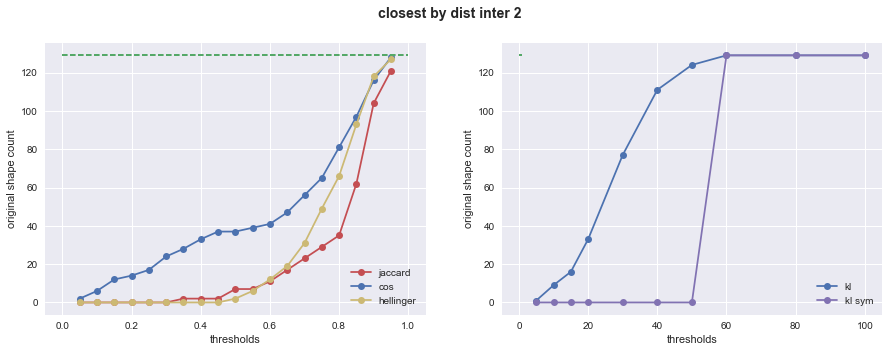

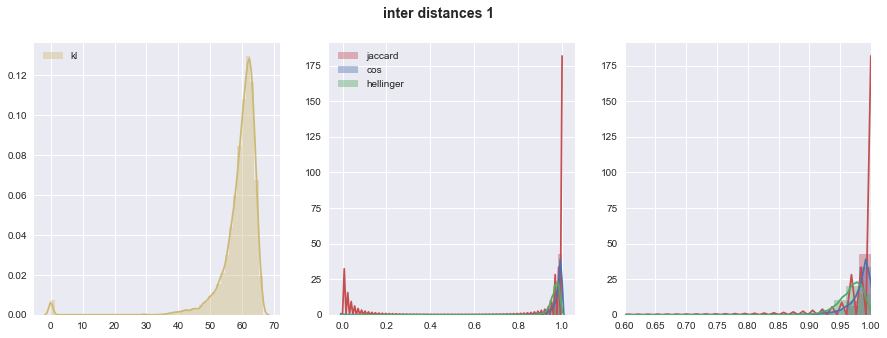

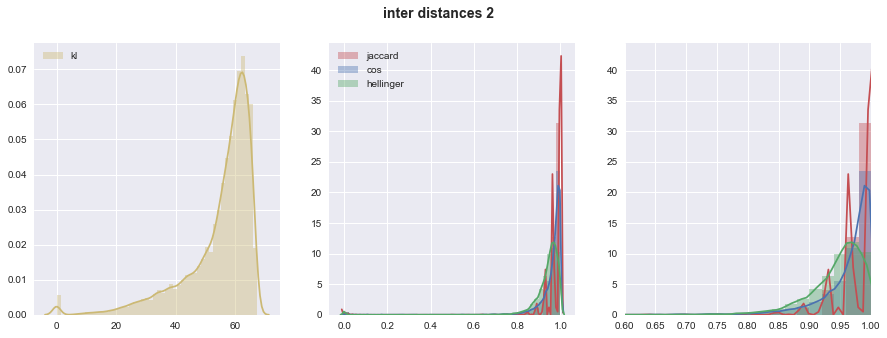

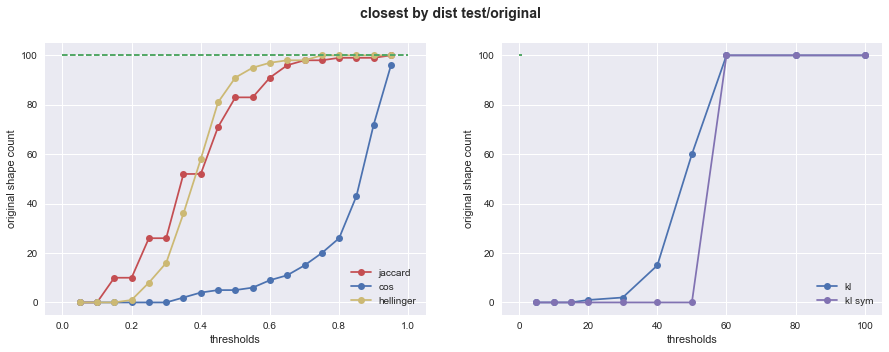

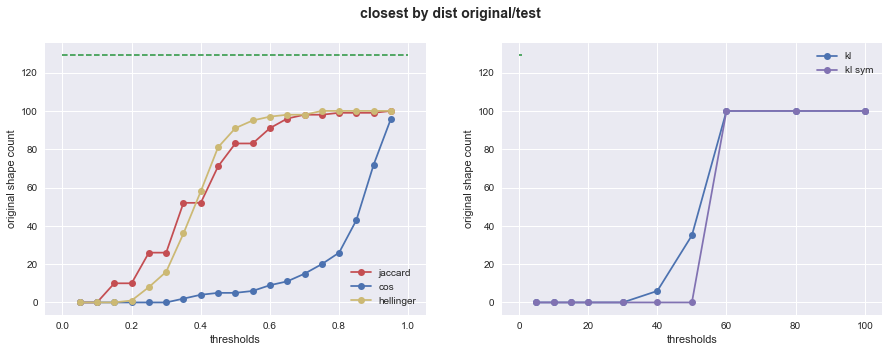

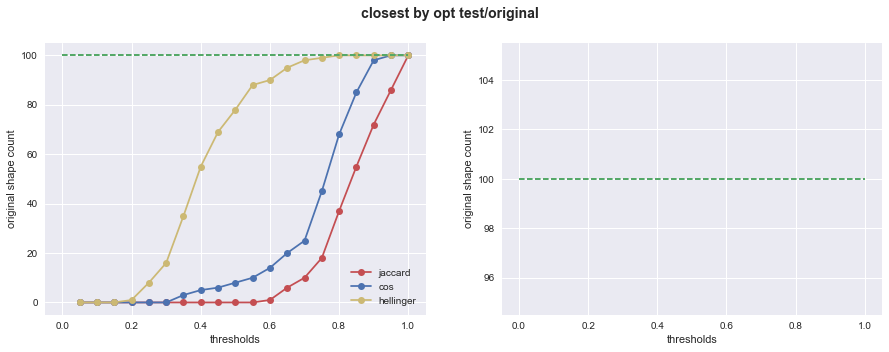

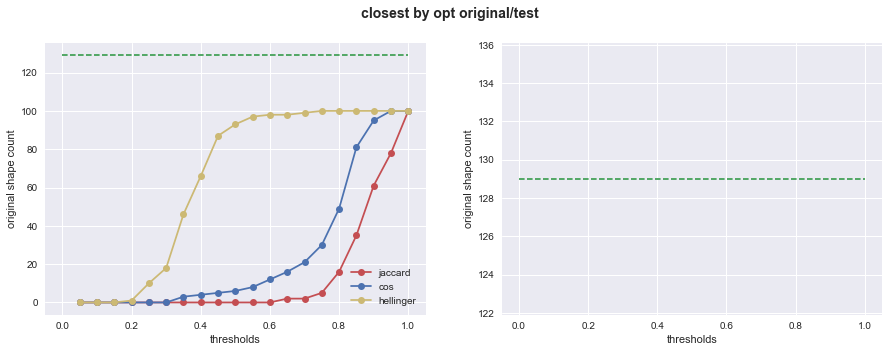

In [12]:
def create_model_rch_150_2_ts(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.5
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 32
names_list[idx] = u'model_rch_150_2_ts'
models_list[idx] = create_model_rch_150_2_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 129, 0.97
* **kernel size**: 24 vs 17, **purity**: .63 vs .48, **contrast** .78 vs .74, **$phi_{ij}$**:  +++++
* **closest by dist**: темы ближе, чем оригинальные (порог 0.6 - 15 тем)
* **inter distances**: более размазаные, но далекие друг от друга

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|  j10  |j53-h60|j90-h98|    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|  0  	|  h55 	| h90  	| h100 	|
| closest by opt res original/test 	|  - 	|  h65 	|  h100	|   	||
* **Выводы**: 
* **TODO**: 

Увеличить спарсе коэффициенты (от -1.5 до -2)

name = model_rch_150_3_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_150_3_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -2
ss_phi_regularizer, tau = -2
topic_selection_theta_regularizer, tau = 0.5

('Filtered topics: ', 123, [u'topic_0', u'topic_3', u'topic_4', u'topic_5', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_53', u'topic_54', u'topic_55', u'topi

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   123.00
non zero ratio                    0.96     0.97
|phi_ij == 0| / n_topics       2126.43  2145.80
|phi_ij > 0.2| / n_topics         0.23     0.37
|phi_ij > 0.1| / n_topics         0.89     1.13
|phi_ij > 0.01| / n_topics       27.16    24.61
|phi_ij > 0.05| / n_topics        2.63     3.69
|phi_ij > 0.001| / n_topics      80.26    62.44
topic_kernel_average_size        23.68    17.11
topic_kernel_average_purity       0.63     0.49
topic_kernel_average_contrast     0.78     0.76

Dist fn = <function kl_sym_dist at 0x000000000C181978>, Processed th = 100, original columns count = 123        Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Dist fn = <function cos_dist at 0x000000000C181AC8>, Processed th = 1.0, original columns count = 100           Column topic_24 not optimized
Column topic_26 not optimized
Column topic_28 not optimized
Column topic_41 not optimized
Column topic_43 not optimized
Column topic_45 not optimized
Column topic_65 not optimized
Column topic

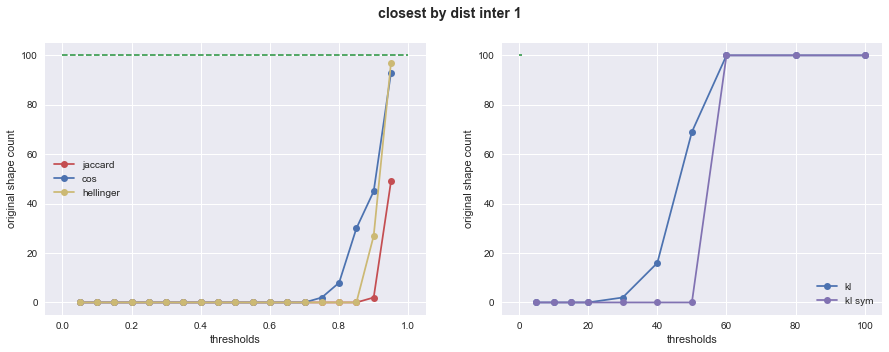

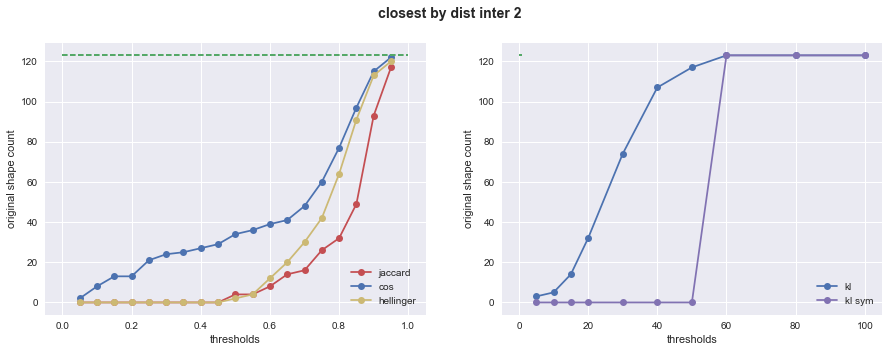

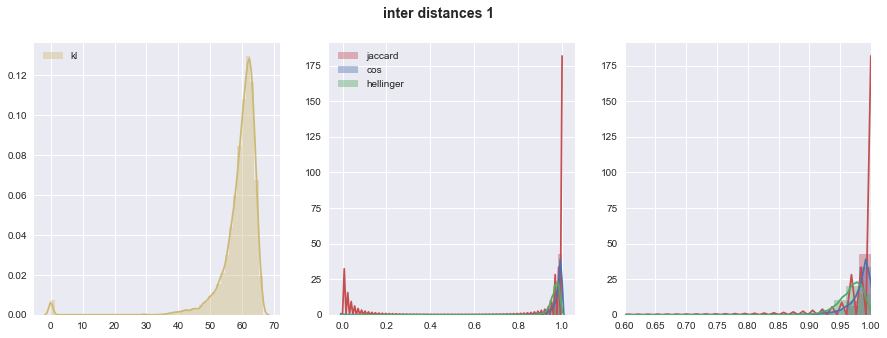

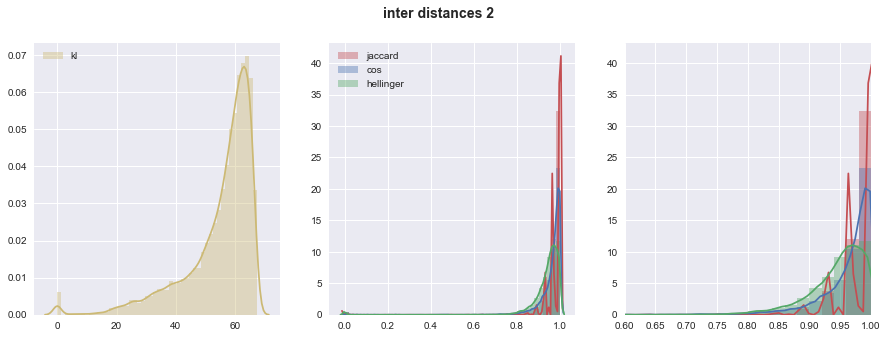

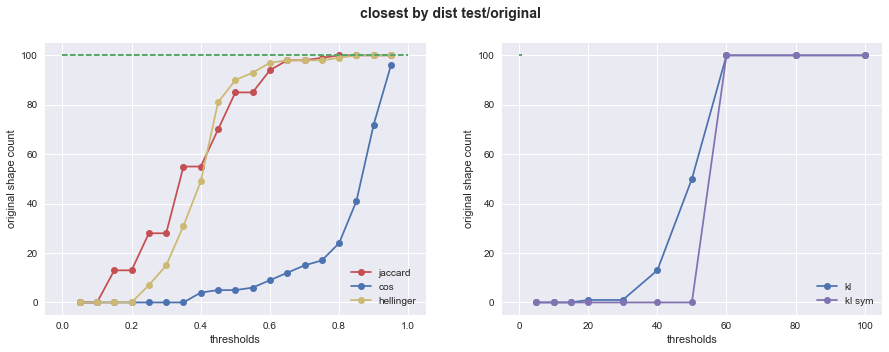

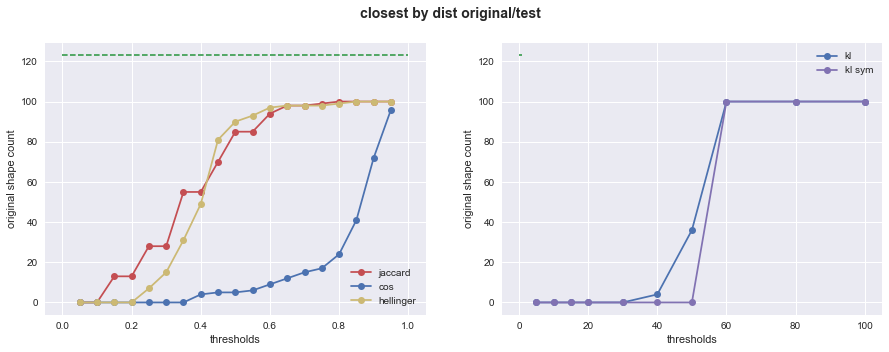

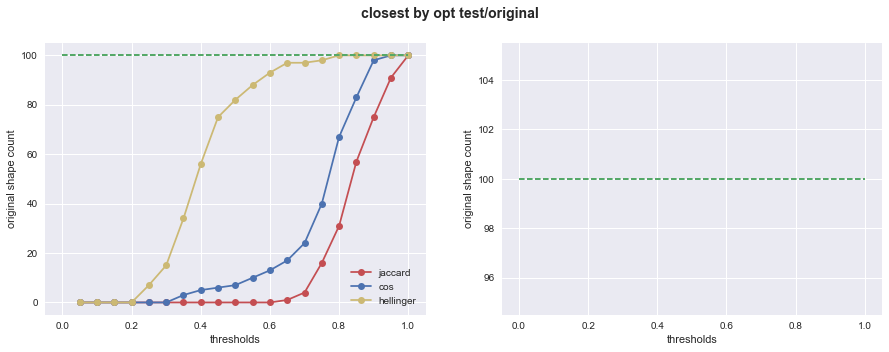

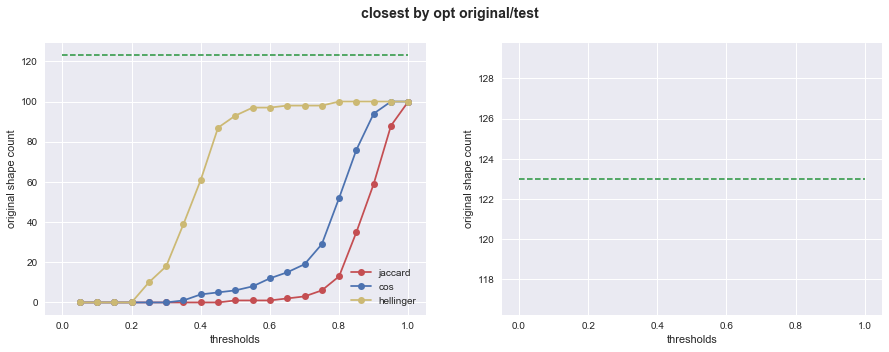

In [13]:
def create_model_rch_150_3_ts(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.5
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 33
names_list[idx] = u'model_rch_150_3_ts'
models_list[idx] = create_model_rch_150_3_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 123, 0.97
* **kernel size**: 24 vs 17, **purity**: .63 vs .49, **contrast** .78 vs .76, **$phi_{ij}$**:  +++++
* **closest by dist**: -
* **inter distances**: -

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|  j15  |j55-h50|j90-h98|    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|  0  	|  h55 	| h90  	| h100 	|
| closest by opt res original/test 	|  - 	|  h60 	|  h98	|   	||
* **Выводы**: 
* **TODO**: 

Увеличим коэффициент отбора тем от 0.5 до 0.7

name = model_rch_150_4_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = model_rch_150_4_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -2
ss_phi_regularizer, tau = -2
topic_selection_theta_regularizer, tau = 0.7

('Filtered topics: ', 112, [u'topic_0', u'topic_4', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_58', u'topic_59', u'to

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   112.00
non zero ratio                    0.96     0.96
|phi_ij == 0| / n_topics       2126.43  2132.85
|phi_ij > 0.2| / n_topics         0.23     0.29
|phi_ij > 0.1| / n_topics         0.89     1.02
|phi_ij > 0.01| / n_topics       27.16    25.25
|phi_ij > 0.05| / n_topics        2.63     3.30
|phi_ij > 0.001| / n_topics      80.26    72.07
topic_kernel_average_size        23.68    18.77
topic_kernel_average_purity       0.63     0.50
topic_kernel_average_contrast     0.78     0.79

Dist fn = <function kl_sym_dist at 0x000000000C181978>, Processed th = 100, original columns count = 112        Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Dist fn = <function cos_dist at 0x000000000C181AC8>, Processed th = 1.0, original columns count = 100           Column topic_7 not optimized
Column topic_8 not optimized
Column topic_22 not optimized
Column topic_23 not optimized
Column topic_24 not optimized
Column topic_25 not optimized
Column topic_27 not optimized
Column topic_2

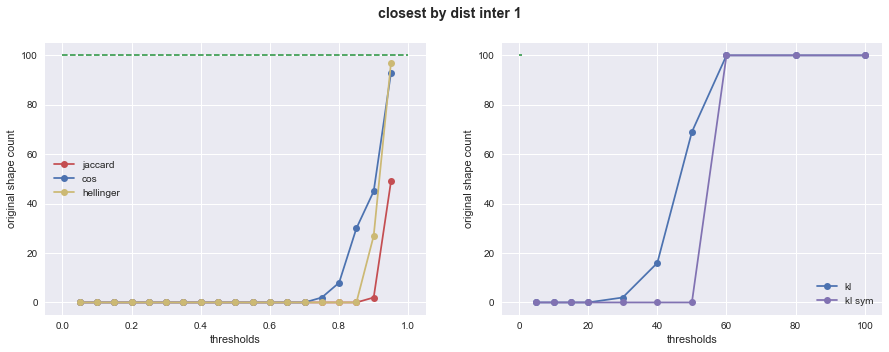

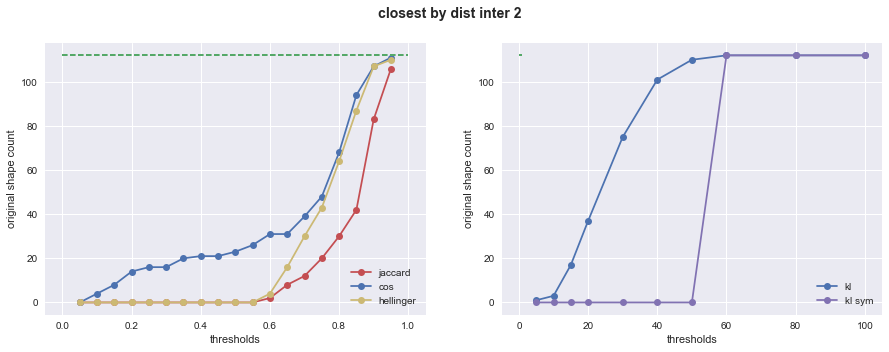

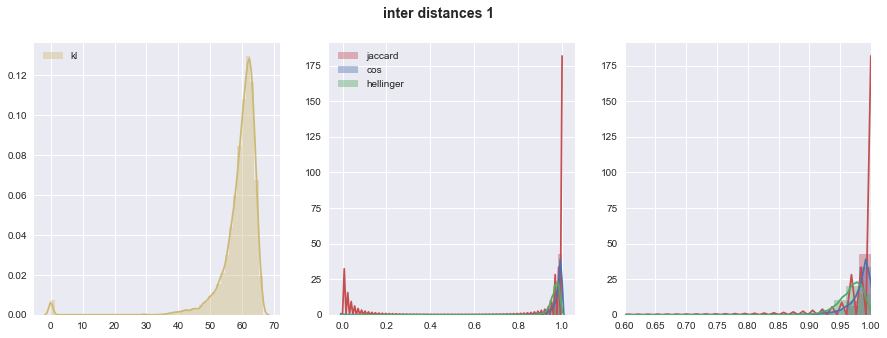

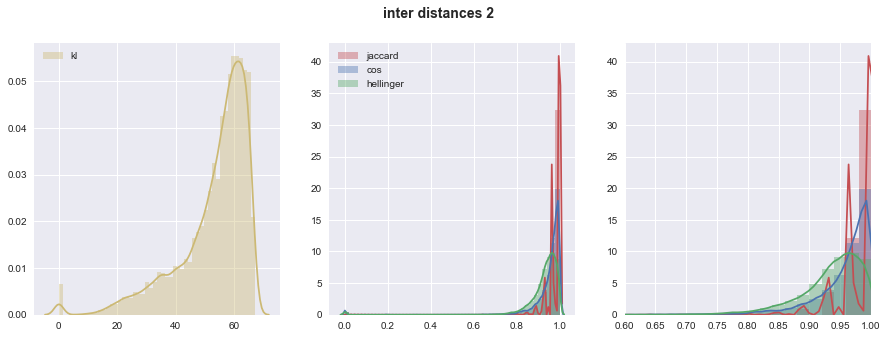

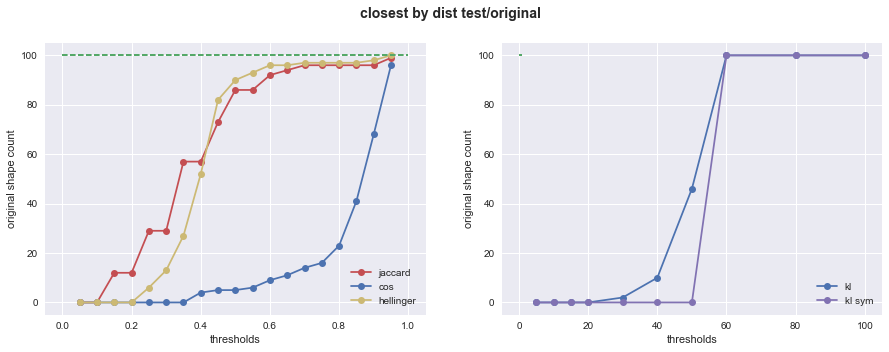

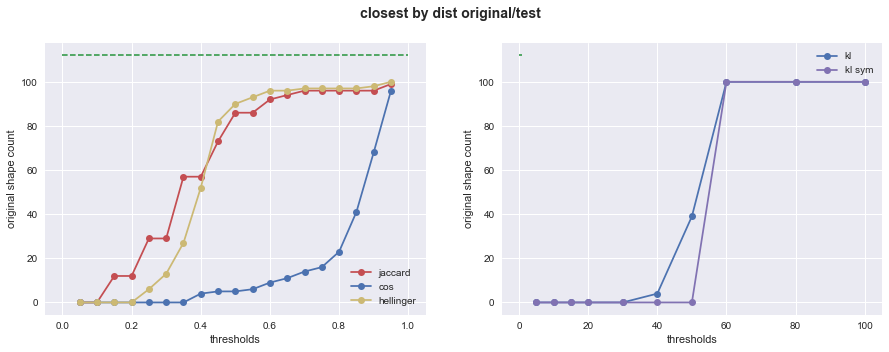

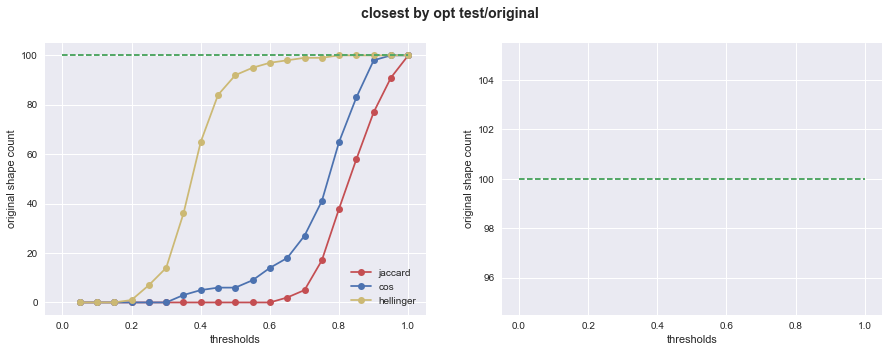

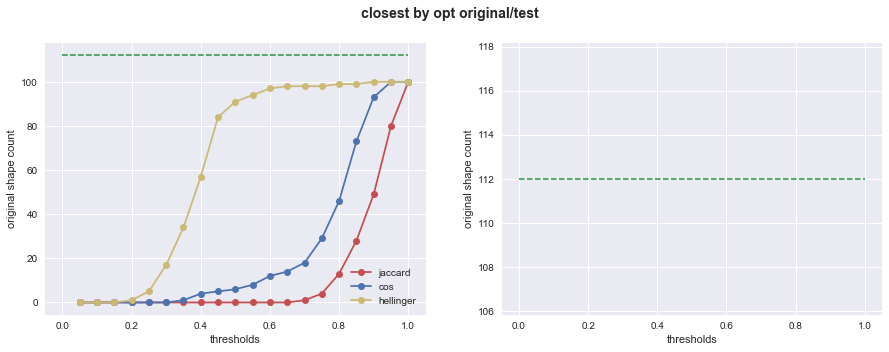

In [14]:
def create_model_rch_150_4_ts(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.7
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 34
names_list[idx] = u'model_rch_150_4_ts'
models_list[idx] = create_model_rch_150_4_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 112, 0.96
* **kernel size**: 24 vs 19, **purity**: .63 vs .50, **contrast** .78 vs .79, **$phi_{ij}$**: +++++ (closer)  
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|  j10  |j58-h55|j90-h98|    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|  0  	|  h65 	| h98  	| h100 	|
| closest by opt res original/test 	|  - 	|  h58 	|  h98	|   	||
* **Выводы**: 
* **TODO**: 

Без регуляризаторов

name = model_rch_150_5_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 135, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_16', u'topic_17', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_44', u'topic_45', u'topic_46', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_58', u'topic_59', u'topic_60', u'topic_61', u'topic_62', u'topic_63', u'topic_64', u'topic_65', u'topic_66', u'topic_68', u'topic_69', u'topic_70', u'topic_

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   135.00
non zero ratio                    0.96     0.85
|phi_ij == 0| / n_topics       2126.43  1872.59
|phi_ij > 0.2| / n_topics         0.23     0.56
|phi_ij > 0.1| / n_topics         0.89     1.57
|phi_ij > 0.01| / n_topics       27.16    20.70
|phi_ij > 0.05| / n_topics        2.63     4.11
|phi_ij > 0.001| / n_topics      80.26    49.02
topic_kernel_average_size        23.68    17.73
topic_kernel_average_purity       0.63     0.63
topic_kernel_average_contrast     0.78     0.74

Dist fn = <function kl_sym_dist at 0x000000000C181978>, Processed th = 100, original columns count = 135        Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Dist fn = <function cos_dist at 0x000000000C181AC8>, Processed th = 1.0, original columns count = 100           Column topic_6 not optimized
Column topic_15 not optimized
Column topic_17 not optimized
Column topic_32 not optimized
Column topic_51 not optimized
Column topic_57 not optimized
Column topic_70 not optimized
Dist fn = <fu

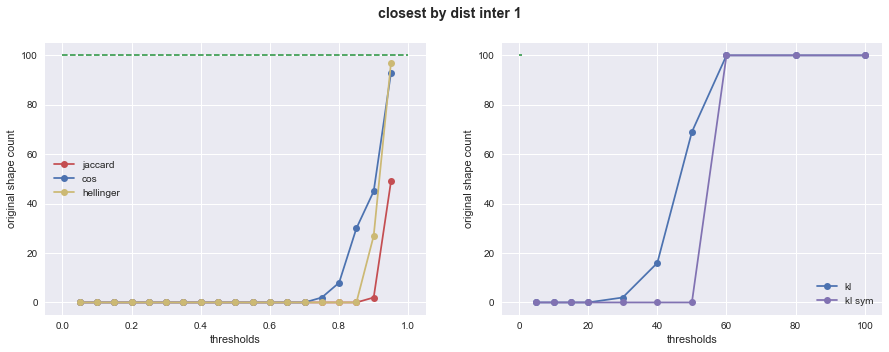

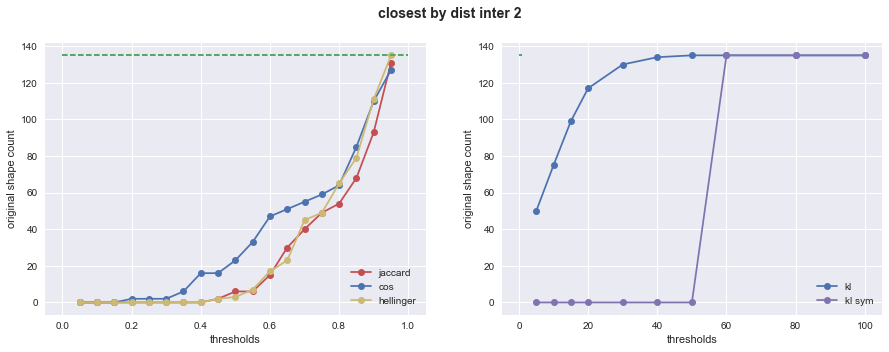

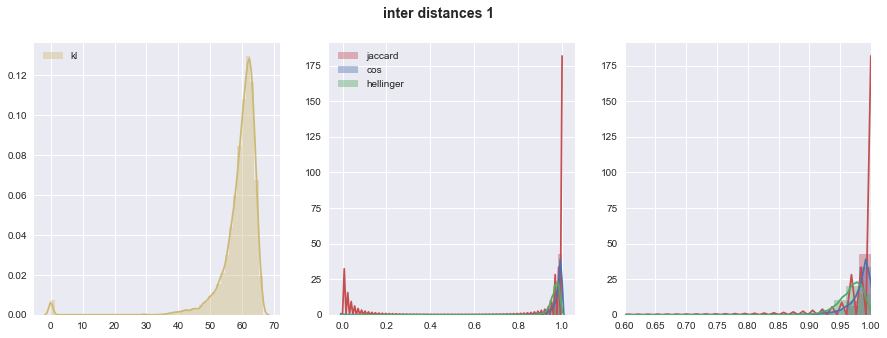

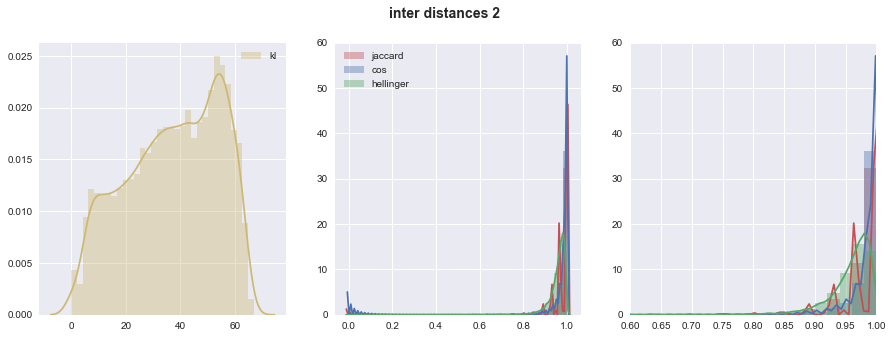

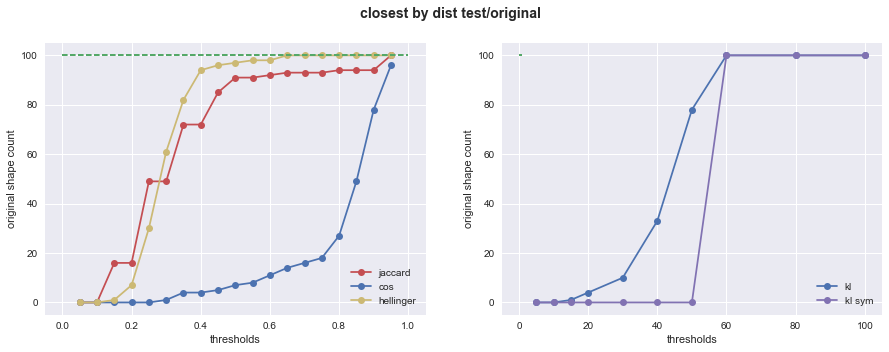

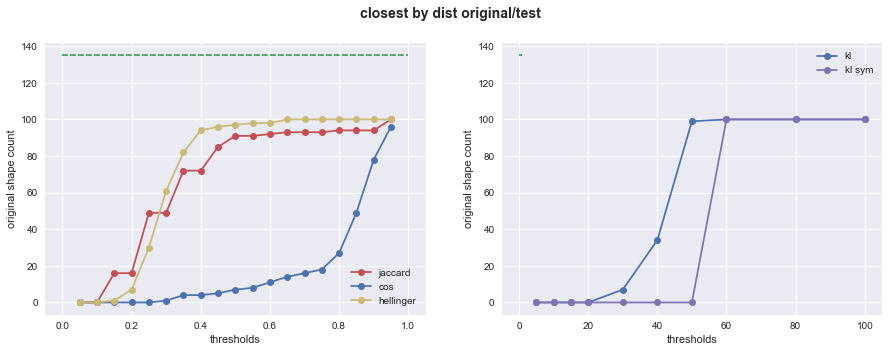

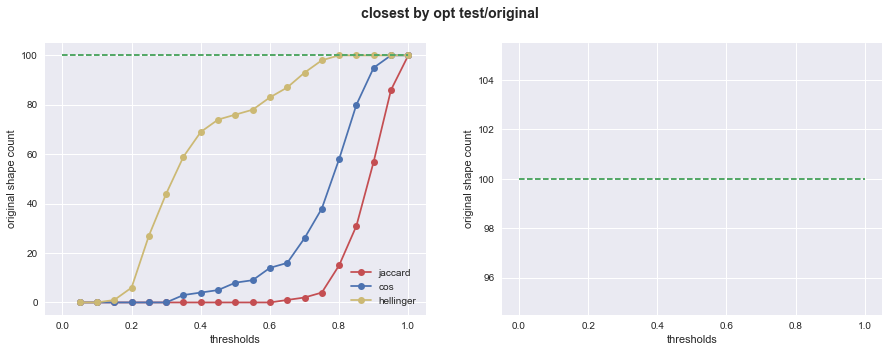

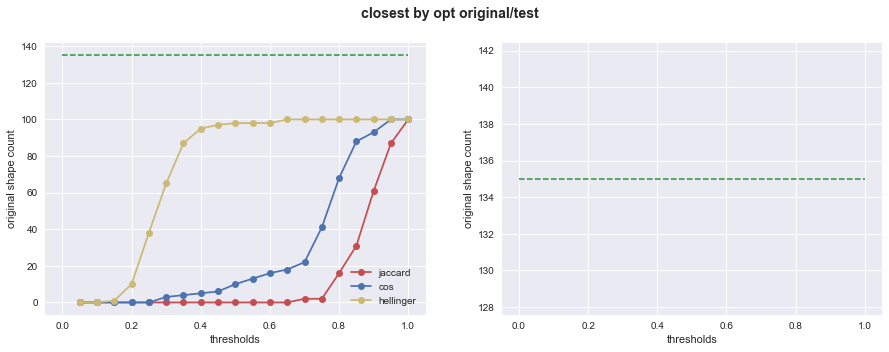

In [15]:
def create_model_rch_150_5_ts(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)   
    return tmp_model

idx = 35
names_list[idx] = u'model_rch_150_5_ts'
models_list[idx] = create_model_rch_150_5_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 135, 0.85
* **kernel size**: 24 vs 18, **purity**: .63 vs .63, **contrast** .78 vs .74, **$phi_{ij}$**: --+-- 
* **closest by dist**: колонки ближе, чем оригинальные (порог 0.6 - h20 колонок)
* **inter distances**: 


|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|h5-j18	|j70-h90|j90-h100|    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|  h5  	| h70  	| h82  	| h100 	|
| closest by opt res original/test 	|  h10 	|  h93 	| h97  	| h100 	||
* **Выводы**: При 0.4 находит 70 тем.
* **TODO**: 

## decorrelator + topic selection

name = create_model_rch_150_1_decor_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_150_1_decor_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 15, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -2
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -2

name = create_model_rch_150_1_decor_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -0.5
topic_selection_theta_regularizer, tau = 0.7
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = -0.5

('Filtered topics: ', 131, [u'topic_0', u'topic_1', u'topic_3', u'topic_4', u'topic_5', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_21'

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   131.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2173.11
|phi_ij > 0.2| / n_topics         0.23     0.47
|phi_ij > 0.1| / n_topics         0.89     1.64
|phi_ij > 0.01| / n_topics       27.16    21.96
|phi_ij > 0.05| / n_topics        2.63     4.68
|phi_ij > 0.001| / n_topics      80.26    41.43
topic_kernel_average_size        23.68    16.51
topic_kernel_average_purity       0.63     0.62
topic_kernel_average_contrast     0.78     0.79

Dist fn = <function kl_sym_dist at 0x000000000C181978>, Processed th = 100, original columns count = 131        Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Dist fn = <function cos_dist at 0x000000000C181AC8>, Processed th = 1.0, original columns count = 100           Column topic_16 not optimized
Column topic_48 not optimized
Dist fn = <function cos_dist at 0x000000000C181AC8>, Processed th = 1.0, original columns count = 100           Column topic_1 not optimized
Column topic_8 not op

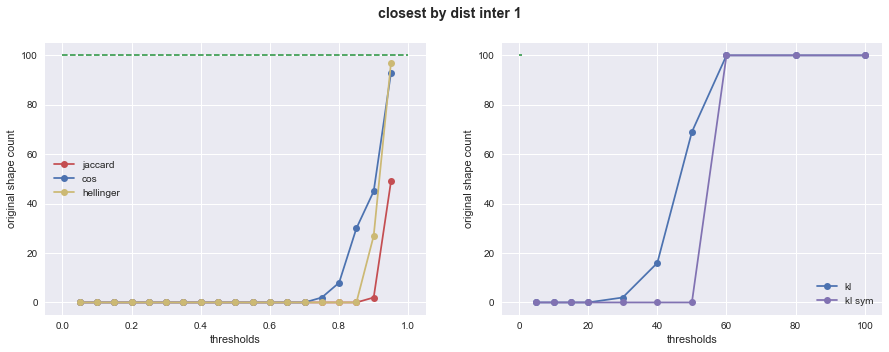

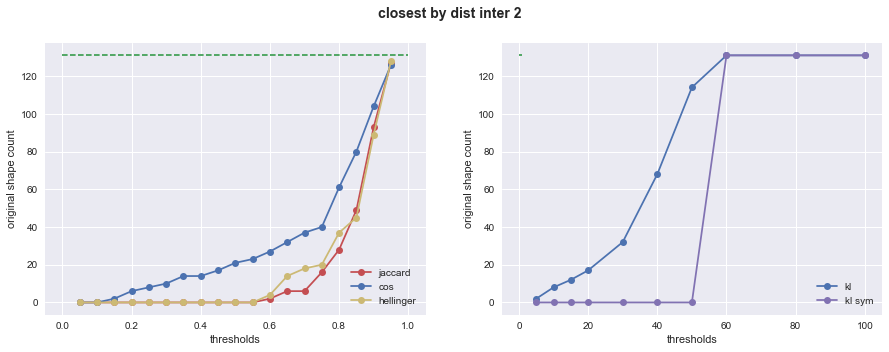

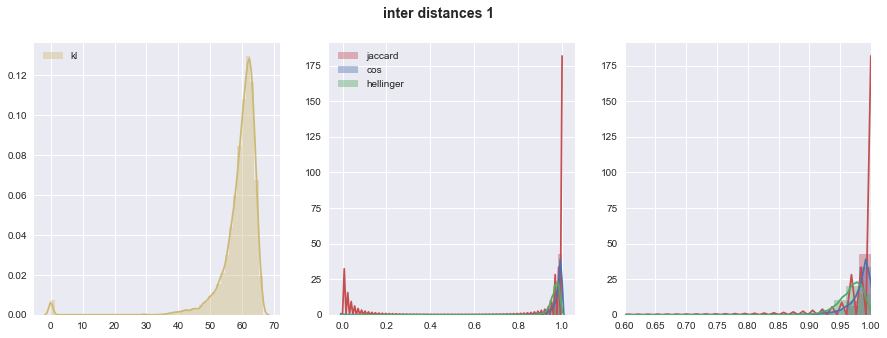

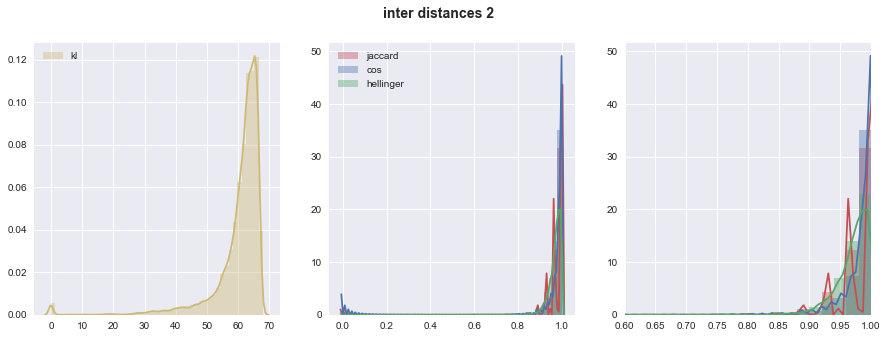

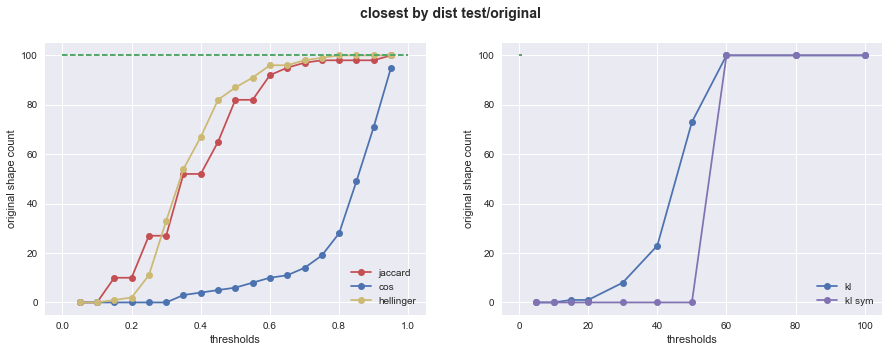

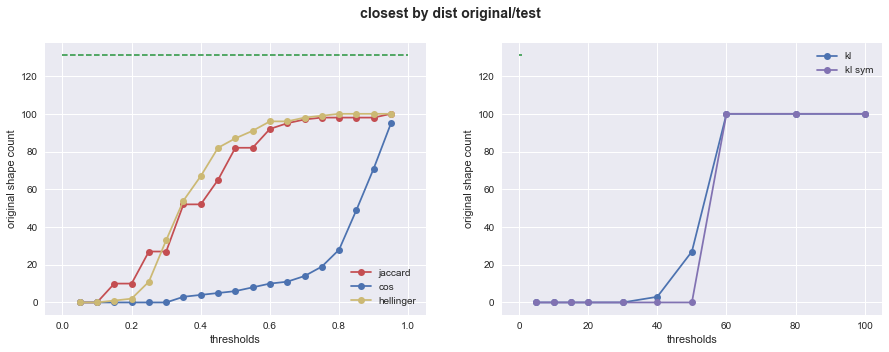

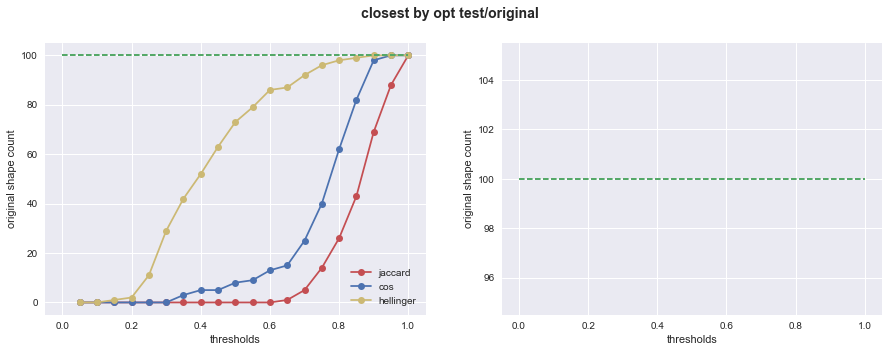

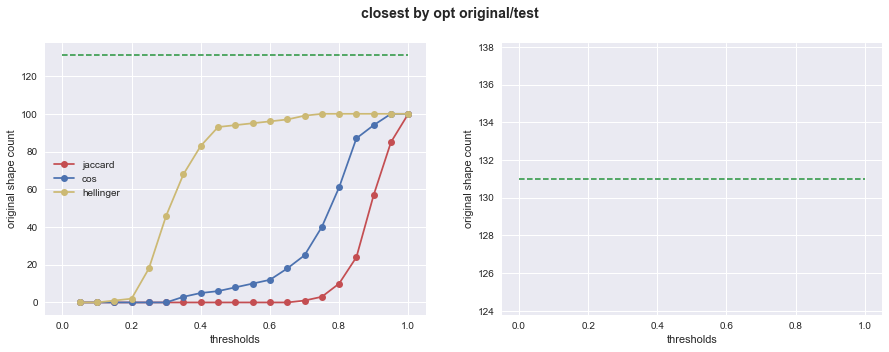

In [16]:
def create_model_rch_150_1_decor_ts(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2    
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=15, 
                                  _model_name=model_name)
    
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.7
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 41
names_list[idx] = u'create_model_rch_150_1_decor_ts'
models_list[idx] = create_model_rch_150_1_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 131, 0.98
* **kernel size**: 24 vs 17, **purity**: .63 vs .62, **contrast** .78 vs .79, **$phi_{ij}$**: --+-- 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|  j10  |j53-h68|j90-h98|    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|  0  	|  h50 	| h85  	| h98 	|
| closest by opt res original/test 	|  - 	|  h82 	|  h98	|   	||
* **Выводы**: 
* **Выводы**: 
* **TODO**: 

Спарсе по -1,5 для сравнения с без топик селектиона

name = create_model_rch_150_2_decor_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_150_2_decor_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -2
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -2

name = create_model_rch_150_2_decor_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -0.5
topic_selection_theta_regularizer, tau = 0.7
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = -0.5

('Filtered topics: ', 129, [u'topic_0', u'topic_1', u'topic_3', u'topic_4', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_21', u'topic_22', u'topic_23', u'topic_24

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   129.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2173.69
|phi_ij > 0.2| / n_topics         0.23     0.50
|phi_ij > 0.1| / n_topics         0.89     1.71
|phi_ij > 0.01| / n_topics       27.16    21.74
|phi_ij > 0.05| / n_topics        2.63     4.56
|phi_ij > 0.001| / n_topics      80.26    40.96
topic_kernel_average_size        23.68    16.67
topic_kernel_average_purity       0.63     0.63
topic_kernel_average_contrast     0.78     0.79

Dist fn = <function kl_sym_dist at 0x000000000C181978>, Processed th = 100, original columns count = 129        Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Dist fn = <function cos_dist at 0x000000000C181AC8>, Processed th = 1.0, original columns count = 100           Column topic_1 not optimized
Column topic_2 not optimized
Column topic_6 not optimized
Column topic_8 not optimized
Column topic_13 not optimized
Column topic_17 not optimized
Column topic_26 not optimized
Column topic_34 

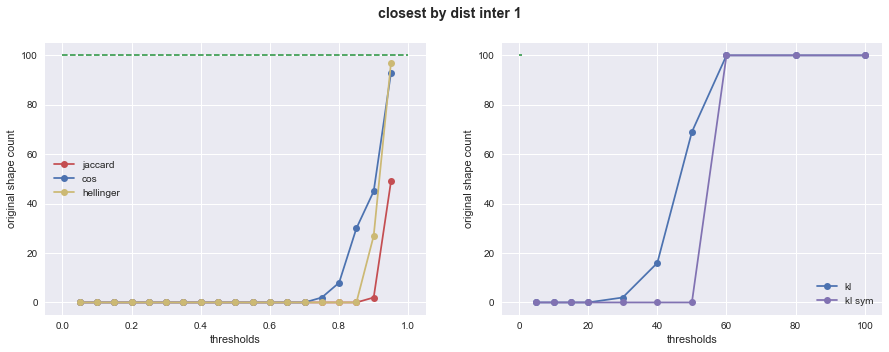

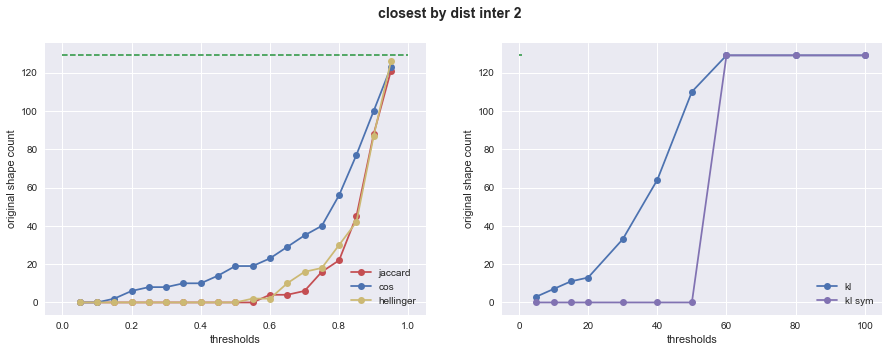

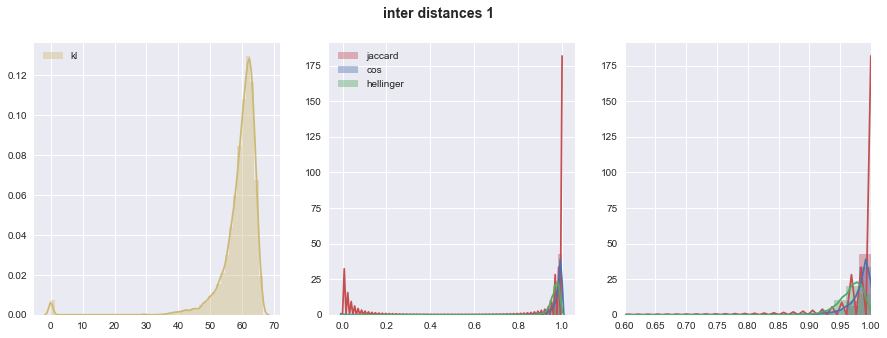

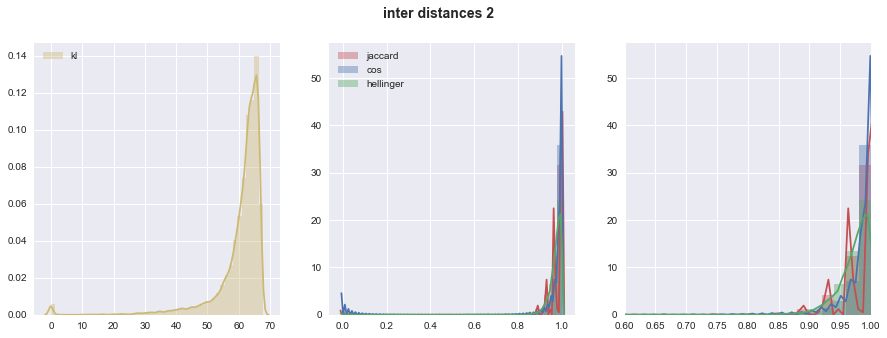

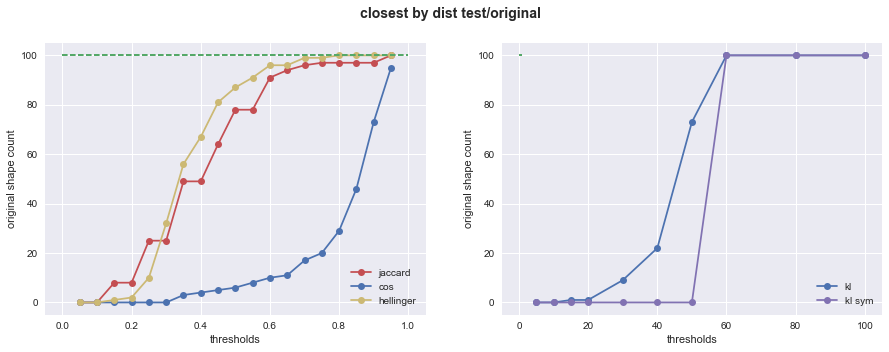

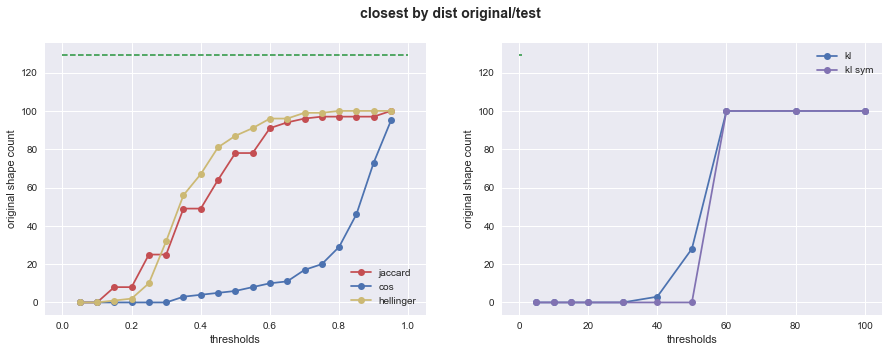

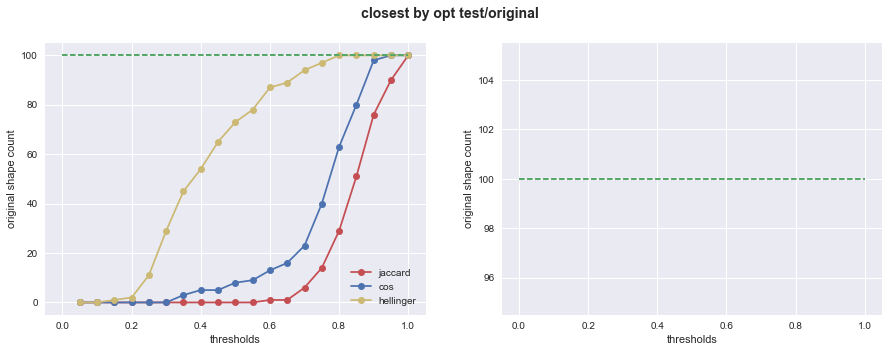

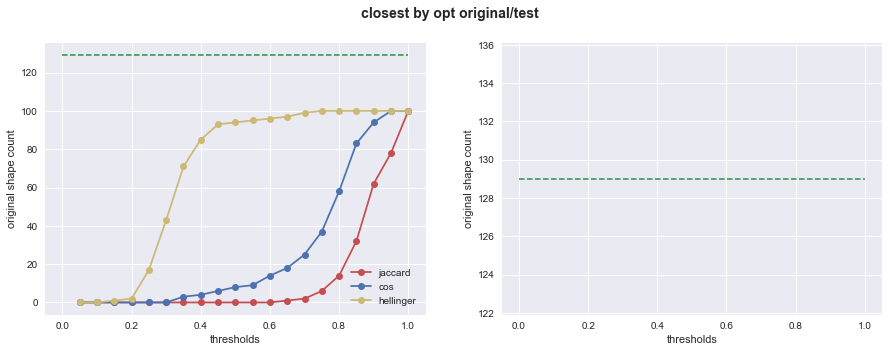

In [17]:
def create_model_rch_150_2_decor_ts(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2    
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.7
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 42
names_list[idx] = u'create_model_rch_150_2_decor_ts'
models_list[idx] = create_model_rch_150_2_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 129, 0.98
* **kernel size**: 24 vs 17, **purity**: .63 vs .63, **contrast** .78 vs .79, **$phi_{ij}$**:  --+--
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|  j10  |j50-h70|j90-h96|    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|  0  	|  h55 	|  h88 	| h100 	|
| closest by opt res original/test 	|  - 	|  h82 	|  h98	|   	||
* **Выводы**: 
* **TODO**: 

увеличим топик селекьтон коэф


name = create_model_rch_150_3_decor_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_150_3_decor_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 15, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -1.5
decorrelator_phi_regularizer, tau = 6
ss_phi_regularizer, tau = -1.5

name = create_model_rch_150_3_decor_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -0.5
topic_selection_theta_regularizer, tau = 0.9
decorrelator_phi_regularizer, tau = 0
ss_phi_regularizer, tau = -0.5

('Filtered topics: ', 142, [u'topic_0', u'topic_1', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   142.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2174.04
|phi_ij > 0.2| / n_topics         0.23     0.47
|phi_ij > 0.1| / n_topics         0.89     1.68
|phi_ij > 0.01| / n_topics       27.16    21.80
|phi_ij > 0.05| / n_topics        2.63     4.76
|phi_ij > 0.001| / n_topics      80.26    40.29
topic_kernel_average_size        23.68    15.66
topic_kernel_average_purity       0.63     0.60
topic_kernel_average_contrast     0.78     0.76

Dist fn = <function kl_sym_dist at 0x000000000C181978>, Processed th = 100, original columns count = 142        Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Processing <function jaccard_dist at 0x000000000C1819E8>
Processing <function cos_dist at 0x000000000C181AC8>
Processing <function hellinger_dist at 0x000000000C181B38>
Processing <function kl_dist at 0x000000000C181908>
Processing <function kl_sym_dist at 0x000000000C181978>
Dist fn = <function cos_dist at 0x000000000C181AC8>, Processed th = 1.0, original columns count = 100           Column topic_7 not optimized
Column topic_11 not optimized
Column topic_25 not optimized
Column topic_30 not optimized
Column topic_32 not optimized
Column topic_34 not optimized
Column topic_35 not optimized
Column topic_

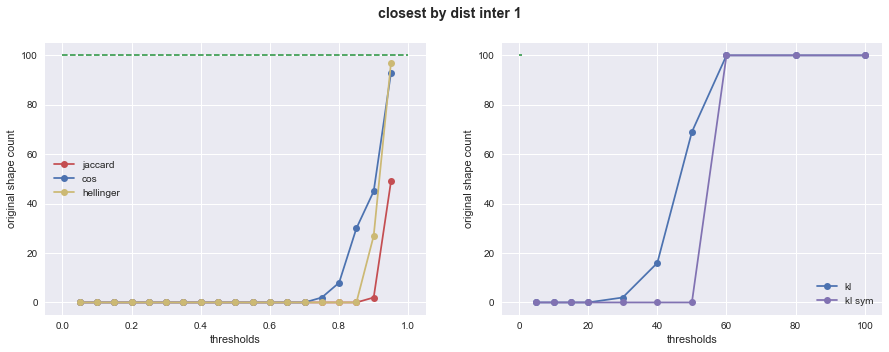

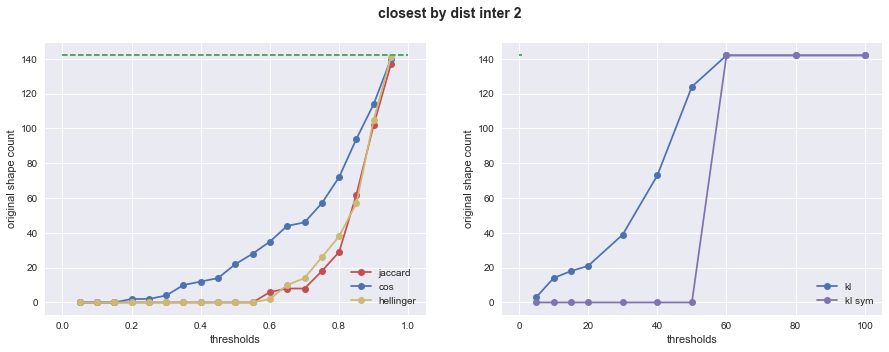

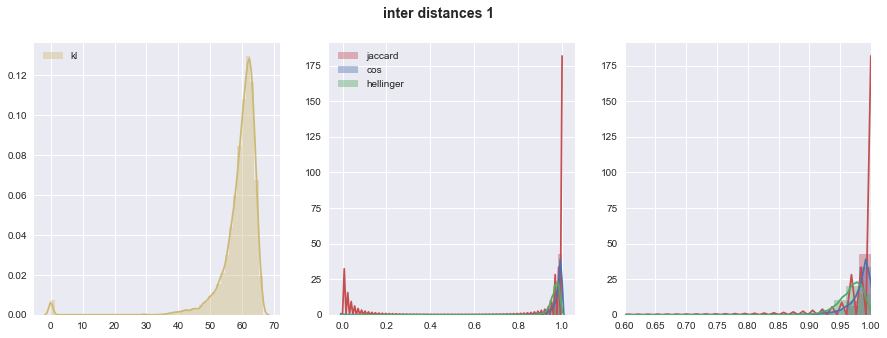

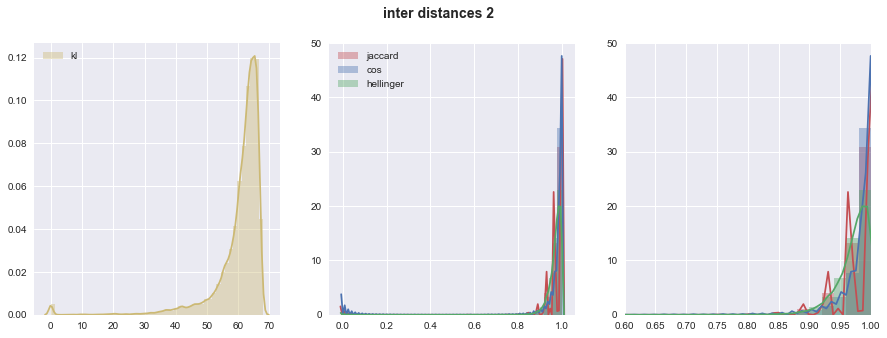

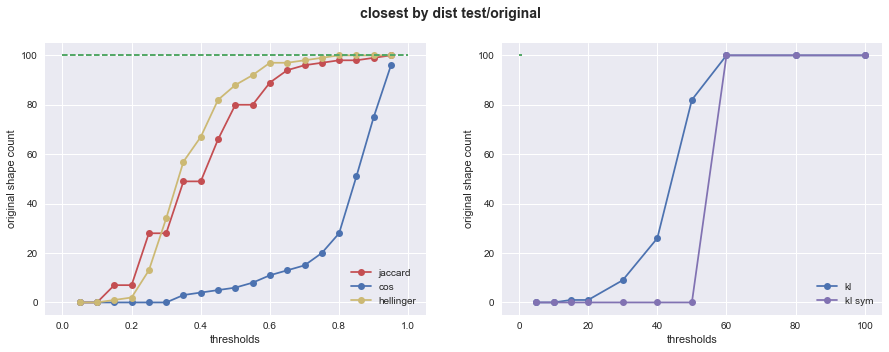

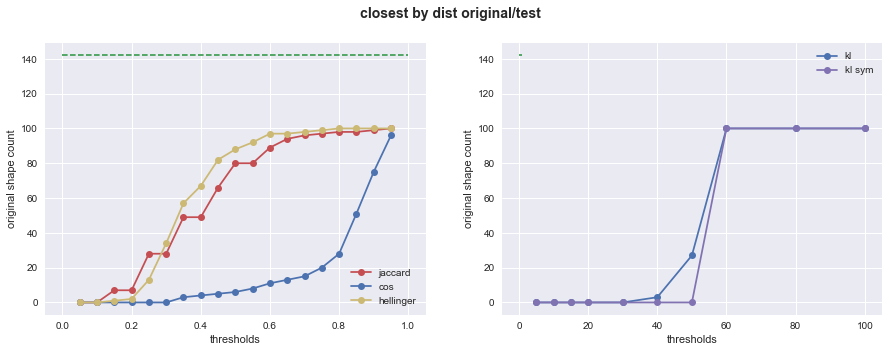

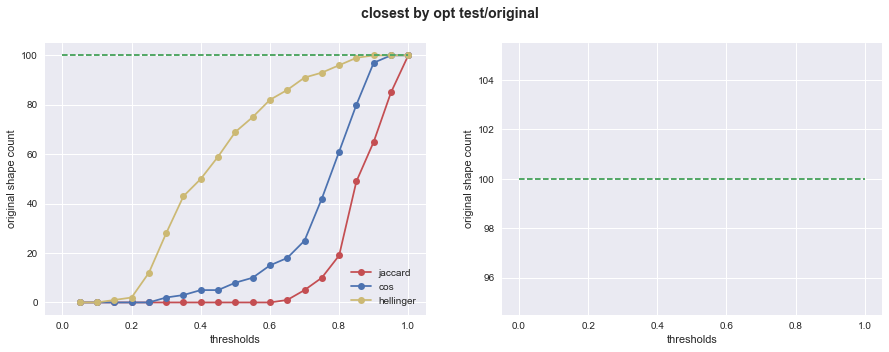

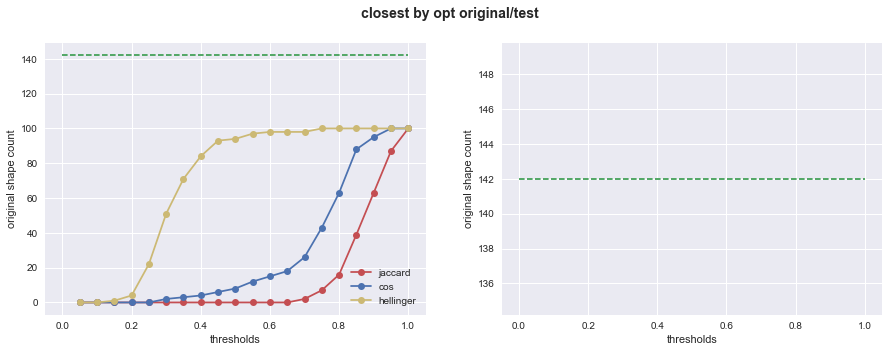

In [18]:
def create_model_rch_150_3_decor_ts(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 6
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1.5    
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=20, 
                                  _model_name=model_name)
    
    tmp_model.regularizers.add(artm.TopicSelectionThetaRegularizer(name='topic_selection_theta_regularizer'))    
    tmp_model.regularizers['topic_selection_theta_regularizer'].tau = 0.9
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 0
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    return tmp_model

idx = 41
names_list[idx] = u'create_model_rch_150_3_decor_ts'
models_list[idx] = create_model_rch_150_3_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

* 150 -> 142, 0.98
* **kernel size**: 24 vs 16, **purity**: .63 vs .60, **contrast** .78 vs .76, **$phi_{ij}$**: --+-- 
* **closest by dist**: 
* **inter distances**: 

|                                  	| 0.2 	| 0.4 	| 0.6 	| 0.8 	|
|:--------------------------------:	|:---:	|:---:	|:---:	|:---:	|
|   closestby dist test/original   	|  j10  |j53-h68|j90-h98|    	|
|   closest by dist original/test  	|  -	|   -  	|   - 	|    	|
| closest by opt res test/original 	|  0  	|  h50 	|  h82 	| h98 	|
| closest by opt res original/test 	|  - 	|  h82 	|  h100	|   	||
* **Выводы**: 
* **TODO**: 

## start iterations = 25
Попробуем побить результат без регуляризатора. 

name = create_model_rch_150_4_decor_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_150_4_decor_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -2.5
decorrelator_phi_regularizer, tau = 12
ss_phi_regularizer, tau = -2.5

('Filtered topics: ', 131, [u'topic_0', u'topic_4', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topi

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   131.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2166.40
|phi_ij > 0.2| / n_topics         0.23     0.47
|phi_ij > 0.1| / n_topics         0.89     1.47
|phi_ij > 0.01| / n_topics       27.16    24.51
|phi_ij > 0.05| / n_topics        2.63     4.13
|phi_ij > 0.001| / n_topics      80.26    47.35
topic_kernel_average_size        23.68    16.80
topic_kernel_average_purity       0.63     0.53
topic_kernel_average_contrast     0.78     0.74

Dist fn = <function kl_sym_dist at 0x000000000BCFB3C8>, Processed th = 100, original columns count = 131        Processing <function jaccard_dist at 0x000000000BCFB438>
Processing <function cos_dist at 0x000000000BCFB518>
Processing <function hellinger_dist at 0x000000000BCFB588>
Processing <function kl_dist at 0x000000000BC61668>
Processing <function kl_sym_dist at 0x000000000BCFB3C8>
Processing <function jaccard_dist at 0x000000000BCFB438>
Processing <function cos_dist at 0x000000000BCFB518>
Processing <function hellinger_dist at 0x000000000BCFB588>
Processing <function kl_dist at 0x000000000BC61668>
Processing <function kl_sym_dist at 0x000000000BCFB3C8>
Dist fn = <function cos_dist at 0x000000000BCFB518>, Processed th = 1.0, original columns count = 100           Column topic_4 not optimized
Column topic_6 not optimized
Column topic_16 not optimized
Column topic_17 not optimized
Column topic_26 not optimized
Column topic_41 not optimized
Column topic_43 not optimized
Column topic_4

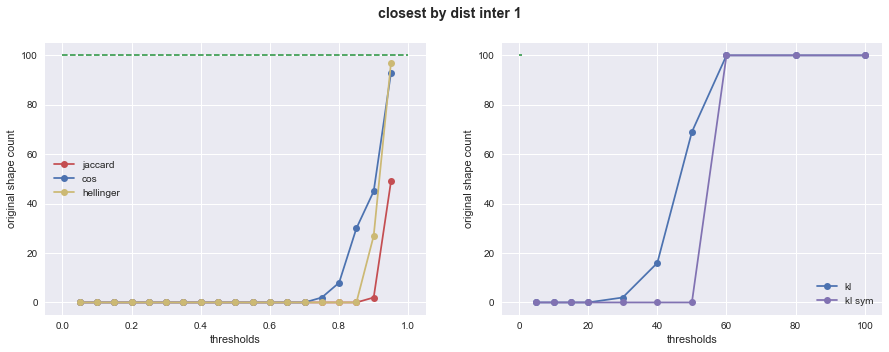

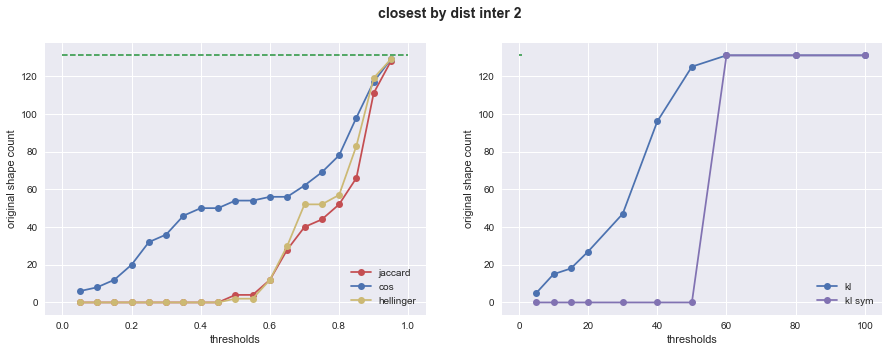

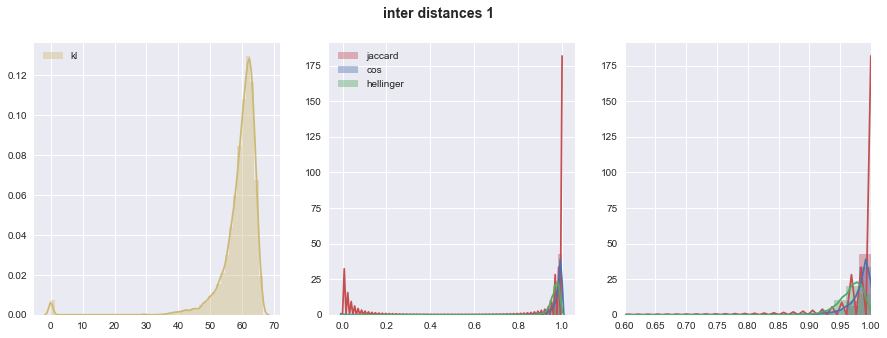

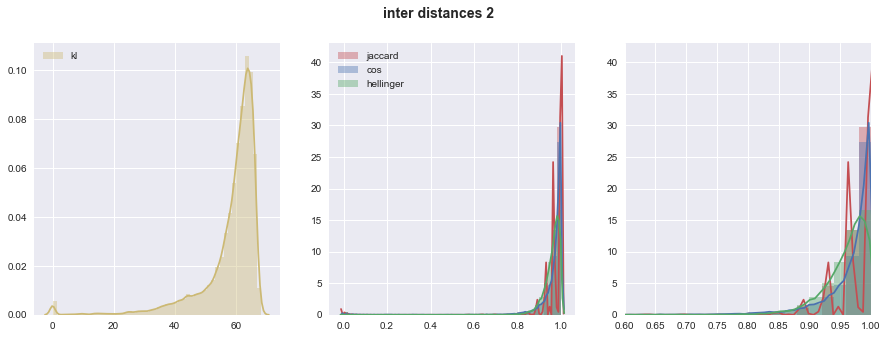

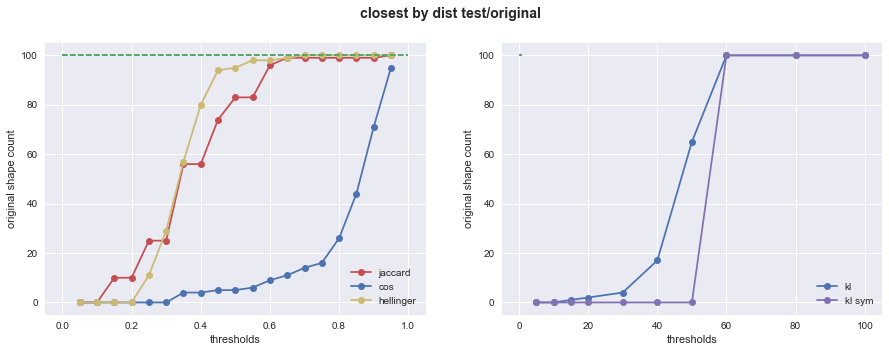

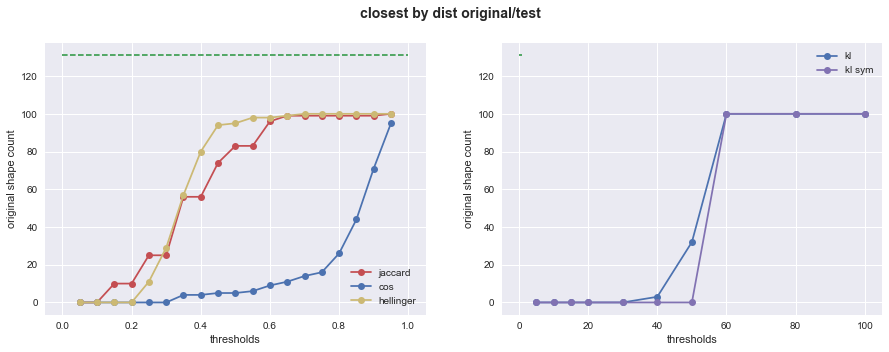

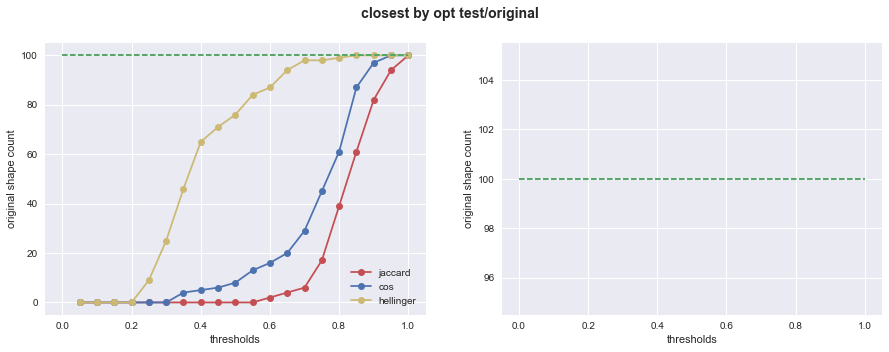

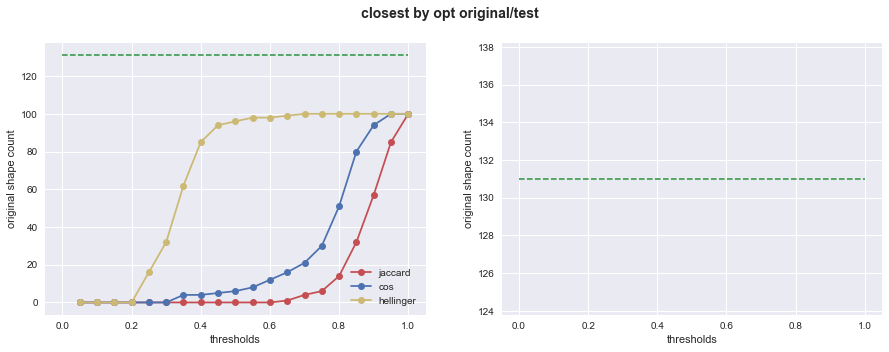

In [77]:
def create_model_rch_150_4_decor_ts(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 12
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2.5    
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)    
    return tmp_model

idx = 51
names_list[idx] = u'create_model_rch_150_4_decor_ts'
models_list[idx] = create_model_rch_150_4_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [79]:
df = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS)
df 

0.2          0.4          0.6  \
150 -> 131, 0.98                  24 vs 16.80  .63 vs 0.53  .78 vs 0.74   
closest by dist test/original          j10-h0      j56-h80      j96-h98   
closest by dist original/test          j10-h0      j56-h80      j96-h98   
closest by opt res test/original          jh0       j0-h65       j2-h87   
closest by opt res original/test          jh0       j0-h85       j0-h98   

                                       0.8  
150 -> 131, 0.98                     --+--  
closest by dist test/original     j99-h100  
closest by dist original/test     j99-h100  
closest by opt res test/original   j39-h99  
closest by opt res original/test  j14-h100

name = create_model_rch_150_5_decor_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_150_5_decor_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -4
decorrelator_phi_regularizer, tau = 12
ss_phi_regularizer, tau = -4

('Filtered topics: ', 116, [u'topic_0', u'topic_4', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_14', u'topic_16', u'topic_17', u'topic_18', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_47', u'topic_49', u'topic_50', u'topic_51', u'topic_53', u'topic_54', u'topic_55', u'topic_56

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   116.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2164.47
|phi_ij > 0.2| / n_topics         0.23     0.43
|phi_ij > 0.1| / n_topics         0.89     1.32
|phi_ij > 0.01| / n_topics       27.16    24.85
|phi_ij > 0.05| / n_topics        2.63     4.03
|phi_ij > 0.001| / n_topics      80.26    49.32
topic_kernel_average_size        23.68    18.17
topic_kernel_average_purity       0.63     0.56
topic_kernel_average_contrast     0.78     0.77

Dist fn = <function kl_sym_dist at 0x000000000BCFB3C8>, Processed th = 100, original columns count = 116        Processing <function jaccard_dist at 0x000000000BCFB438>
Processing <function cos_dist at 0x000000000BCFB518>
Processing <function hellinger_dist at 0x000000000BCFB588>
Processing <function kl_dist at 0x000000000BC61668>
Processing <function kl_sym_dist at 0x000000000BCFB3C8>
Processing <function jaccard_dist at 0x000000000BCFB438>
Processing <function cos_dist at 0x000000000BCFB518>
Processing <function hellinger_dist at 0x000000000BCFB588>
Processing <function kl_dist at 0x000000000BC61668>
Processing <function kl_sym_dist at 0x000000000BCFB3C8>
Dist fn = <function cos_dist at 0x000000000BCFB518>, Processed th = 1.0, original columns count = 100           Column topic_7 not optimized
Column topic_17 not optimized
Column topic_24 not optimized
Column topic_41 not optimized
Column topic_90 not optimized
Column topic_106 not optimized
Column topic_107 not optimized
Column topi

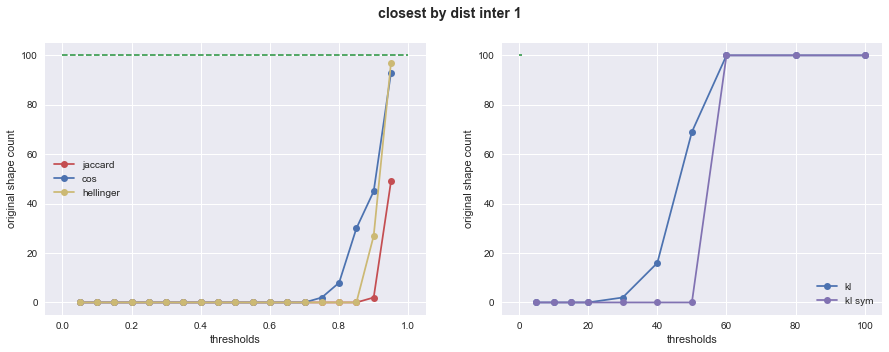

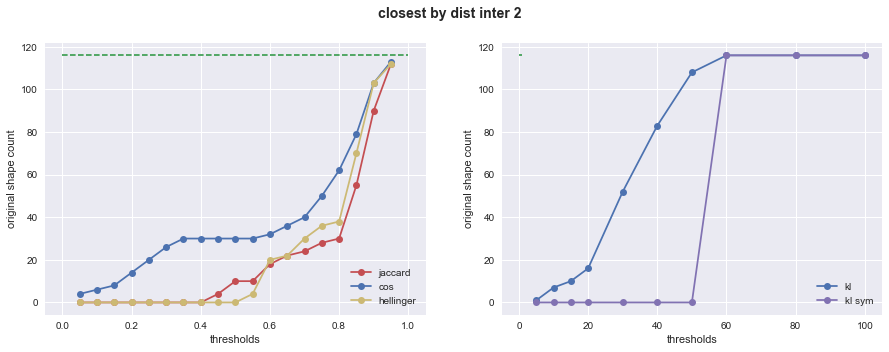

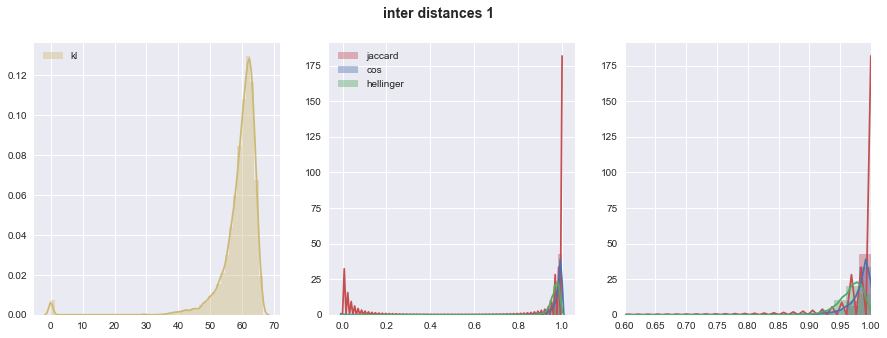

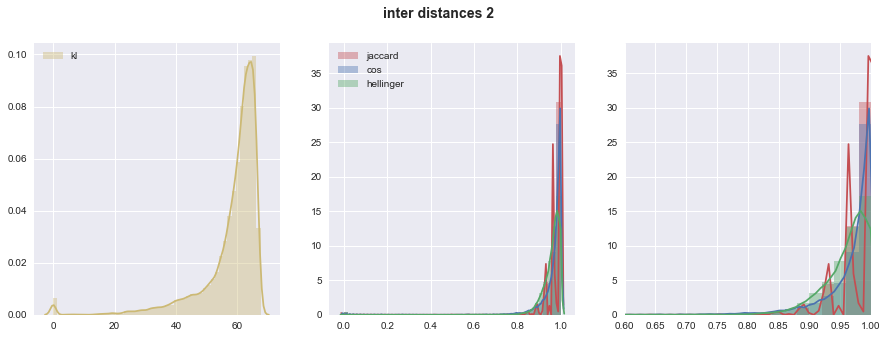

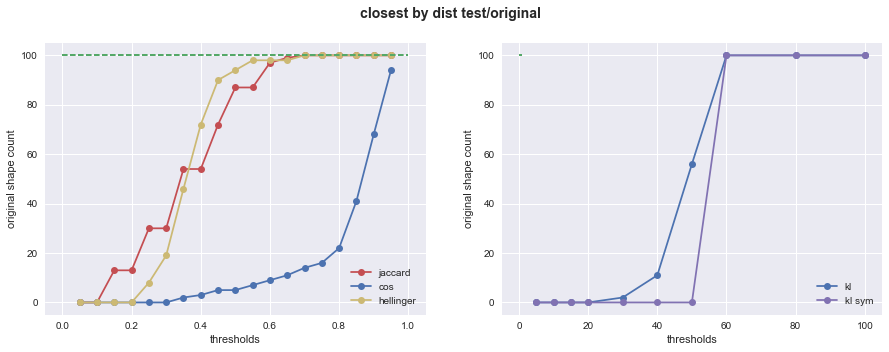

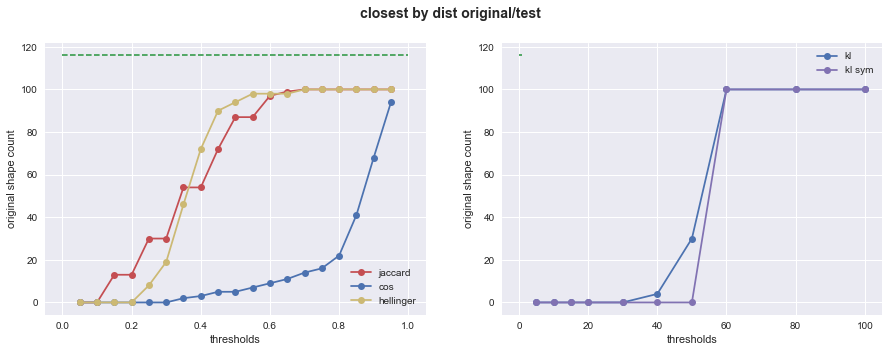

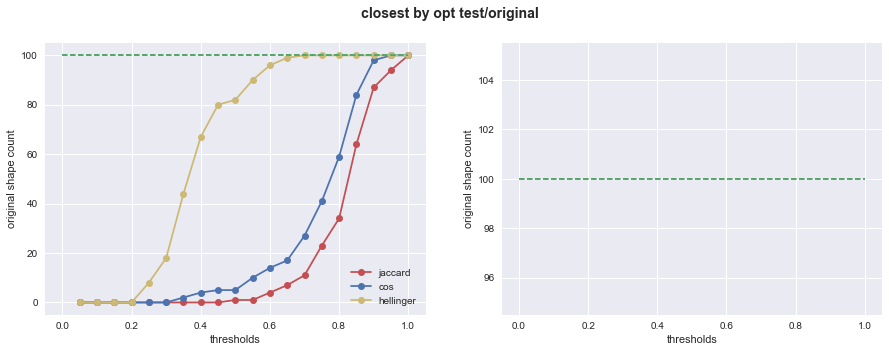

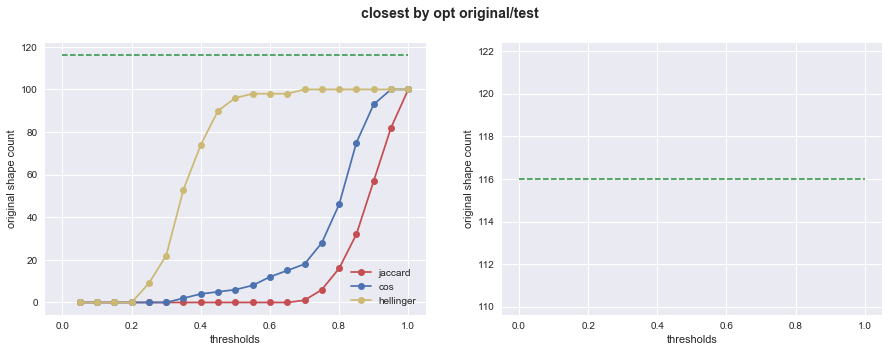

In [81]:
def create_model_rch_150_5_decor_ts(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 12
    tmp_model.regularizers['ss_theta_regularizer'].tau = -4
    tmp_model.regularizers['ss_phi_regularizer'].tau = -4    
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)    
    return tmp_model

idx = 52
names_list[idx] = u'create_model_rch_150_5_decor_ts'
models_list[idx] = create_model_rch_150_5_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])
    
    df = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS)
    df 

In [83]:
df

0.2          0.4          0.6  \
150 -> 116, 0.98                  24 vs 18.17  .63 vs 0.56  .78 vs 0.77   
closest by dist test/original          j13-h0      j54-h72      j97-h98   
closest by dist original/test          j13-h0      j54-h72      j97-h98   
closest by opt res test/original          jh0       j0-h67       j4-h96   
closest by opt res original/test          jh0       j0-h74       j0-h98   

                                       0.8  
150 -> 116, 0.98                     --+--  
closest by dist test/original        jh100  
closest by dist original/test        jh100  
closest by opt res test/original  j34-h100  
closest by opt res original/test  j16-h100

name = create_model_rch_150_6_decor_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_150_6_decor_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
ss_theta_regularizer, tau = -0.5
decorrelator_phi_regularizer, tau = 1.5
ss_phi_regularizer, tau = -0.5

('Filtered topics: ', 130, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_16', u'topic_17', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_4

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   130.00
non zero ratio                    0.96     0.98
|phi_ij == 0| / n_topics       2126.43  2168.98
|phi_ij > 0.2| / n_topics         0.23     0.47
|phi_ij > 0.1| / n_topics         0.89     1.58
|phi_ij > 0.01| / n_topics       27.16    23.22
|phi_ij > 0.05| / n_topics        2.63     4.31
|phi_ij > 0.001| / n_topics      80.26    43.06
topic_kernel_average_size        23.68    18.41
topic_kernel_average_purity       0.63     0.61
topic_kernel_average_contrast     0.78     0.75

Dist fn = <function kl_sym_dist at 0x000000000BCFB3C8>, Processed th = 100, original columns count = 130        Processing <function jaccard_dist at 0x000000000BCFB438>
Processing <function cos_dist at 0x000000000BCFB518>
Processing <function hellinger_dist at 0x000000000BCFB588>
Processing <function kl_dist at 0x000000000BC61668>
Processing <function kl_sym_dist at 0x000000000BCFB3C8>
Processing <function jaccard_dist at 0x000000000BCFB438>
Processing <function cos_dist at 0x000000000BCFB518>
Processing <function hellinger_dist at 0x000000000BCFB588>
Processing <function kl_dist at 0x000000000BC61668>
Processing <function kl_sym_dist at 0x000000000BCFB3C8>
Dist fn = <function cos_dist at 0x000000000BCFB518>, Processed th = 1.0, original columns count = 100           Column topic_6 not optimized
Column topic_7 not optimized
Column topic_11 not optimized
Column topic_33 not optimized
Column topic_34 not optimized
Column topic_40 not optimized
Column topic_41 not optimized
Column topic_4

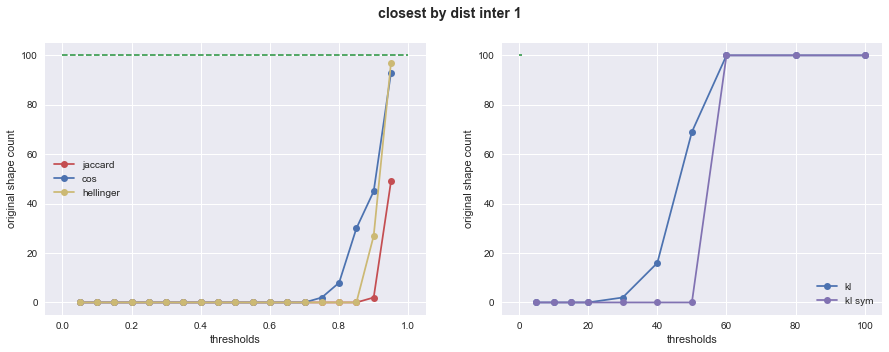

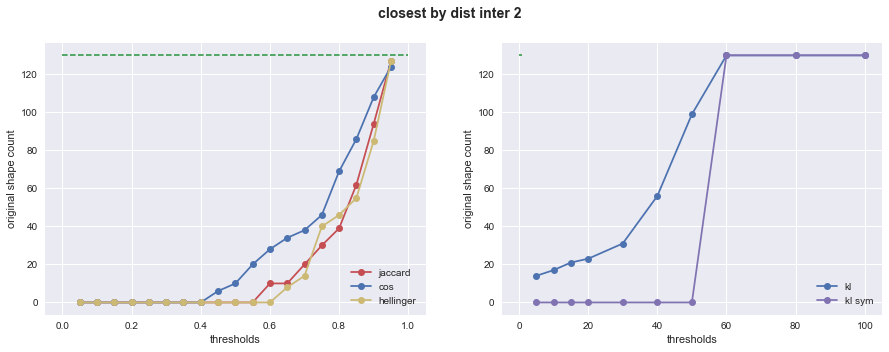

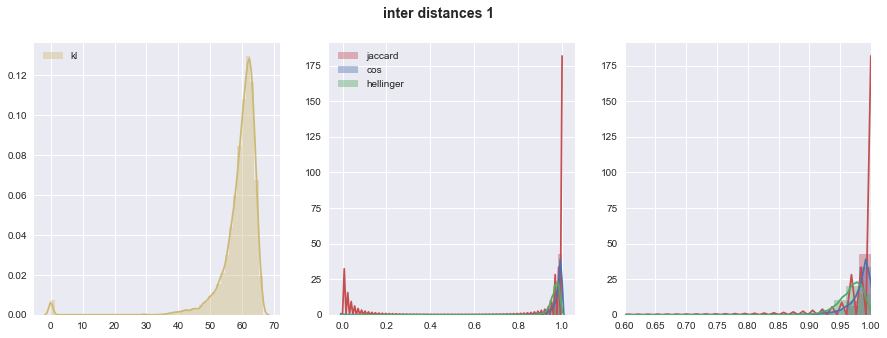

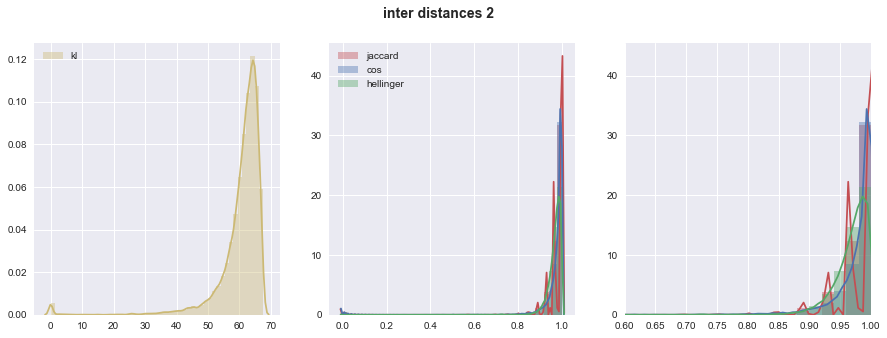

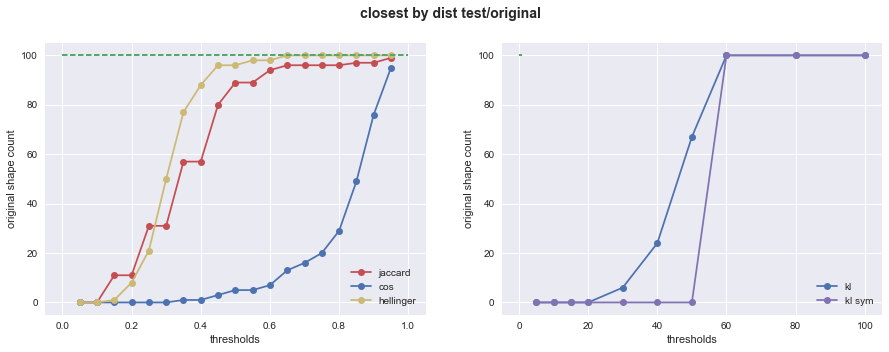

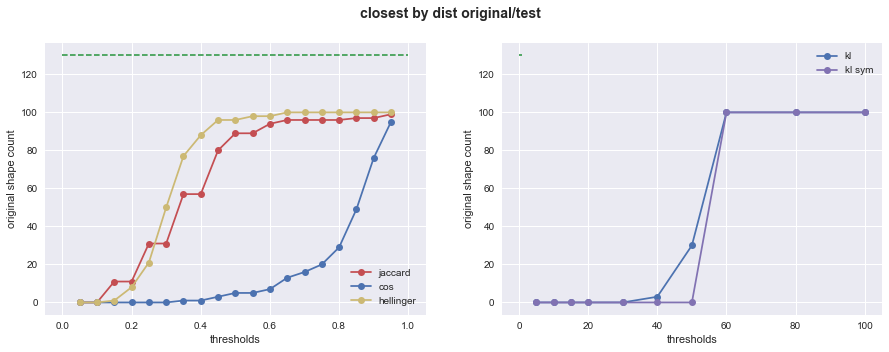

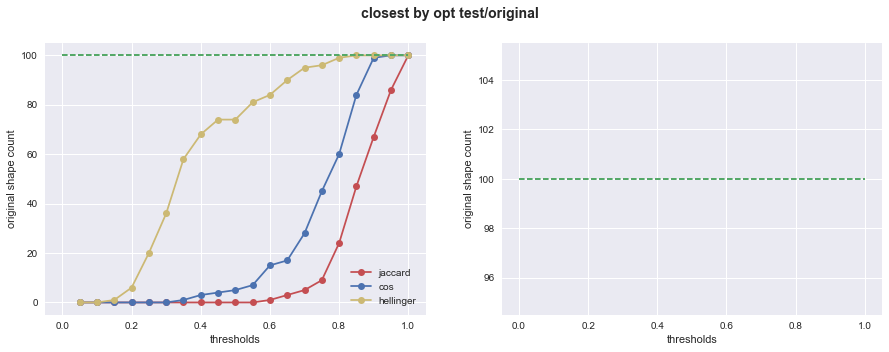

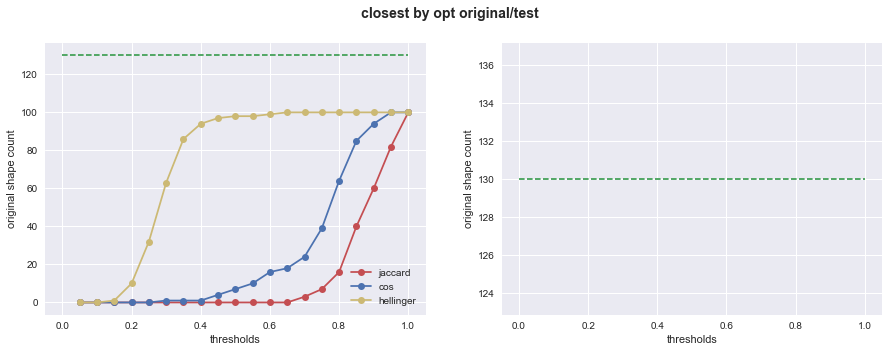

In [84]:
def create_model_rch_150_6_decor_ts(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 1.5
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)    
    return tmp_model

idx = 53
names_list[idx] = u'create_model_rch_150_6_decor_ts'
models_list[idx] = create_model_rch_150_6_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])
    
    df = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS)

In [85]:
df

0.2          0.4          0.6  \
150 -> 130, 0.98                  24 vs 18.41  .63 vs 0.61  .78 vs 0.75   
closest by dist test/original          j11-h8      j57-h88      j94-h98   
closest by dist original/test          j11-h8      j57-h88      j94-h98   
closest by opt res test/original        j0-h6       j0-h68       j1-h84   
closest by opt res original/test       j0-h10       j0-h94       j0-h99   

                                       0.8  
150 -> 130, 0.98                     --+--  
closest by dist test/original     j96-h100  
closest by dist original/test     j96-h100  
closest by opt res test/original   j24-h99  
closest by opt res original/test  j16-h100

name = create_model_rch_150_5_decor_ts_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 135, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_16', u'topic_17', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_44', u'topic_45', u'topic_46', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_58', u'topic_59', u'topic_60', u'topic_61', u'topic_62', u'topic_63', u'topic_64', u'topic_65', u'topic_66', u'topic_68', u'topic_69', u'topic_

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   135.00
non zero ratio                    0.96     0.85
|phi_ij == 0| / n_topics       2126.43  1872.59
|phi_ij > 0.2| / n_topics         0.23     0.56
|phi_ij > 0.1| / n_topics         0.89     1.57
|phi_ij > 0.01| / n_topics       27.16    20.70
|phi_ij > 0.05| / n_topics        2.63     4.11
|phi_ij > 0.001| / n_topics      80.26    49.02
topic_kernel_average_size        23.68    17.73
topic_kernel_average_purity       0.63     0.63
topic_kernel_average_contrast     0.78     0.74

Dist fn = <function kl_sym_dist at 0x000000000BCFB3C8>, Processed th = 100, original columns count = 135        Processing <function jaccard_dist at 0x000000000BCFB438>
Processing <function cos_dist at 0x000000000BCFB518>
Processing <function hellinger_dist at 0x000000000BCFB588>
Processing <function kl_dist at 0x000000000BC61668>
Processing <function kl_sym_dist at 0x000000000BCFB3C8>
Processing <function jaccard_dist at 0x000000000BCFB438>
Processing <function cos_dist at 0x000000000BCFB518>
Processing <function hellinger_dist at 0x000000000BCFB588>
Processing <function kl_dist at 0x000000000BC61668>
Processing <function kl_sym_dist at 0x000000000BCFB3C8>
Dist fn = <function cos_dist at 0x000000000BCFB518>, Processed th = 1.0, original columns count = 100           Column topic_12 not optimized
Column topic_17 not optimized
Column topic_32 not optimized
Column topic_41 not optimized
Column topic_51 not optimized
Column topic_70 not optimized
Column topic_71 not optimized
Column topic

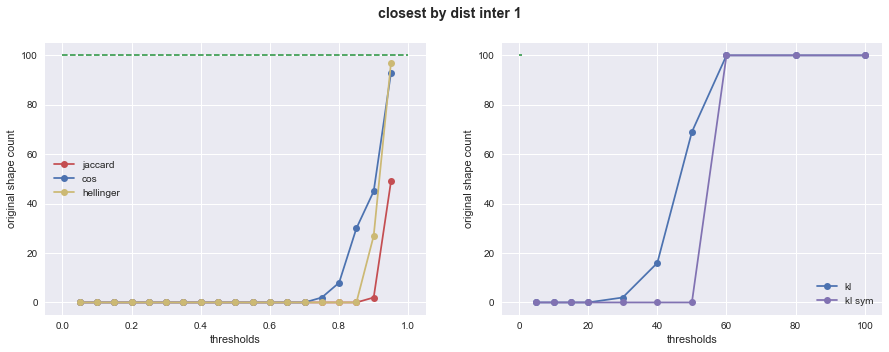

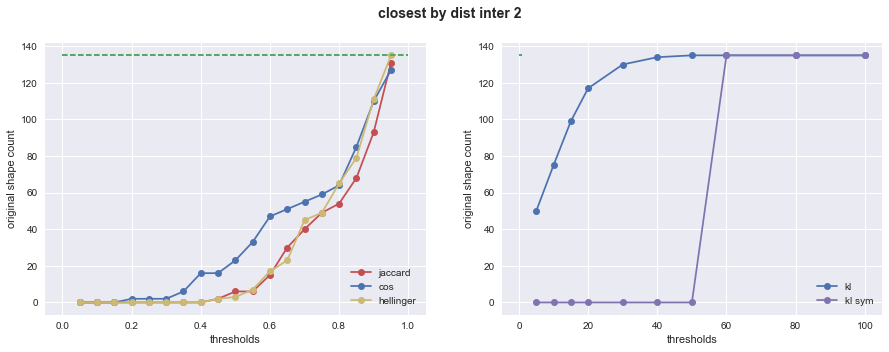

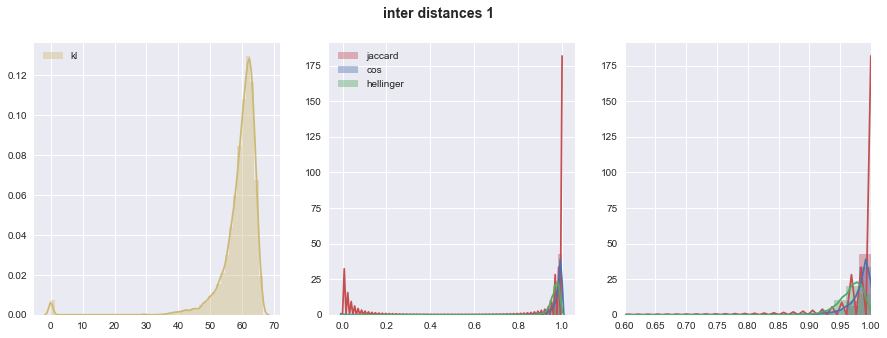

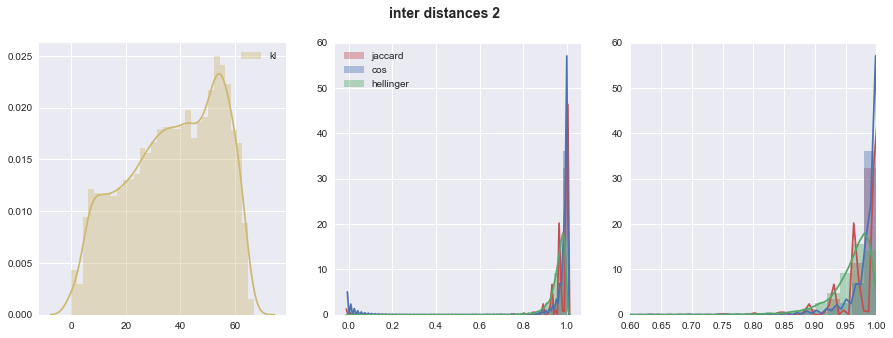

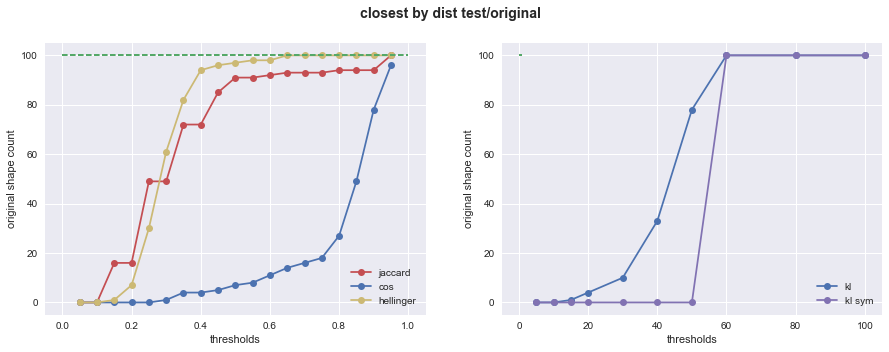

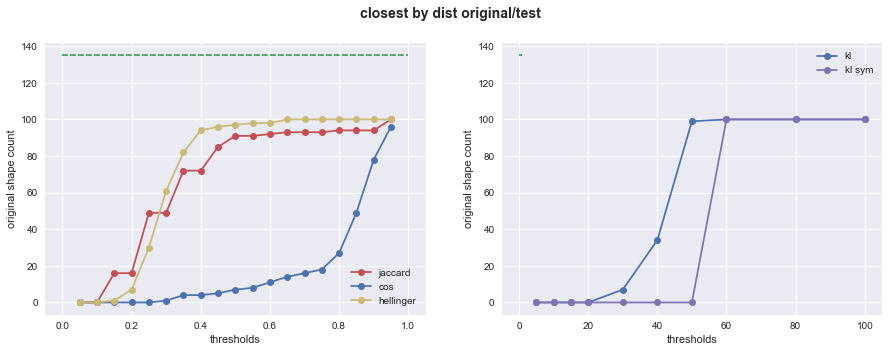

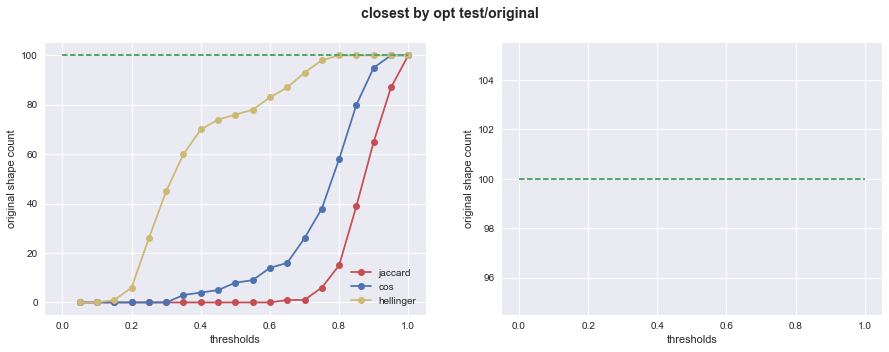

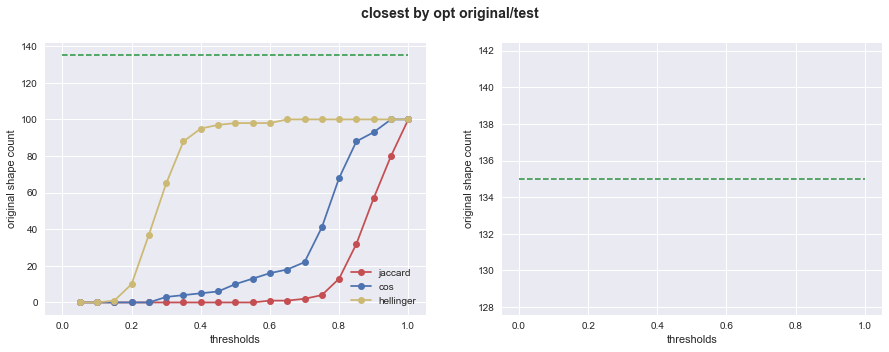

In [54]:
def create_model_rch_150_5_decor_ts(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)   
    return tmp_model

idx = 52
names_list[idx] = u'create_model_rch_150_5_decor_ts'
models_list[idx] = create_model_rch_150_5_decor_ts(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [73]:
df = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS)
df

0.2          0.4          0.6  \
150 -> 135.0, 0.84503275839       24 vs 17.73  .63 vs 0.63  .78 vs 0.74   
closest by dist test/original          j16-h7      j72-h94      j92-h98   
closest by dist original/test          j16-h7      j72-h94      j92-h98   
closest by opt res test/original        j0-h6       j0-h70       j0-h83   
closest by opt res original/test       j0-h10       j0-h95       j1-h98   

                                       0.8  
150 -> 135.0, 0.84503275839          --+--  
closest by dist test/original     j94-h100  
closest by dist original/test     j94-h100  
closest by opt res test/original  j15-h100  
closest by opt res original/test  j13-h100

name = create_model_rch_150_1_no_sparse_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_150_1_no_sparse_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
decorrelator_phi_regularizer, tau = 1.5

('Filtered topics: ', 150, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topi

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   150.00
non zero ratio                    0.96     0.93
|phi_ij == 0| / n_topics       2126.43  2062.51
|phi_ij > 0.2| / n_topics         0.23     0.64
|phi_ij > 0.1| / n_topics         0.89     1.67
|phi_ij > 0.01| / n_topics       27.16    18.22
|phi_ij > 0.05| / n_topics        2.63     4.02
|phi_ij > 0.001| / n_topics      80.26    39.22
topic_kernel_average_size        23.68    16.05
topic_kernel_average_purity       0.63     0.69
topic_kernel_average_contrast     0.78     0.76

Dist fn = <function kl_sym_dist at 0x000000000C1843C8>, Processed th = 100, original columns count = 150        Processing <function jaccard_dist at 0x000000000C184438>
Processing <function cos_dist at 0x000000000C184518>
Processing <function hellinger_dist at 0x000000000C184588>
Processing <function kl_dist at 0x000000000C0F8668>
Processing <function kl_sym_dist at 0x000000000C1843C8>
Processing <function jaccard_dist at 0x000000000C184438>
Processing <function cos_dist at 0x000000000C184518>
Processing <function hellinger_dist at 0x000000000C184588>
Processing <function kl_dist at 0x000000000C0F8668>
Processing <function kl_sym_dist at 0x000000000C1843C8>
Dist fn = <function hellinger_dist at 0x000000000C184588>, Processed th = 0.95, original columns count = 100    

C:\Users\Sheldon\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


Dist fn = <function hellinger_dist at 0x000000000C184588>, Processed th = 1.0, original columns count = 100     Column topic_0 not optimized
Column topic_1 not optimized
Column topic_15 not optimized
Column topic_24 not optimized
Column topic_33 not optimized
Column topic_41 not optimized
Column topic_46 not optimized
Column topic_51 not optimized
Column topic_55 not optimized
Column topic_56 not optimized
Column topic_57 not optimized
Column topic_71 not optimized
Column topic_72 not optimized
Column topic_73 not optimized
Column topic_76 not optimized
Column topic_77 not optimized
Column topic_79 not optimized
Column topic_83 not optimized
Column topic_84 not optimized
Column topic_87 not optimized
Column topic_94 not optimized
Column topic_96 not optimized
Dist fn = <function hellinger_dist at 0x000000000C184588>, Processed th = 1.0, original columns count = 100     [(u'topic_0', u'topic_69', 0, 69, 0.28862693801834666), (u'topic_1', u'topic_68', 1, 68, 0.73184549598840709), (u'topi

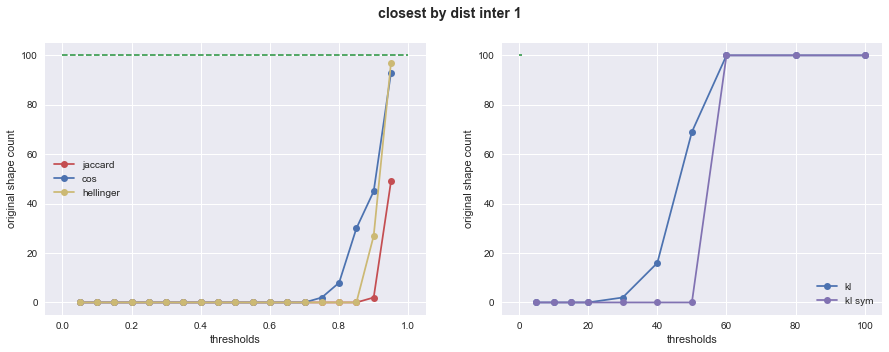

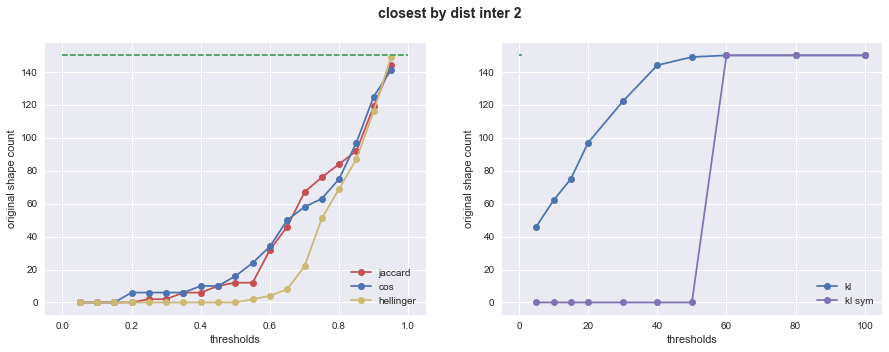

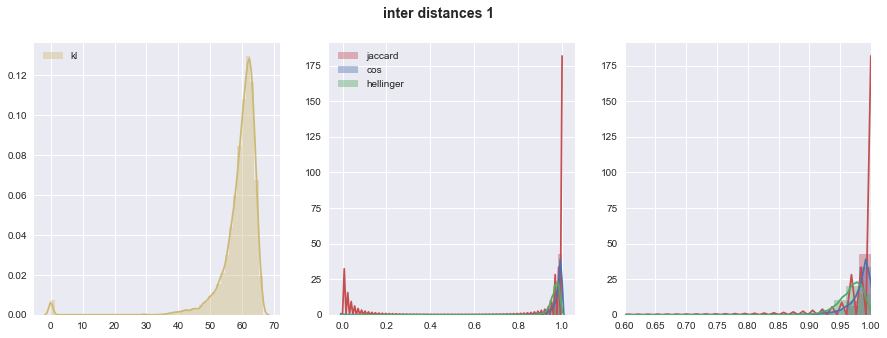

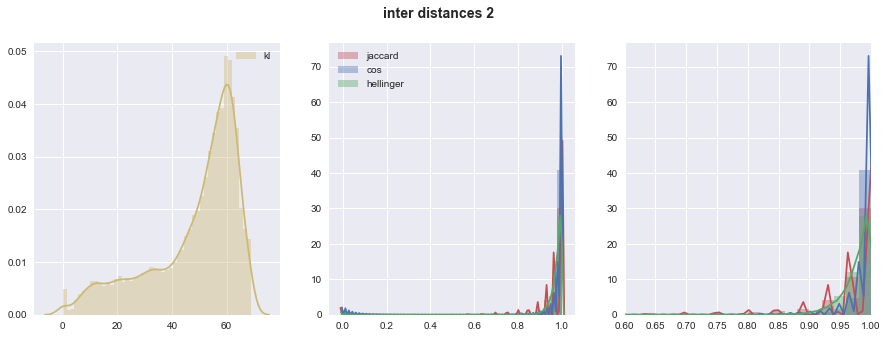

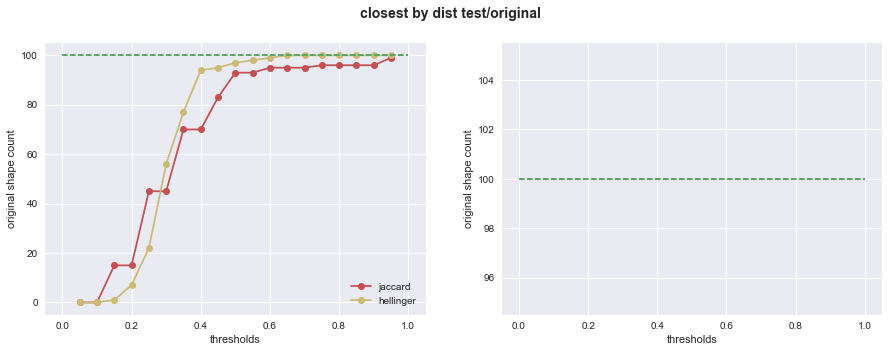

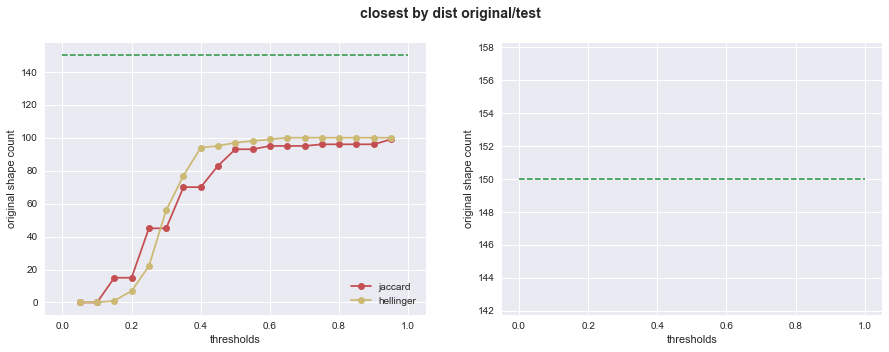

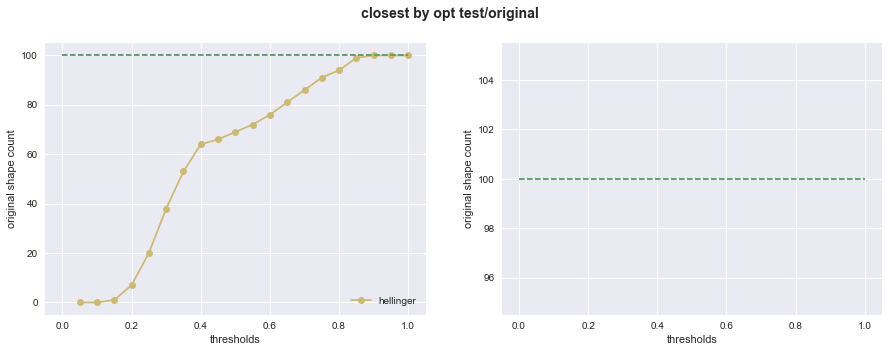

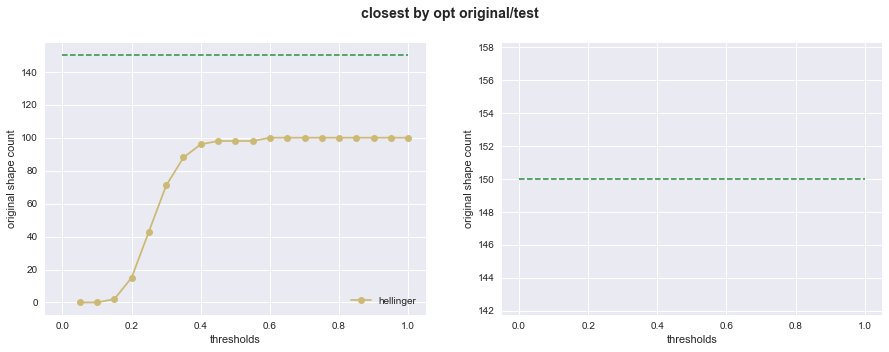

In [8]:
def create_model_rch_150_1_no_sparse(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)   
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 1.5
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)    
    return tmp_model

idx = 61
names_list[idx] = u'create_model_rch_150_1_no_sparse'
models_list[idx] = create_model_rch_150_1_no_sparse(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [13]:
df = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS)
df

0.2          0.4          0.6  \
150 -> 150, 0.93                  24 vs 16.05  .63 vs 0.69  .78 vs 0.76   
closest by dist test/original          j15-h7      j70-h94      j95-h99   
closest by dist original/test          j15-h7      j70-h94      j95-h99   
closest by opt res test/original        j0-h7       j0-h64       j0-h76   
closest by opt res original/test       j0-h15       j0-h96      j0-h100   

                                       0.8  
150 -> 150, 0.93                     -----  
closest by dist test/original     j96-h100  
closest by dist original/test     j96-h100  
closest by opt res test/original    j0-h94  
closest by opt res original/test   j0-h100

name = create_model_rch_150_2_no_sparse_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_150_2_no_sparse_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
decorrelator_phi_regularizer, tau = 12

('Filtered topics: ', 150, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   150.00
non zero ratio                    0.96     0.93
|phi_ij == 0| / n_topics       2126.43  2062.66
|phi_ij > 0.2| / n_topics         0.23     0.64
|phi_ij > 0.1| / n_topics         0.89     1.69
|phi_ij > 0.01| / n_topics       27.16    18.13
|phi_ij > 0.05| / n_topics        2.63     4.03
|phi_ij > 0.001| / n_topics      80.26    39.13
topic_kernel_average_size        23.68    16.05
topic_kernel_average_purity       0.63     0.69
topic_kernel_average_contrast     0.78     0.76

Dist fn = <function hellinger_dist at 0x000000000C184588>, Processed th = 0.95, original columns count = 148    Processing <function jaccard_dist at 0x000000000C184438>
Processing <function cos_dist at 0x000000000C184518>
Processing <function hellinger_dist at 0x000000000C184588>
Processing <function kl_dist at 0x000000000C0F8668>
Processing <function kl_sym_dist at 0x000000000C1843C8>
Processing <function jaccard_dist at 0x000000000C184438>
Processing <function cos_dist at 0x000000000C184518>
Processing <function hellinger_dist at 0x000000000C184588>
Processing <function kl_dist at 0x000000000C0F8668>
Processing <function kl_sym_dist at 0x000000000C1843C8>
Dist fn = <function hellinger_dist at 0x000000000C184588>, Processed th = 1.0, original columns count = 100     Column topic_0 not optimized
Column topic_2 not optimized
Column topic_14 not optimized
Column topic_24 not optimized
Column topic_30 not optimized
Column topic_33 not optimized
Column topic_39 not optimized
Column topic_4

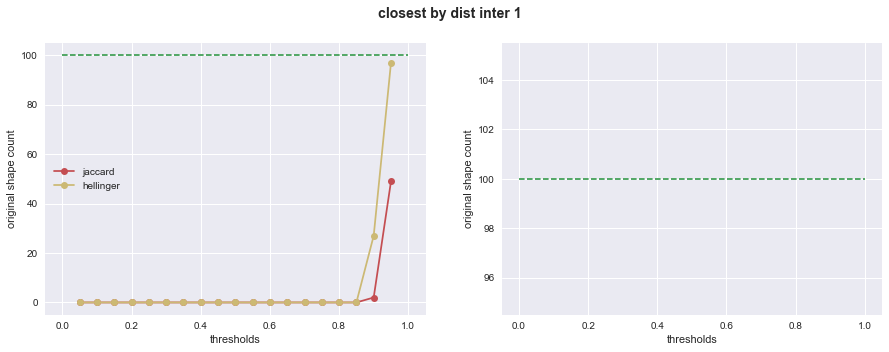

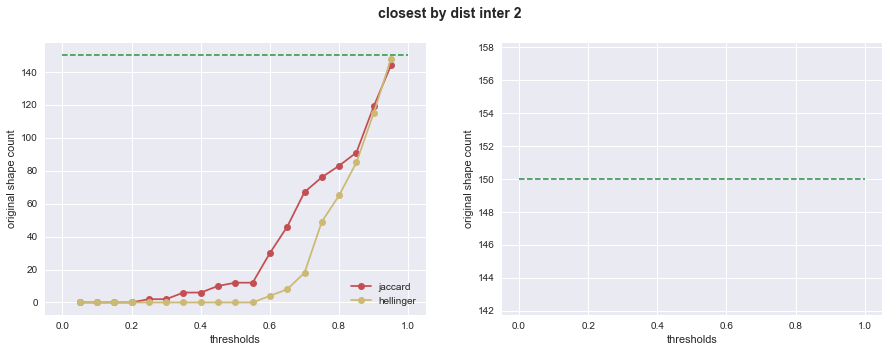

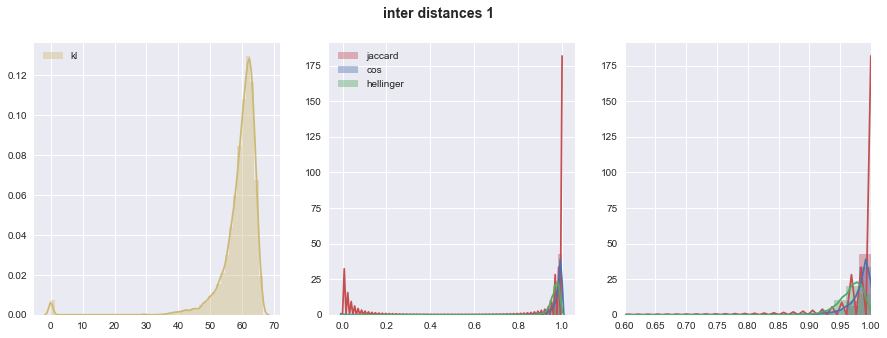

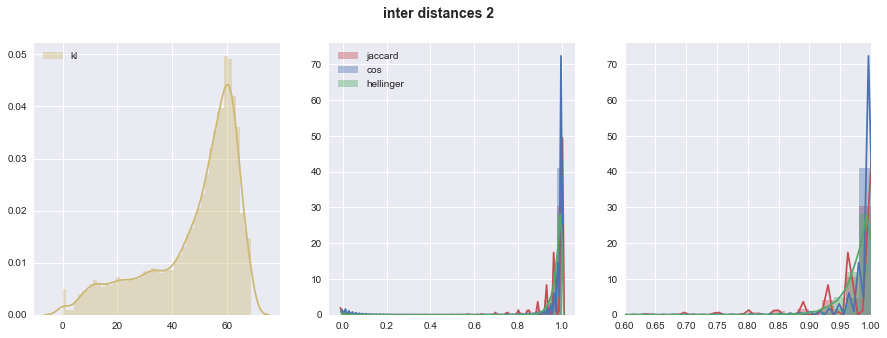

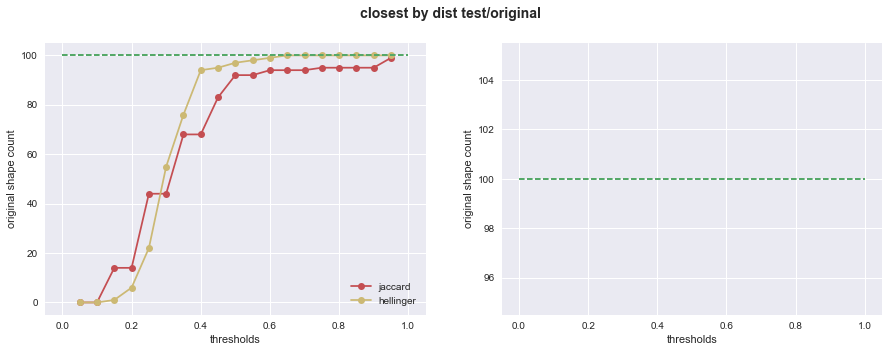

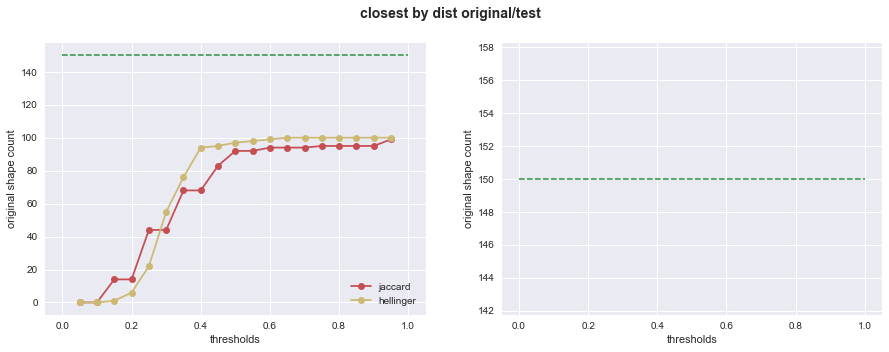

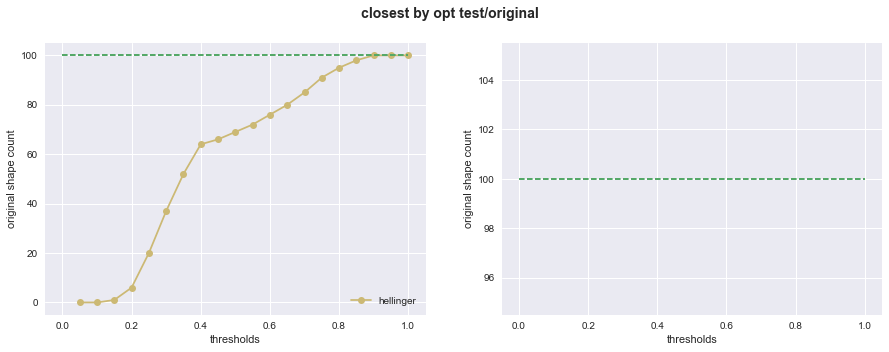

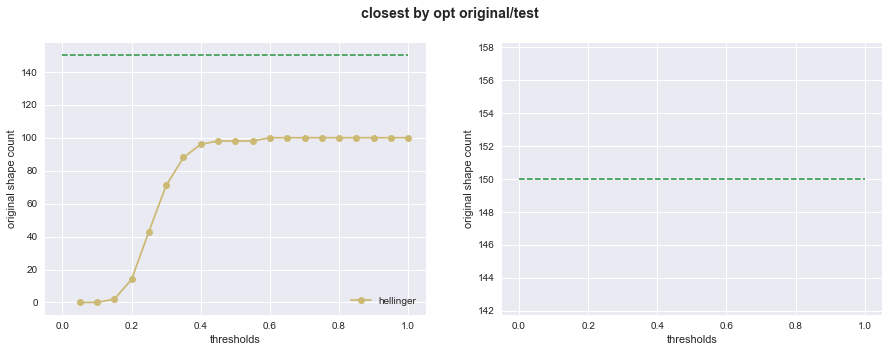

In [17]:
def create_model_rch_150_2_no_sparse(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)   
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 12
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)    
    return tmp_model

idx = 62
names_list[idx] = u'create_model_rch_150_2_no_sparse'
models_list[idx] = create_model_rch_150_2_no_sparse(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [18]:
df = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS)
df

0.2          0.4          0.6  \
150 -> 150, 0.93                  24 vs 16.05  .63 vs 0.69  .78 vs 0.76   
closest by dist test/original          j14-h6      j68-h94      j94-h99   
closest by dist original/test          j14-h6      j68-h94      j94-h99   
closest by opt res test/original        j0-h6       j0-h64       j0-h76   
closest by opt res original/test       j0-h14       j0-h96      j0-h100   

                                       0.8  
150 -> 150, 0.93                     -----  
closest by dist test/original     j95-h100  
closest by dist original/test     j95-h100  
closest by opt res test/original    j0-h95  
closest by opt res original/test   j0-h100

name = create_model_rch_150_3_no_sparse_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 50, top_tokens_score = 15, topic_kernel_score = 0.25

('Filtered topics: ', 150, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic_46', u'topic_47', u'topic_48', u'topic_49', u'topic_50', u'topic_51', u'topic_52', u'topic_53', u'topic_54', u'topic_55', u'topic_56', u'topic_57', u'topic_58', u'topic_59', u'topic_60', u'topic_61', u'topic

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   150.00
non zero ratio                    0.96     0.93
|phi_ij == 0| / n_topics       2126.43  2062.49
|phi_ij > 0.2| / n_topics         0.23     0.64
|phi_ij > 0.1| / n_topics         0.89     1.67
|phi_ij > 0.01| / n_topics       27.16    18.22
|phi_ij > 0.05| / n_topics        2.63     4.01
|phi_ij > 0.001| / n_topics      80.26    39.25
topic_kernel_average_size        23.68    16.05
topic_kernel_average_purity       0.63     0.69
topic_kernel_average_contrast     0.78     0.76

Dist fn = <function hellinger_dist at 0x000000000C184588>, Processed th = 0.95, original columns count = 149    Processing <function jaccard_dist at 0x000000000C184438>
Processing <function hellinger_dist at 0x000000000C184588>
Processing <function jaccard_dist at 0x000000000C184438>
Processing <function hellinger_dist at 0x000000000C184588>
Dist fn = <function hellinger_dist at 0x000000000C184588>, Processed th = 1.0, original columns count = 100     Column topic_0 not optimized
Column topic_1 not optimized
Column topic_2 not optimized
Column topic_5 not optimized
Column topic_7 not optimized
Column topic_15 not optimized
Column topic_21 not optimized
Column topic_29 not optimized
Column topic_30 not optimized
Column topic_32 not optimized
Column topic_34 not optimized
Column topic_39 not optimized
Column topic_44 not optimized
Column topic_45 not optimized
Column topic_48 not optimized
Column topic_51 not optimized
Column topic_55 not optimized
Column topic_56 not optimized
Column to

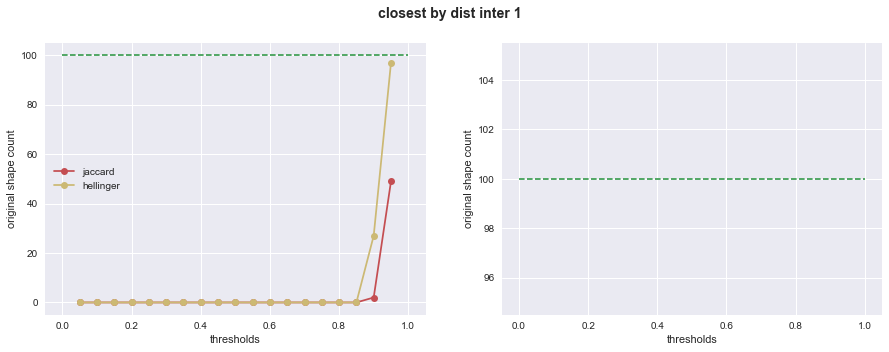

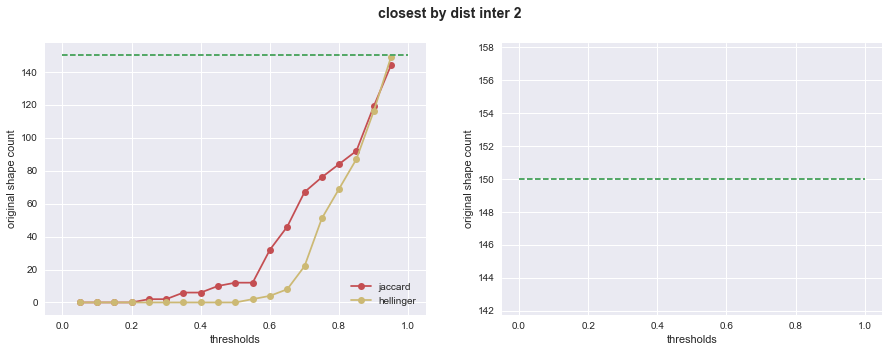

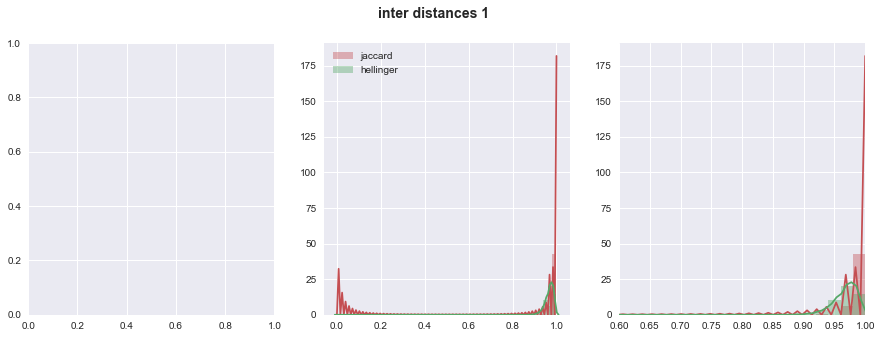

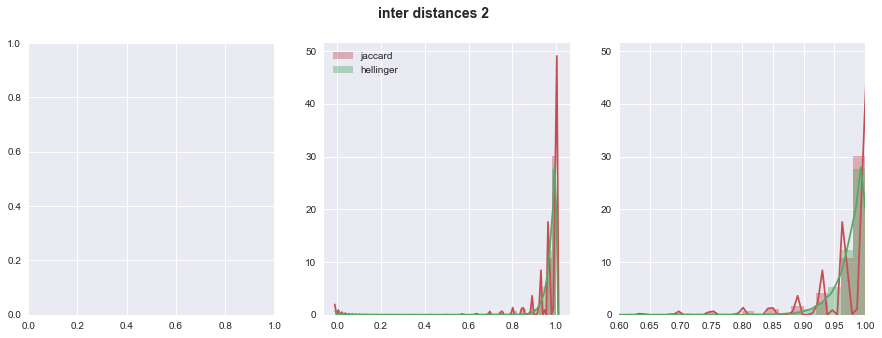

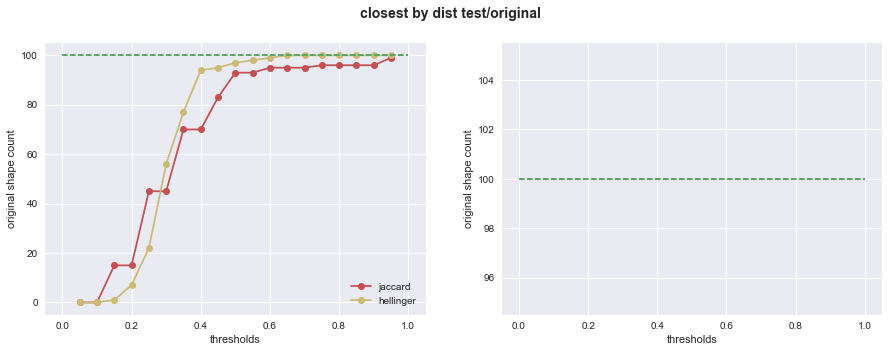

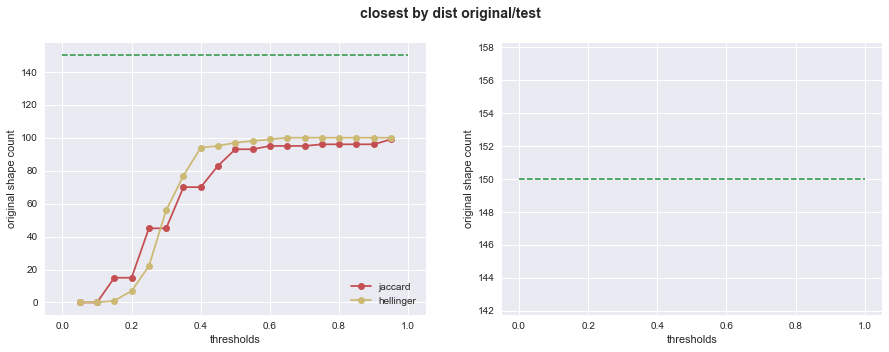

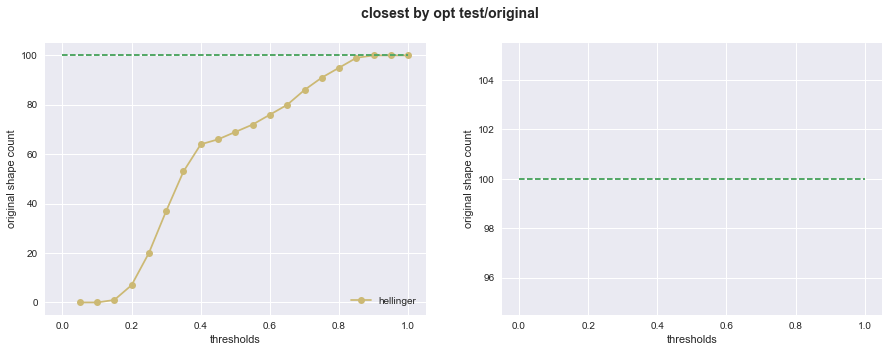

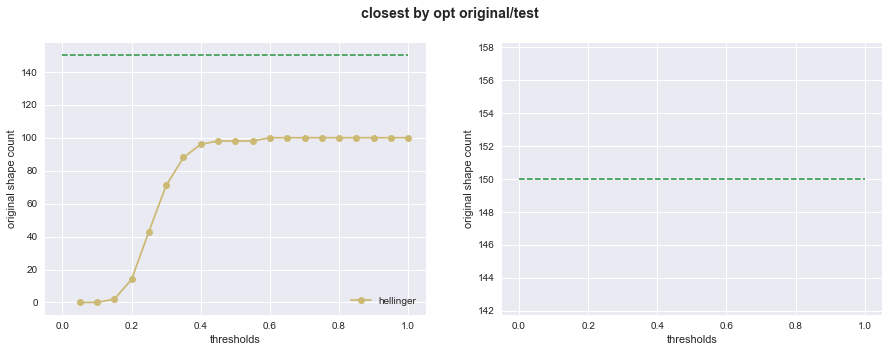

In [22]:
def create_model_rch_150_3_no_sparse(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=50, 
                                  _model_name=model_name)   
    return tmp_model

idx = 63
names_list[idx] = u'create_model_rch_150_3_no_sparse'
models_list[idx] = create_model_rch_150_3_no_sparse(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [23]:
df = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS)
df

0.2          0.4          0.6  \
150 -> 150, 0.93                  24 vs 16.05  .63 vs 0.69  .78 vs 0.76   
closest by dist test/original          j15-h7      j70-h94      j95-h99   
closest by dist original/test          j15-h7      j70-h94      j95-h99   
closest by opt res test/original        j0-h7       j0-h64       j0-h76   
closest by opt res original/test       j0-h14       j0-h96      j0-h100   

                                       0.8  
150 -> 150, 0.93                     -----  
closest by dist test/original     j96-h100  
closest by dist original/test     j96-h100  
closest by opt res test/original    j0-h95  
closest by opt res original/test   j0-h100

name = create_model_rch_150_4_no_sparse_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_150_4_no_sparse_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
decorrelator_phi_regularizer, tau = 100

('Filtered topics: ', 150, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topi

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   150.00
non zero ratio                    0.96     0.93
|phi_ij == 0| / n_topics       2126.43  2064.41
|phi_ij > 0.2| / n_topics         0.23     0.65
|phi_ij > 0.1| / n_topics         0.89     1.71
|phi_ij > 0.01| / n_topics       27.16    17.82
|phi_ij > 0.05| / n_topics        2.63     4.00
|phi_ij > 0.001| / n_topics      80.26    38.43
topic_kernel_average_size        23.68    16.10
topic_kernel_average_purity       0.63     0.71
topic_kernel_average_contrast     0.78     0.77

Dist fn = <function hellinger_dist at 0x000000000C184588>, Processed th = 0.95, original columns count = 147    Processing <function jaccard_dist at 0x000000000C184438>
Processing <function hellinger_dist at 0x000000000C184588>
Processing <function jaccard_dist at 0x000000000C184438>
Processing <function hellinger_dist at 0x000000000C184588>
Dist fn = <function hellinger_dist at 0x000000000C184588>, Processed th = 1.0, original columns count = 100     Column topic_0 not optimized
Column topic_2 not optimized
Column topic_7 not optimized
Column topic_14 not optimized
Column topic_15 not optimized
Column topic_21 not optimized
Column topic_30 not optimized
Column topic_39 not optimized
Column topic_40 not optimized
Column topic_41 not optimized
Column topic_45 not optimized
Column topic_48 not optimized
Column topic_55 not optimized
Column topic_60 not optimized
Column topic_63 not optimized
Column topic_66 not optimized
Column topic_67 not optimized
Column topic_72 not optimized
Column 

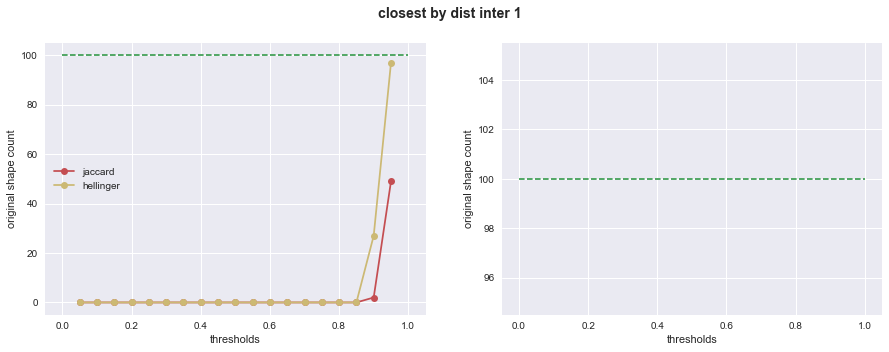

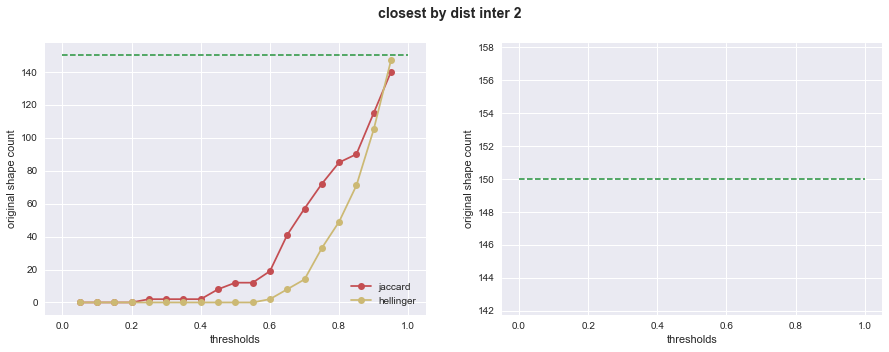

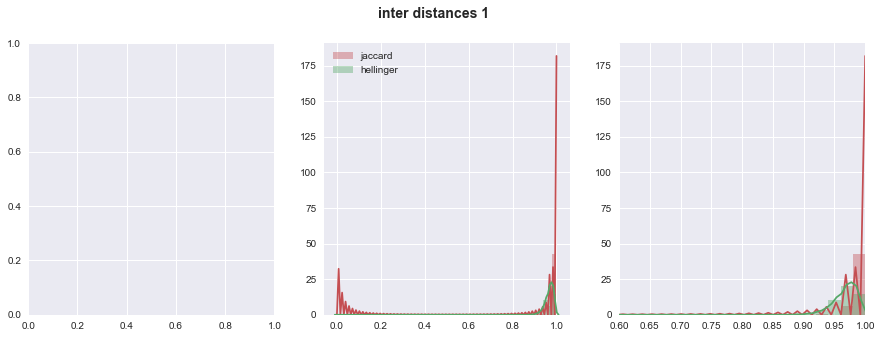

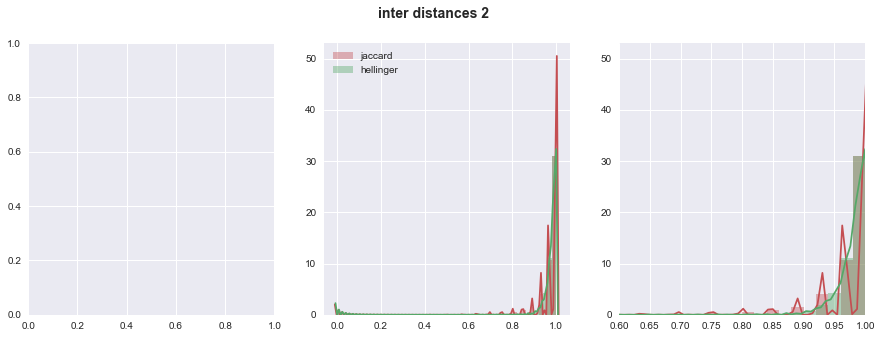

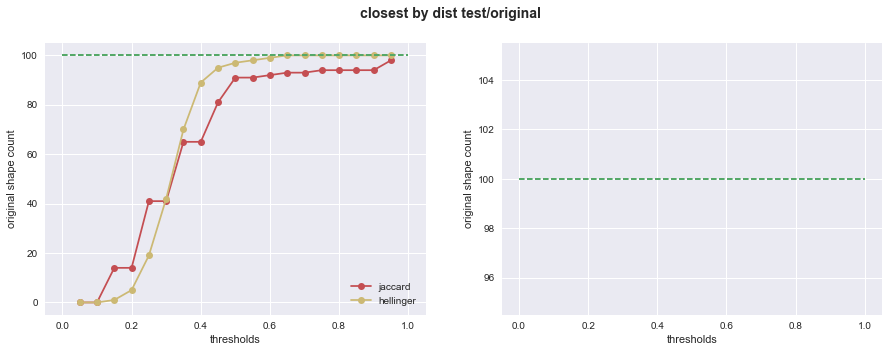

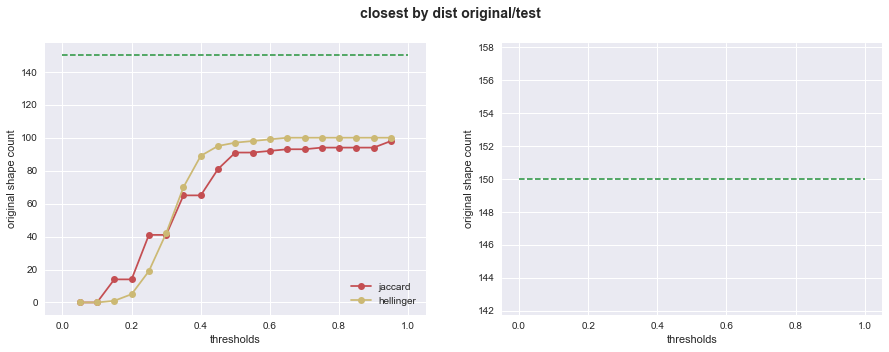

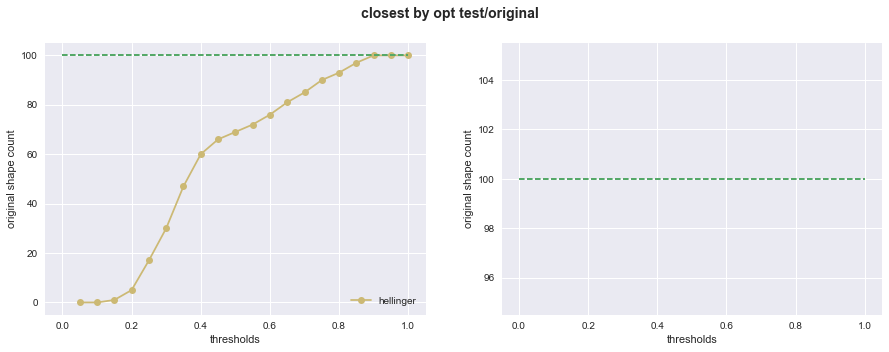

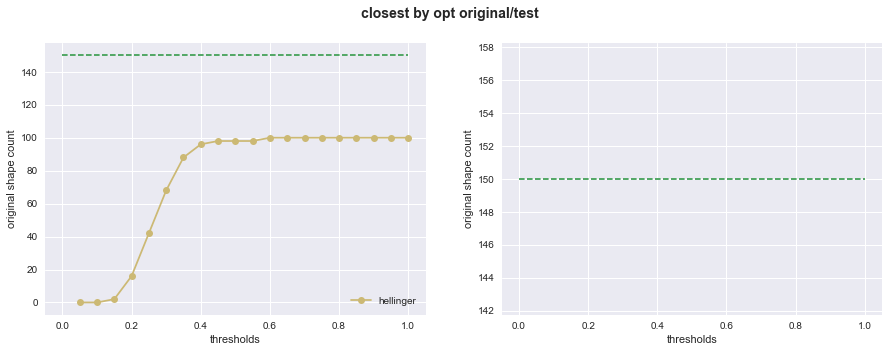

In [24]:
def create_model_rch_150_4_no_sparse(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)   
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 100
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)  
    return tmp_model

idx = 64
names_list[idx] = u'create_model_rch_150_4_no_sparse'
models_list[idx] = create_model_rch_150_4_no_sparse(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [25]:
df = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS)
df

0.2          0.4          0.6  \
150 -> 150, 0.93                  24 vs 16.10  .63 vs 0.71  .78 vs 0.77   
closest by dist test/original          j14-h5      j65-h89      j92-h99   
closest by dist original/test          j14-h5      j65-h89      j92-h99   
closest by opt res test/original        j0-h5       j0-h60       j0-h76   
closest by opt res original/test       j0-h16       j0-h96      j0-h100   

                                       0.8  
150 -> 150, 0.93                     -----  
closest by dist test/original     j94-h100  
closest by dist original/test     j94-h100  
closest by opt res test/original    j0-h93  
closest by opt res original/test   j0-h100

name = create_model_rch_150_5_no_sparse_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 5, top_tokens_score = 15, topic_kernel_score = 0.25

name = create_model_rch_150_5_no_sparse_iter_0, n_topics = 150, n_doc_passes = 5, seed_value = 100, n_iterations = 25, top_tokens_score = 15, topic_kernel_score = 0.25
decorrelator_phi_regularizer, tau = 100

('Filtered topics: ', 150, [u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5', u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10', u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15', u'topic_16', u'topic_17', u'topic_18', u'topic_19', u'topic_20', u'topic_21', u'topic_22', u'topic_23', u'topic_24', u'topic_25', u'topic_26', u'topic_27', u'topic_28', u'topic_29', u'topic_30', u'topic_31', u'topic_32', u'topic_33', u'topic_34', u'topic_35', u'topic_36', u'topic_37', u'topic_38', u'topic_39', u'topic_40', u'topic_41', u'topic_42', u'topic_43', u'topic_44', u'topic_45', u'topic

phi_1    phi_2
num words                      2216.00  2216.00
num topics                      100.00   150.00
non zero ratio                    0.96     0.88
|phi_ij == 0| / n_topics       2126.43  1951.44
|phi_ij > 0.2| / n_topics         0.23     0.63
|phi_ij > 0.1| / n_topics         0.89     1.67
|phi_ij > 0.01| / n_topics       27.16    18.69
|phi_ij > 0.05| / n_topics        2.63     4.04
|phi_ij > 0.001| / n_topics      80.26    42.49
topic_kernel_average_size        23.68    15.96
topic_kernel_average_purity       0.63     0.66
topic_kernel_average_contrast     0.78     0.75

Dist fn = <function hellinger_dist at 0x000000000C184588>, Processed th = 0.95, original columns count = 149    Processing <function jaccard_dist at 0x000000000C184438>
Processing <function hellinger_dist at 0x000000000C184588>
Processing <function jaccard_dist at 0x000000000C184438>
Processing <function hellinger_dist at 0x000000000C184588>
Dist fn = <function hellinger_dist at 0x000000000C184588>, Processed th = 1.0, original columns count = 100     Column topic_2 not optimized
Column topic_20 not optimized
Column topic_24 not optimized
Column topic_41 not optimized
Column topic_44 not optimized
Column topic_47 not optimized
Column topic_57 not optimized
Column topic_71 not optimized
Column topic_72 not optimized
Column topic_78 not optimized
Column topic_82 not optimized
Column topic_88 not optimized
Column topic_95 not optimized
Dist fn = <function hellinger_dist at 0x000000000C184588>, Processed th = 1.0, original columns count = 100     [(u'topic_0', u'topic_69', 0, 69, 0.2808616

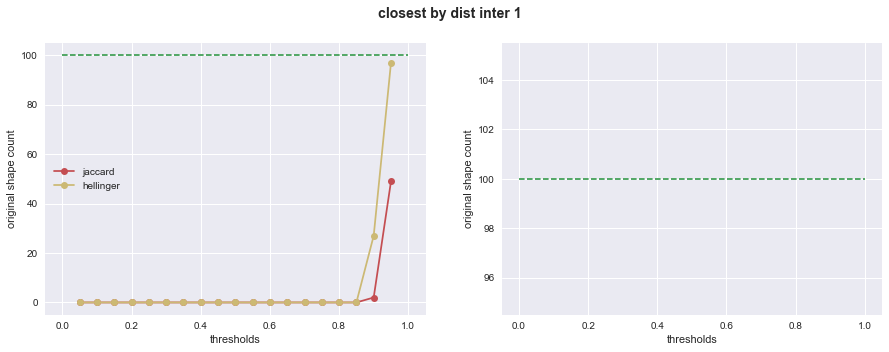

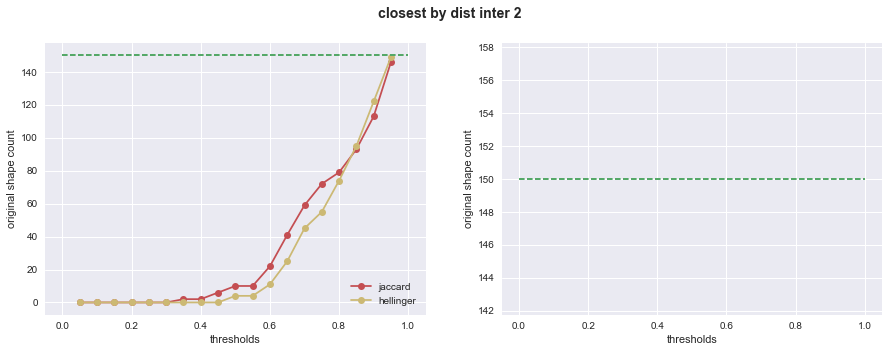

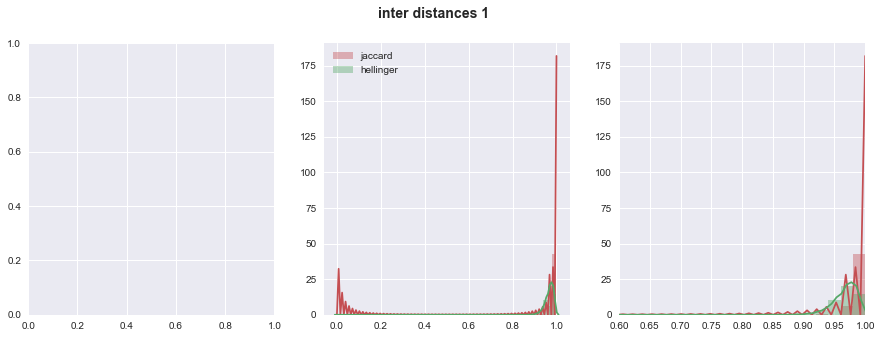

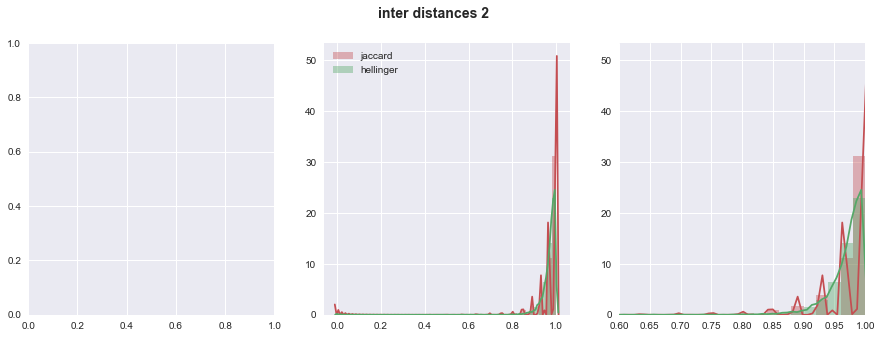

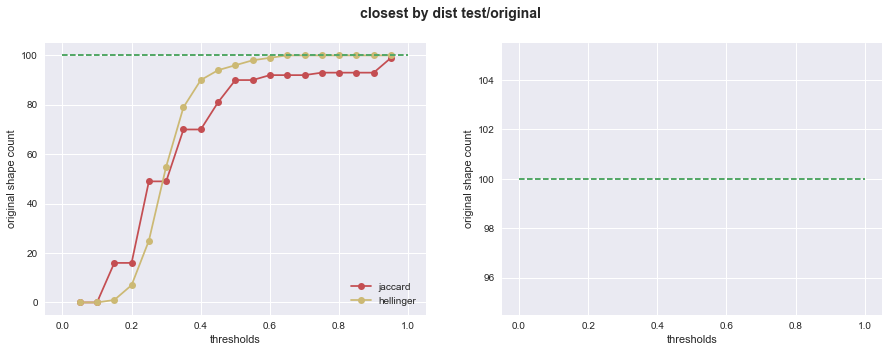

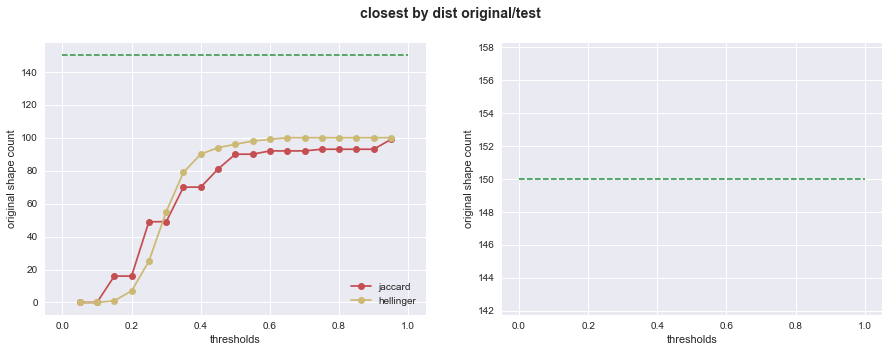

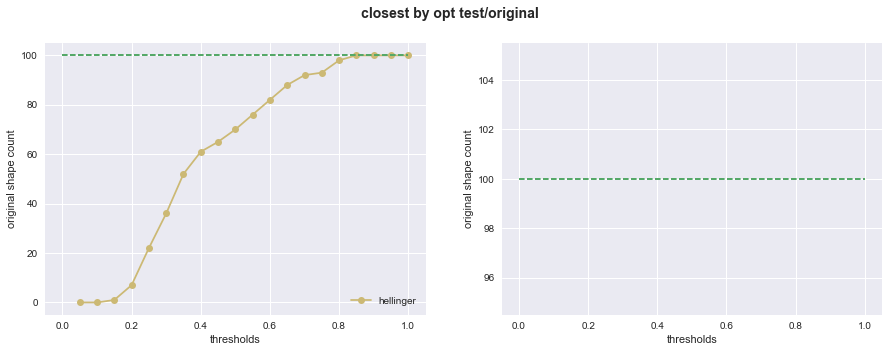

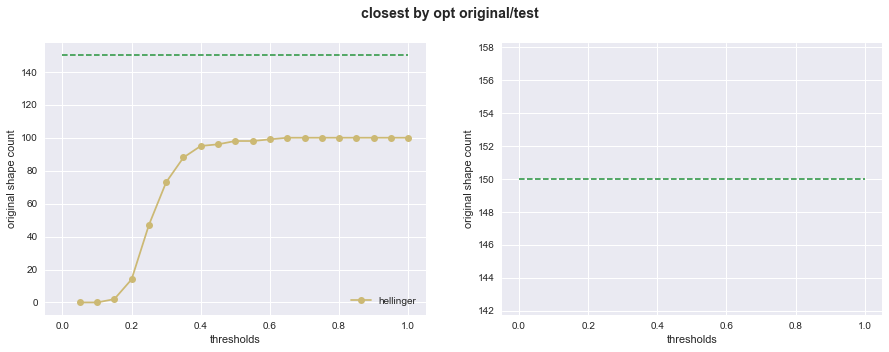

In [26]:
def create_model_rch_150_5_no_sparse(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)   
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 100
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)  
    return tmp_model

idx = 65
names_list[idx] = u'create_model_rch_150_5_no_sparse'
models_list[idx] = create_model_rch_150_5_no_sparse(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [27]:
df = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS)
df

0.2          0.4          0.6  \
150 -> 150, 0.88                  24 vs 15.96  .63 vs 0.66  .78 vs 0.75   
closest by dist test/original          j16-h7      j70-h90      j92-h99   
closest by dist original/test          j16-h7      j70-h90      j92-h99   
closest by opt res test/original        j0-h7       j0-h61       j0-h82   
closest by opt res original/test       j0-h14       j0-h95       j0-h99   

                                       0.8  
150 -> 150, 0.88                     -----  
closest by dist test/original     j93-h100  
closest by dist original/test     j93-h100  
closest by opt res test/original    j0-h98  
closest by opt res original/test   j0-h100

In [ ]:
def create_model_rch_150_6_no_sparse(n_iteration, model_name='', fit=True, n_topics=150):
    if model_name is '':
        model_name = 'model_tmp_{}'.format(n_topics)
    model_name += '_iter_{}'.format(n_iteration)
    tmp_model = cmh.create_model(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                                 n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=5, 
                                  _model_name=model_name)   
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 100
    tmp_model.regularizers['ss_theta_regularizer'].tau = -2
    tmp_model = cmh.fit_one_model(plot_maker, batch_vectorizer, models_file, config, 
                                  tmp_model, _n_iterations=25, 
                                  _model_name=model_name)  
    return tmp_model

idx = 66
names_list[idx] = u'create_model_rch_150_6_no_sparse'
models_list[idx] = create_model_rch_150_6_no_sparse(0, model_name=names_list[idx])
phi_list[idx], phi_nwt_list[idx] = models_list[idx].get_phi(), models_list[idx].get_phi(model_name=models_list[idx].model_nwt)
theta_list[idx] = models_list[idx].get_theta()

filtered_topics = [topic_name for topic_name, topic in phi_list[idx].iteritems() if check_topic_ok(topic)]
print('Filtered topics: ', len(filtered_topics), filtered_topics)
if len(filtered_topics):
    phi_filtered_list[idx] = phi_list[idx].loc[:, filtered_topics]
    phi_nwt_filtered_list[idx] = phi_nwt_list[idx].loc[:, filtered_topics]
    theta_filtered_list[idx] = theta_list[idx].loc[filtered_topics, :]

    different_inter_distances_closest_1[idx], different_inter_distances_closest_2[idx], \
        different_inter_distances_1[idx], different_inter_distances_2[idx], \
        different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx] = \
        reg_experiment(phi_original, phi_filtered_list[idx], phi_nwt_original, phi_nwt_filtered_list[idx])

In [ ]:
df = experiment_result_to_df(different_to_original_distances_closest_1[idx], different_to_test_distances_closest_2[idx], \
        different_to_original_opts_1[idx], different_to_test_opts_2[idx], models_compare_matrix[idx], init_num_topics=N_TOPICS)
df

In [20]:
save_pickle_file([different_inter_distances_closest_1, different_inter_distances_closest_2, 
        different_inter_distances_1, different_inter_distances_2, 
        different_to_original_distances_closest_1, different_to_test_distances_closest_2, 
        different_to_original_opts_1, different_to_test_opts_2, models_compare_matrix], 'result_150.p')
save_pickle_file([names_list, phi_list, phi_nwt_list, theta_list,
                  phi_filtered_list, phi_nwt_filtered_list, theta_filtered_list], 'init_150.p')